In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from scipy.stats import wasserstein_distance, entropy
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from umap import UMAP
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')
run_stats = {}

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "QPM2_species"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

Dataset type train label type: species


Loaded 239318 images
Dataset type val label type: species


Loaded 59836 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 97692 images
Dataset type test label type: species


 - Min class count:  13956
Loaded 0 images


In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 vkur2fs8


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_e_u = []
    trn_e_v = []
    trn_rcn = []
    trn_tgt = []

    val_inp = []
    val_e_u = []
    val_e_v = []
    val_rcn = []
    val_tgt = []

    ind_inp = []
    ind_e_u = []
    ind_e_v = []
    ind_rcn = []
    ind_tgt = []

    if ood_str:
        ood_inp = []
        ood_e_u = []
        ood_e_v = []
        ood_rcn = []
        ood_tgt = []

    rnd_inp = []
    rnd_e_u = []
    rnd_e_v = []
    rnd_rcn = []

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_e_u.extend(e_u.detach().cpu().numpy())
        trn_e_v.extend(e_v.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_e_u.extend(e_u.detach().cpu().numpy())
        val_e_v.extend(e_v.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_e_u.extend(e_u.detach().cpu().numpy())
        ind_e_v.extend(e_v.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_e_u.extend(e_u.detach().cpu().numpy())
            ood_e_v.extend(e_v.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_e_u.extend(e_u.detach().cpu().numpy())
        rnd_e_v.extend(e_v.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                                                           | 0/1870 [00:00<?, ?it/s]

  0%|                                                                                                                                                   | 1/1870 [00:01<42:09,  1.35s/it]

  0%|▏                                                                                                                                                  | 2/1870 [00:01<20:27,  1.52it/s]

  0%|▏                                                                                                                                                  | 3/1870 [00:01<13:31,  2.30it/s]

  0%|▎                                                                                                                                                  | 4/1870 [00:01<10:15,  3.03it/s]

  0%|▍                                                                                                                                                  | 5/1870 [00:02<08:26,  3.68it/s]

  0%|▍                                                                                                                                                  | 6/1870 [00:02<07:21,  4.22it/s]

  0%|▌                                                                                                                                                  | 7/1870 [00:02<06:39,  4.66it/s]

  0%|▋                                                                                                                                                  | 8/1870 [00:02<06:12,  5.00it/s]

  0%|▋                                                                                                                                                  | 9/1870 [00:02<05:54,  5.25it/s]

  1%|▊                                                                                                                                                 | 10/1870 [00:02<05:42,  5.43it/s]

  1%|▊                                                                                                                                                 | 11/1870 [00:03<05:34,  5.56it/s]

  1%|▉                                                                                                                                                 | 12/1870 [00:03<05:28,  5.66it/s]

  1%|█                                                                                                                                                 | 13/1870 [00:03<05:24,  5.72it/s]

  1%|█                                                                                                                                                 | 14/1870 [00:03<05:21,  5.77it/s]

  1%|█▏                                                                                                                                                | 15/1870 [00:03<05:19,  5.80it/s]

  1%|█▏                                                                                                                                                | 16/1870 [00:03<05:18,  5.82it/s]

  1%|█▎                                                                                                                                                | 17/1870 [00:04<05:17,  5.84it/s]

  1%|█▍                                                                                                                                                | 18/1870 [00:04<05:16,  5.85it/s]

  1%|█▍                                                                                                                                                | 19/1870 [00:04<05:15,  5.86it/s]

  1%|█▌                                                                                                                                                | 20/1870 [00:04<05:15,  5.87it/s]

  1%|█▋                                                                                                                                                | 21/1870 [00:04<05:14,  5.87it/s]

  1%|█▋                                                                                                                                                | 22/1870 [00:04<05:14,  5.88it/s]

  1%|█▊                                                                                                                                                | 23/1870 [00:05<05:14,  5.87it/s]

  1%|█▊                                                                                                                                                | 24/1870 [00:05<05:14,  5.88it/s]

  1%|█▉                                                                                                                                                | 25/1870 [00:05<05:13,  5.88it/s]

  1%|██                                                                                                                                                | 26/1870 [00:05<05:13,  5.88it/s]

  1%|██                                                                                                                                                | 27/1870 [00:05<05:13,  5.88it/s]

  1%|██▏                                                                                                                                               | 28/1870 [00:05<05:13,  5.88it/s]

  2%|██▎                                                                                                                                               | 29/1870 [00:06<05:12,  5.88it/s]

  2%|██▎                                                                                                                                               | 30/1870 [00:06<05:12,  5.88it/s]

  2%|██▍                                                                                                                                               | 31/1870 [00:06<05:12,  5.88it/s]

  2%|██▍                                                                                                                                               | 32/1870 [00:06<05:12,  5.88it/s]

  2%|██▌                                                                                                                                               | 33/1870 [00:06<05:12,  5.88it/s]

  2%|██▋                                                                                                                                               | 34/1870 [00:06<05:11,  5.89it/s]

  2%|██▋                                                                                                                                               | 35/1870 [00:07<05:11,  5.89it/s]

  2%|██▊                                                                                                                                               | 36/1870 [00:07<05:11,  5.88it/s]

  2%|██▉                                                                                                                                               | 37/1870 [00:07<05:11,  5.88it/s]

  2%|██▉                                                                                                                                               | 38/1870 [00:07<05:11,  5.88it/s]

  2%|███                                                                                                                                               | 39/1870 [00:07<05:11,  5.88it/s]

  2%|███                                                                                                                                               | 40/1870 [00:07<05:11,  5.88it/s]

  2%|███▏                                                                                                                                              | 41/1870 [00:08<05:10,  5.88it/s]

  2%|███▎                                                                                                                                              | 42/1870 [00:08<05:10,  5.88it/s]

  2%|███▎                                                                                                                                              | 43/1870 [00:08<05:10,  5.88it/s]

  2%|███▍                                                                                                                                              | 44/1870 [00:08<05:10,  5.87it/s]

  2%|███▌                                                                                                                                              | 45/1870 [00:08<05:10,  5.88it/s]

  2%|███▌                                                                                                                                              | 46/1870 [00:08<05:10,  5.88it/s]

  3%|███▋                                                                                                                                              | 47/1870 [00:09<05:10,  5.88it/s]

  3%|███▋                                                                                                                                              | 48/1870 [00:09<05:09,  5.88it/s]

  3%|███▊                                                                                                                                              | 49/1870 [00:09<05:09,  5.88it/s]

  3%|███▉                                                                                                                                              | 50/1870 [00:09<05:09,  5.88it/s]

  3%|███▉                                                                                                                                              | 51/1870 [00:09<05:09,  5.88it/s]

  3%|████                                                                                                                                              | 52/1870 [00:10<05:09,  5.88it/s]

  3%|████▏                                                                                                                                             | 53/1870 [00:10<05:09,  5.88it/s]

  3%|████▏                                                                                                                                             | 54/1870 [00:10<05:09,  5.88it/s]

  3%|████▎                                                                                                                                             | 55/1870 [00:10<05:08,  5.88it/s]

  3%|████▎                                                                                                                                             | 56/1870 [00:10<05:08,  5.88it/s]

  3%|████▍                                                                                                                                             | 57/1870 [00:10<05:08,  5.88it/s]

  3%|████▌                                                                                                                                             | 58/1870 [00:11<05:08,  5.87it/s]

  3%|████▌                                                                                                                                             | 59/1870 [00:11<05:08,  5.87it/s]

  3%|████▋                                                                                                                                             | 60/1870 [00:11<05:08,  5.88it/s]

  3%|████▊                                                                                                                                             | 61/1870 [00:11<05:07,  5.88it/s]

  3%|████▊                                                                                                                                             | 62/1870 [00:11<05:07,  5.88it/s]

  3%|████▉                                                                                                                                             | 63/1870 [00:11<05:07,  5.88it/s]

  3%|████▉                                                                                                                                             | 64/1870 [00:12<05:07,  5.88it/s]

  3%|█████                                                                                                                                             | 65/1870 [00:12<05:07,  5.87it/s]

  4%|█████▏                                                                                                                                            | 66/1870 [00:12<05:07,  5.88it/s]

  4%|█████▏                                                                                                                                            | 67/1870 [00:12<05:06,  5.88it/s]

  4%|█████▎                                                                                                                                            | 68/1870 [00:12<05:06,  5.88it/s]

  4%|█████▍                                                                                                                                            | 69/1870 [00:12<05:06,  5.88it/s]

  4%|█████▍                                                                                                                                            | 70/1870 [00:13<05:06,  5.88it/s]

  4%|█████▌                                                                                                                                            | 71/1870 [00:13<05:05,  5.88it/s]

  4%|█████▌                                                                                                                                            | 72/1870 [00:13<05:05,  5.88it/s]

  4%|█████▋                                                                                                                                            | 73/1870 [00:13<05:05,  5.88it/s]

  4%|█████▊                                                                                                                                            | 74/1870 [00:13<05:05,  5.88it/s]

  4%|█████▊                                                                                                                                            | 75/1870 [00:13<05:05,  5.89it/s]

  4%|█████▉                                                                                                                                            | 76/1870 [00:14<05:04,  5.89it/s]

  4%|██████                                                                                                                                            | 77/1870 [00:14<05:04,  5.89it/s]

  4%|██████                                                                                                                                            | 78/1870 [00:14<05:04,  5.89it/s]

  4%|██████▏                                                                                                                                           | 79/1870 [00:14<05:04,  5.88it/s]

  4%|██████▏                                                                                                                                           | 80/1870 [00:14<05:04,  5.88it/s]

  4%|██████▎                                                                                                                                           | 81/1870 [00:14<05:04,  5.88it/s]

  4%|██████▍                                                                                                                                           | 82/1870 [00:15<05:03,  5.88it/s]

  4%|██████▍                                                                                                                                           | 83/1870 [00:15<05:03,  5.88it/s]

  4%|██████▌                                                                                                                                           | 84/1870 [00:15<05:03,  5.89it/s]

  5%|██████▋                                                                                                                                           | 85/1870 [00:15<05:03,  5.89it/s]

  5%|██████▋                                                                                                                                           | 86/1870 [00:15<05:03,  5.88it/s]

  5%|██████▊                                                                                                                                           | 87/1870 [00:15<05:03,  5.88it/s]

  5%|██████▊                                                                                                                                           | 88/1870 [00:16<05:03,  5.88it/s]

  5%|██████▉                                                                                                                                           | 89/1870 [00:16<05:02,  5.88it/s]

  5%|███████                                                                                                                                           | 90/1870 [00:16<05:02,  5.88it/s]

  5%|███████                                                                                                                                           | 91/1870 [00:16<05:02,  5.88it/s]

  5%|███████▏                                                                                                                                          | 92/1870 [00:16<05:02,  5.88it/s]

  5%|███████▎                                                                                                                                          | 93/1870 [00:16<05:02,  5.87it/s]

  5%|███████▎                                                                                                                                          | 94/1870 [00:17<05:02,  5.88it/s]

  5%|███████▍                                                                                                                                          | 95/1870 [00:17<05:01,  5.88it/s]

  5%|███████▍                                                                                                                                          | 96/1870 [00:17<05:01,  5.88it/s]

  5%|███████▌                                                                                                                                          | 97/1870 [00:17<05:01,  5.88it/s]

  5%|███████▋                                                                                                                                          | 98/1870 [00:17<05:01,  5.88it/s]

  5%|███████▋                                                                                                                                          | 99/1870 [00:18<05:01,  5.88it/s]

  5%|███████▊                                                                                                                                         | 100/1870 [00:18<05:01,  5.87it/s]

  5%|███████▊                                                                                                                                         | 101/1870 [00:18<05:00,  5.88it/s]

  5%|███████▉                                                                                                                                         | 102/1870 [00:18<05:00,  5.88it/s]

  6%|███████▉                                                                                                                                         | 103/1870 [00:18<05:00,  5.88it/s]

  6%|████████                                                                                                                                         | 104/1870 [00:18<05:00,  5.88it/s]

  6%|████████▏                                                                                                                                        | 105/1870 [00:19<05:00,  5.88it/s]

  6%|████████▏                                                                                                                                        | 106/1870 [00:19<04:59,  5.88it/s]

  6%|████████▎                                                                                                                                        | 107/1870 [00:19<05:00,  5.87it/s]

  6%|████████▎                                                                                                                                        | 108/1870 [00:19<04:59,  5.88it/s]

  6%|████████▍                                                                                                                                        | 109/1870 [00:19<04:59,  5.88it/s]

  6%|████████▌                                                                                                                                        | 110/1870 [00:19<04:59,  5.88it/s]

  6%|████████▌                                                                                                                                        | 111/1870 [00:20<04:59,  5.88it/s]

  6%|████████▋                                                                                                                                        | 112/1870 [00:20<04:58,  5.88it/s]

  6%|████████▊                                                                                                                                        | 113/1870 [00:20<04:58,  5.88it/s]

  6%|████████▊                                                                                                                                        | 114/1870 [00:20<04:58,  5.88it/s]

  6%|████████▉                                                                                                                                        | 115/1870 [00:20<04:58,  5.88it/s]

  6%|████████▉                                                                                                                                        | 116/1870 [00:20<04:58,  5.88it/s]

  6%|█████████                                                                                                                                        | 117/1870 [00:21<04:57,  5.88it/s]

  6%|█████████▏                                                                                                                                       | 118/1870 [00:21<04:57,  5.88it/s]

  6%|█████████▏                                                                                                                                       | 119/1870 [00:21<04:57,  5.89it/s]

  6%|█████████▎                                                                                                                                       | 120/1870 [00:21<04:57,  5.89it/s]

  6%|█████████▍                                                                                                                                       | 121/1870 [00:21<04:57,  5.88it/s]

  7%|█████████▍                                                                                                                                       | 122/1870 [00:21<04:57,  5.88it/s]

  7%|█████████▌                                                                                                                                       | 123/1870 [00:22<04:56,  5.88it/s]

  7%|█████████▌                                                                                                                                       | 124/1870 [00:22<04:56,  5.89it/s]

  7%|█████████▋                                                                                                                                       | 125/1870 [00:22<04:56,  5.89it/s]

  7%|█████████▊                                                                                                                                       | 126/1870 [00:22<04:56,  5.89it/s]

  7%|█████████▊                                                                                                                                       | 127/1870 [00:22<04:56,  5.89it/s]

  7%|█████████▉                                                                                                                                       | 128/1870 [00:22<04:56,  5.88it/s]

  7%|██████████                                                                                                                                       | 129/1870 [00:23<04:56,  5.88it/s]

  7%|██████████                                                                                                                                       | 130/1870 [00:23<04:55,  5.88it/s]

  7%|██████████▏                                                                                                                                      | 131/1870 [00:23<04:55,  5.88it/s]

  7%|██████████▏                                                                                                                                      | 132/1870 [00:23<04:55,  5.88it/s]

  7%|██████████▎                                                                                                                                      | 133/1870 [00:23<04:55,  5.88it/s]

  7%|██████████▍                                                                                                                                      | 134/1870 [00:23<04:55,  5.88it/s]

  7%|██████████▍                                                                                                                                      | 135/1870 [00:24<04:55,  5.88it/s]

  7%|██████████▌                                                                                                                                      | 136/1870 [00:24<04:54,  5.88it/s]

  7%|██████████▌                                                                                                                                      | 137/1870 [00:24<04:54,  5.88it/s]

  7%|██████████▋                                                                                                                                      | 138/1870 [00:24<04:54,  5.88it/s]

  7%|██████████▊                                                                                                                                      | 139/1870 [00:24<04:54,  5.88it/s]

  7%|██████████▊                                                                                                                                      | 140/1870 [00:24<04:54,  5.88it/s]

  8%|██████████▉                                                                                                                                      | 141/1870 [00:25<04:53,  5.89it/s]

  8%|███████████                                                                                                                                      | 142/1870 [00:25<04:53,  5.88it/s]

  8%|███████████                                                                                                                                      | 143/1870 [00:25<04:53,  5.88it/s]

  8%|███████████▏                                                                                                                                     | 144/1870 [00:25<04:53,  5.88it/s]

  8%|███████████▏                                                                                                                                     | 145/1870 [00:25<04:53,  5.89it/s]

  8%|███████████▎                                                                                                                                     | 146/1870 [00:26<04:52,  5.89it/s]

  8%|███████████▍                                                                                                                                     | 147/1870 [00:26<04:52,  5.89it/s]

  8%|███████████▍                                                                                                                                     | 148/1870 [00:26<04:52,  5.89it/s]

  8%|███████████▌                                                                                                                                     | 149/1870 [00:26<04:52,  5.88it/s]

  8%|███████████▋                                                                                                                                     | 150/1870 [00:26<04:52,  5.88it/s]

  8%|███████████▋                                                                                                                                     | 151/1870 [00:26<04:52,  5.88it/s]

  8%|███████████▊                                                                                                                                     | 152/1870 [00:27<04:52,  5.88it/s]

  8%|███████████▊                                                                                                                                     | 153/1870 [00:27<04:51,  5.88it/s]

  8%|███████████▉                                                                                                                                     | 154/1870 [00:27<04:51,  5.88it/s]

  8%|████████████                                                                                                                                     | 155/1870 [00:27<04:51,  5.89it/s]

  8%|████████████                                                                                                                                     | 156/1870 [00:27<04:51,  5.88it/s]

  8%|████████████▏                                                                                                                                    | 157/1870 [00:27<04:51,  5.88it/s]

  8%|████████████▎                                                                                                                                    | 158/1870 [00:28<04:51,  5.88it/s]

  9%|████████████▎                                                                                                                                    | 159/1870 [00:28<04:50,  5.88it/s]

  9%|████████████▍                                                                                                                                    | 160/1870 [00:28<04:50,  5.88it/s]

  9%|████████████▍                                                                                                                                    | 161/1870 [00:28<04:50,  5.88it/s]

  9%|████████████▌                                                                                                                                    | 162/1870 [00:28<04:50,  5.88it/s]

  9%|████████████▋                                                                                                                                    | 163/1870 [00:28<04:50,  5.87it/s]

  9%|████████████▋                                                                                                                                    | 164/1870 [00:29<04:50,  5.88it/s]

  9%|████████████▊                                                                                                                                    | 165/1870 [00:29<04:50,  5.88it/s]

  9%|████████████▊                                                                                                                                    | 166/1870 [00:29<04:49,  5.88it/s]

  9%|████████████▉                                                                                                                                    | 167/1870 [00:29<04:49,  5.88it/s]

  9%|█████████████                                                                                                                                    | 168/1870 [00:29<04:49,  5.88it/s]

  9%|█████████████                                                                                                                                    | 169/1870 [00:29<04:49,  5.88it/s]

  9%|█████████████▏                                                                                                                                   | 170/1870 [00:30<04:49,  5.88it/s]

  9%|█████████████▎                                                                                                                                   | 171/1870 [00:30<04:49,  5.88it/s]

  9%|█████████████▎                                                                                                                                   | 172/1870 [00:30<04:48,  5.88it/s]

  9%|█████████████▍                                                                                                                                   | 173/1870 [00:30<04:48,  5.88it/s]

  9%|█████████████▍                                                                                                                                   | 174/1870 [00:30<04:48,  5.88it/s]

  9%|█████████████▌                                                                                                                                   | 175/1870 [00:30<04:48,  5.88it/s]

  9%|█████████████▋                                                                                                                                   | 176/1870 [00:31<04:48,  5.88it/s]

  9%|█████████████▋                                                                                                                                   | 177/1870 [00:31<04:48,  5.87it/s]

 10%|█████████████▊                                                                                                                                   | 178/1870 [00:31<04:48,  5.87it/s]

 10%|█████████████▉                                                                                                                                   | 179/1870 [00:31<04:47,  5.87it/s]

 10%|█████████████▉                                                                                                                                   | 180/1870 [00:31<04:47,  5.88it/s]

 10%|██████████████                                                                                                                                   | 181/1870 [00:31<04:47,  5.88it/s]

 10%|██████████████                                                                                                                                   | 182/1870 [00:32<04:47,  5.88it/s]

 10%|██████████████▏                                                                                                                                  | 183/1870 [00:32<04:46,  5.88it/s]

 10%|██████████████▎                                                                                                                                  | 184/1870 [00:32<04:47,  5.87it/s]

 10%|██████████████▎                                                                                                                                  | 185/1870 [00:32<04:46,  5.87it/s]

 10%|██████████████▍                                                                                                                                  | 186/1870 [00:32<04:46,  5.87it/s]

 10%|██████████████▌                                                                                                                                  | 187/1870 [00:32<04:46,  5.87it/s]

 10%|██████████████▌                                                                                                                                  | 188/1870 [00:33<04:46,  5.87it/s]

 10%|██████████████▋                                                                                                                                  | 189/1870 [00:33<04:46,  5.88it/s]

 10%|██████████████▋                                                                                                                                  | 190/1870 [00:33<04:45,  5.88it/s]

 10%|██████████████▊                                                                                                                                  | 191/1870 [00:33<04:46,  5.87it/s]

 10%|██████████████▉                                                                                                                                  | 192/1870 [00:33<04:45,  5.87it/s]

 10%|██████████████▉                                                                                                                                  | 193/1870 [00:33<04:45,  5.87it/s]

 10%|███████████████                                                                                                                                  | 194/1870 [00:34<04:45,  5.87it/s]

 10%|███████████████                                                                                                                                  | 195/1870 [00:34<04:45,  5.87it/s]

 10%|███████████████▏                                                                                                                                 | 196/1870 [00:34<04:45,  5.87it/s]

 11%|███████████████▎                                                                                                                                 | 197/1870 [00:34<04:44,  5.87it/s]

 11%|███████████████▎                                                                                                                                 | 198/1870 [00:34<04:45,  5.87it/s]

 11%|███████████████▍                                                                                                                                 | 199/1870 [00:35<04:44,  5.87it/s]

 11%|███████████████▌                                                                                                                                 | 200/1870 [00:35<04:44,  5.87it/s]

 11%|███████████████▌                                                                                                                                 | 201/1870 [00:35<04:44,  5.87it/s]

 11%|███████████████▋                                                                                                                                 | 202/1870 [00:35<04:44,  5.87it/s]

 11%|███████████████▋                                                                                                                                 | 203/1870 [00:35<04:43,  5.87it/s]

 11%|███████████████▊                                                                                                                                 | 204/1870 [00:35<04:43,  5.87it/s]

 11%|███████████████▉                                                                                                                                 | 205/1870 [00:36<04:43,  5.87it/s]

 11%|███████████████▉                                                                                                                                 | 206/1870 [00:36<04:43,  5.87it/s]

 11%|████████████████                                                                                                                                 | 207/1870 [00:36<04:43,  5.87it/s]

 11%|████████████████▏                                                                                                                                | 208/1870 [00:36<04:43,  5.87it/s]

 11%|████████████████▏                                                                                                                                | 209/1870 [00:36<04:42,  5.87it/s]

 11%|████████████████▎                                                                                                                                | 210/1870 [00:36<04:42,  5.87it/s]

 11%|████████████████▎                                                                                                                                | 211/1870 [00:37<04:42,  5.87it/s]

 11%|████████████████▍                                                                                                                                | 212/1870 [00:37<04:42,  5.87it/s]

 11%|████████████████▌                                                                                                                                | 213/1870 [00:37<04:42,  5.87it/s]

 11%|████████████████▌                                                                                                                                | 214/1870 [00:37<04:42,  5.87it/s]

 11%|████████████████▋                                                                                                                                | 215/1870 [00:37<04:41,  5.87it/s]

 12%|████████████████▋                                                                                                                                | 216/1870 [00:37<04:41,  5.87it/s]

 12%|████████████████▊                                                                                                                                | 217/1870 [00:38<04:41,  5.87it/s]

 12%|████████████████▉                                                                                                                                | 218/1870 [00:38<04:41,  5.87it/s]

 12%|████████████████▉                                                                                                                                | 219/1870 [00:38<04:41,  5.87it/s]

 12%|█████████████████                                                                                                                                | 220/1870 [00:38<04:41,  5.87it/s]

 12%|█████████████████▏                                                                                                                               | 221/1870 [00:38<04:40,  5.87it/s]

 12%|█████████████████▏                                                                                                                               | 222/1870 [00:38<04:40,  5.87it/s]

 12%|█████████████████▎                                                                                                                               | 223/1870 [00:39<04:40,  5.88it/s]

 12%|█████████████████▎                                                                                                                               | 224/1870 [00:39<04:39,  5.88it/s]

 12%|█████████████████▍                                                                                                                               | 225/1870 [00:39<04:39,  5.88it/s]

 12%|█████████████████▌                                                                                                                               | 226/1870 [00:39<04:39,  5.87it/s]

 12%|█████████████████▌                                                                                                                               | 227/1870 [00:39<04:39,  5.88it/s]

 12%|█████████████████▋                                                                                                                               | 228/1870 [00:39<04:39,  5.88it/s]

 12%|█████████████████▊                                                                                                                               | 229/1870 [00:40<04:39,  5.88it/s]

 12%|█████████████████▊                                                                                                                               | 230/1870 [00:40<04:39,  5.88it/s]

 12%|█████████████████▉                                                                                                                               | 231/1870 [00:40<04:38,  5.88it/s]

 12%|█████████████████▉                                                                                                                               | 232/1870 [00:40<04:38,  5.88it/s]

 12%|██████████████████                                                                                                                               | 233/1870 [00:40<04:38,  5.87it/s]

 13%|██████████████████▏                                                                                                                              | 234/1870 [00:40<04:38,  5.88it/s]

 13%|██████████████████▏                                                                                                                              | 235/1870 [00:41<04:38,  5.88it/s]

 13%|██████████████████▎                                                                                                                              | 236/1870 [00:41<04:38,  5.88it/s]

 13%|██████████████████▍                                                                                                                              | 237/1870 [00:41<04:37,  5.88it/s]

 13%|██████████████████▍                                                                                                                              | 238/1870 [00:41<04:37,  5.88it/s]

 13%|██████████████████▌                                                                                                                              | 239/1870 [00:41<04:37,  5.88it/s]

 13%|██████████████████▌                                                                                                                              | 240/1870 [00:42<04:37,  5.87it/s]

 13%|██████████████████▋                                                                                                                              | 241/1870 [00:42<04:37,  5.88it/s]

 13%|██████████████████▊                                                                                                                              | 242/1870 [00:42<04:36,  5.88it/s]

 13%|██████████████████▊                                                                                                                              | 243/1870 [00:42<04:36,  5.88it/s]

 13%|██████████████████▉                                                                                                                              | 244/1870 [00:42<04:36,  5.88it/s]

 13%|██████████████████▉                                                                                                                              | 245/1870 [00:42<04:36,  5.88it/s]

 13%|███████████████████                                                                                                                              | 246/1870 [00:43<04:36,  5.88it/s]

 13%|███████████████████▏                                                                                                                             | 247/1870 [00:43<04:36,  5.87it/s]

 13%|███████████████████▏                                                                                                                             | 248/1870 [00:43<04:36,  5.88it/s]

 13%|███████████████████▎                                                                                                                             | 249/1870 [00:43<04:35,  5.88it/s]

 13%|███████████████████▍                                                                                                                             | 250/1870 [00:43<04:35,  5.87it/s]

 13%|███████████████████▍                                                                                                                             | 251/1870 [00:43<04:35,  5.88it/s]

 13%|███████████████████▌                                                                                                                             | 252/1870 [00:44<04:35,  5.88it/s]

 14%|███████████████████▌                                                                                                                             | 253/1870 [00:44<04:34,  5.88it/s]

 14%|███████████████████▋                                                                                                                             | 254/1870 [00:44<04:34,  5.88it/s]

 14%|███████████████████▊                                                                                                                             | 255/1870 [00:44<04:34,  5.88it/s]

 14%|███████████████████▊                                                                                                                             | 256/1870 [00:44<04:34,  5.88it/s]

 14%|███████████████████▉                                                                                                                             | 257/1870 [00:44<04:34,  5.88it/s]

 14%|████████████████████                                                                                                                             | 258/1870 [00:45<04:34,  5.88it/s]

 14%|████████████████████                                                                                                                             | 259/1870 [00:45<04:33,  5.88it/s]

 14%|████████████████████▏                                                                                                                            | 260/1870 [00:45<04:33,  5.88it/s]

 14%|████████████████████▏                                                                                                                            | 261/1870 [00:45<04:33,  5.88it/s]

 14%|████████████████████▎                                                                                                                            | 262/1870 [00:45<04:33,  5.88it/s]

 14%|████████████████████▍                                                                                                                            | 263/1870 [00:45<04:33,  5.88it/s]

 14%|████████████████████▍                                                                                                                            | 264/1870 [00:46<04:33,  5.88it/s]

 14%|████████████████████▌                                                                                                                            | 265/1870 [00:46<04:32,  5.88it/s]

 14%|████████████████████▋                                                                                                                            | 266/1870 [00:46<04:32,  5.88it/s]

 14%|████████████████████▋                                                                                                                            | 267/1870 [00:46<04:32,  5.88it/s]

 14%|████████████████████▊                                                                                                                            | 268/1870 [00:46<04:32,  5.88it/s]

 14%|████████████████████▊                                                                                                                            | 269/1870 [00:46<04:32,  5.88it/s]

 14%|████████████████████▉                                                                                                                            | 270/1870 [00:47<04:32,  5.88it/s]

 14%|█████████████████████                                                                                                                            | 271/1870 [00:47<04:32,  5.88it/s]

 15%|█████████████████████                                                                                                                            | 272/1870 [00:47<04:31,  5.88it/s]

 15%|█████████████████████▏                                                                                                                           | 273/1870 [00:47<04:31,  5.88it/s]

 15%|█████████████████████▏                                                                                                                           | 274/1870 [00:47<04:31,  5.88it/s]

 15%|█████████████████████▎                                                                                                                           | 275/1870 [00:47<04:31,  5.88it/s]

 15%|█████████████████████▍                                                                                                                           | 276/1870 [00:48<04:31,  5.88it/s]

 15%|█████████████████████▍                                                                                                                           | 277/1870 [00:48<04:30,  5.88it/s]

 15%|█████████████████████▌                                                                                                                           | 278/1870 [00:48<04:30,  5.89it/s]

 15%|█████████████████████▋                                                                                                                           | 279/1870 [00:48<04:30,  5.89it/s]

 15%|█████████████████████▋                                                                                                                           | 280/1870 [00:48<04:29,  5.90it/s]

 15%|█████████████████████▊                                                                                                                           | 281/1870 [00:48<04:29,  5.89it/s]

 15%|█████████████████████▊                                                                                                                           | 282/1870 [00:49<04:29,  5.89it/s]

 15%|█████████████████████▉                                                                                                                           | 283/1870 [00:49<04:29,  5.88it/s]

 15%|██████████████████████                                                                                                                           | 284/1870 [00:49<04:29,  5.88it/s]

 15%|██████████████████████                                                                                                                           | 285/1870 [00:49<04:29,  5.88it/s]

 15%|██████████████████████▏                                                                                                                          | 286/1870 [00:49<04:29,  5.88it/s]

 15%|██████████████████████▎                                                                                                                          | 287/1870 [00:49<04:29,  5.88it/s]

 15%|██████████████████████▎                                                                                                                          | 288/1870 [00:50<04:28,  5.88it/s]

 15%|██████████████████████▍                                                                                                                          | 289/1870 [00:50<04:28,  5.88it/s]

 16%|██████████████████████▍                                                                                                                          | 290/1870 [00:50<04:28,  5.87it/s]

 16%|██████████████████████▌                                                                                                                          | 291/1870 [00:50<04:28,  5.88it/s]

 16%|██████████████████████▋                                                                                                                          | 292/1870 [00:50<04:28,  5.88it/s]

 16%|██████████████████████▋                                                                                                                          | 293/1870 [00:51<04:28,  5.88it/s]

 16%|██████████████████████▊                                                                                                                          | 294/1870 [00:51<04:28,  5.88it/s]

 16%|██████████████████████▊                                                                                                                          | 295/1870 [00:51<04:27,  5.88it/s]

 16%|██████████████████████▉                                                                                                                          | 296/1870 [00:51<04:27,  5.88it/s]

 16%|███████████████████████                                                                                                                          | 297/1870 [00:51<04:27,  5.87it/s]

 16%|███████████████████████                                                                                                                          | 298/1870 [00:51<04:27,  5.87it/s]

 16%|███████████████████████▏                                                                                                                         | 299/1870 [00:52<04:27,  5.88it/s]

 16%|███████████████████████▎                                                                                                                         | 300/1870 [00:52<04:26,  5.88it/s]

 16%|███████████████████████▎                                                                                                                         | 301/1870 [00:52<04:26,  5.88it/s]

 16%|███████████████████████▍                                                                                                                         | 302/1870 [00:52<04:26,  5.88it/s]

 16%|███████████████████████▍                                                                                                                         | 303/1870 [00:52<04:26,  5.88it/s]

 16%|███████████████████████▌                                                                                                                         | 304/1870 [00:52<04:26,  5.88it/s]

 16%|███████████████████████▋                                                                                                                         | 305/1870 [00:53<04:26,  5.88it/s]

 16%|███████████████████████▋                                                                                                                         | 306/1870 [00:53<04:26,  5.88it/s]

 16%|███████████████████████▊                                                                                                                         | 307/1870 [00:53<04:25,  5.88it/s]

 16%|███████████████████████▉                                                                                                                         | 308/1870 [00:53<04:25,  5.88it/s]

 17%|███████████████████████▉                                                                                                                         | 309/1870 [00:53<04:25,  5.88it/s]

 17%|████████████████████████                                                                                                                         | 310/1870 [00:53<04:25,  5.88it/s]

 17%|████████████████████████                                                                                                                         | 311/1870 [00:54<04:25,  5.87it/s]

 17%|████████████████████████▏                                                                                                                        | 312/1870 [00:54<04:25,  5.88it/s]

 17%|████████████████████████▎                                                                                                                        | 313/1870 [00:54<04:24,  5.88it/s]

 17%|████████████████████████▎                                                                                                                        | 314/1870 [00:54<04:24,  5.88it/s]

 17%|████████████████████████▍                                                                                                                        | 315/1870 [00:54<04:24,  5.88it/s]

 17%|████████████████████████▌                                                                                                                        | 316/1870 [00:54<04:24,  5.88it/s]

 17%|████████████████████████▌                                                                                                                        | 317/1870 [00:55<04:24,  5.87it/s]

 17%|████████████████████████▋                                                                                                                        | 318/1870 [00:55<04:24,  5.88it/s]

 17%|████████████████████████▋                                                                                                                        | 319/1870 [00:55<04:23,  5.88it/s]

 17%|████████████████████████▊                                                                                                                        | 320/1870 [00:55<04:23,  5.88it/s]

 17%|████████████████████████▉                                                                                                                        | 321/1870 [00:55<04:23,  5.88it/s]

 17%|████████████████████████▉                                                                                                                        | 322/1870 [00:55<04:23,  5.88it/s]

 17%|█████████████████████████                                                                                                                        | 323/1870 [00:56<04:23,  5.87it/s]

 17%|█████████████████████████                                                                                                                        | 324/1870 [00:56<04:23,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                       | 325/1870 [00:56<04:23,  5.87it/s]

 17%|█████████████████████████▎                                                                                                                       | 326/1870 [00:56<04:22,  5.87it/s]

 17%|█████████████████████████▎                                                                                                                       | 327/1870 [00:56<04:22,  5.87it/s]

 18%|█████████████████████████▍                                                                                                                       | 328/1870 [00:56<04:22,  5.88it/s]

 18%|█████████████████████████▌                                                                                                                       | 329/1870 [00:57<04:22,  5.88it/s]

 18%|█████████████████████████▌                                                                                                                       | 330/1870 [00:57<04:21,  5.88it/s]

 18%|█████████████████████████▋                                                                                                                       | 331/1870 [00:57<04:22,  5.87it/s]

 18%|█████████████████████████▋                                                                                                                       | 332/1870 [00:57<04:21,  5.87it/s]

 18%|█████████████████████████▊                                                                                                                       | 333/1870 [00:57<04:21,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                       | 334/1870 [00:57<04:21,  5.88it/s]

 18%|█████████████████████████▉                                                                                                                       | 335/1870 [00:58<04:21,  5.88it/s]

 18%|██████████████████████████                                                                                                                       | 336/1870 [00:58<04:20,  5.88it/s]

 18%|██████████████████████████▏                                                                                                                      | 337/1870 [00:58<04:20,  5.88it/s]

 18%|██████████████████████████▏                                                                                                                      | 338/1870 [00:58<04:20,  5.87it/s]

 18%|██████████████████████████▎                                                                                                                      | 339/1870 [00:58<04:20,  5.88it/s]

 18%|██████████████████████████▎                                                                                                                      | 340/1870 [00:59<04:20,  5.88it/s]

 18%|██████████████████████████▍                                                                                                                      | 341/1870 [00:59<04:20,  5.88it/s]

 18%|██████████████████████████▌                                                                                                                      | 342/1870 [00:59<04:19,  5.88it/s]

 18%|██████████████████████████▌                                                                                                                      | 343/1870 [00:59<04:19,  5.88it/s]

 18%|██████████████████████████▋                                                                                                                      | 344/1870 [00:59<04:19,  5.88it/s]

 18%|██████████████████████████▊                                                                                                                      | 345/1870 [00:59<04:19,  5.88it/s]

 19%|██████████████████████████▊                                                                                                                      | 346/1870 [01:00<04:19,  5.88it/s]

 19%|██████████████████████████▉                                                                                                                      | 347/1870 [01:00<04:19,  5.88it/s]

 19%|██████████████████████████▉                                                                                                                      | 348/1870 [01:00<04:18,  5.88it/s]

 19%|███████████████████████████                                                                                                                      | 349/1870 [01:00<04:18,  5.88it/s]

 19%|███████████████████████████▏                                                                                                                     | 350/1870 [01:00<04:18,  5.88it/s]

 19%|███████████████████████████▏                                                                                                                     | 351/1870 [01:00<04:18,  5.88it/s]

 19%|███████████████████████████▎                                                                                                                     | 352/1870 [01:01<04:18,  5.88it/s]

 19%|███████████████████████████▎                                                                                                                     | 353/1870 [01:01<04:18,  5.88it/s]

 19%|███████████████████████████▍                                                                                                                     | 354/1870 [01:01<04:17,  5.88it/s]

 19%|███████████████████████████▌                                                                                                                     | 355/1870 [01:01<04:17,  5.88it/s]

 19%|███████████████████████████▌                                                                                                                     | 356/1870 [01:01<04:17,  5.88it/s]

 19%|███████████████████████████▋                                                                                                                     | 357/1870 [01:01<04:17,  5.87it/s]

 19%|███████████████████████████▊                                                                                                                     | 358/1870 [01:02<04:17,  5.87it/s]

 19%|███████████████████████████▊                                                                                                                     | 359/1870 [01:02<04:17,  5.88it/s]

 19%|███████████████████████████▉                                                                                                                     | 360/1870 [01:02<04:16,  5.88it/s]

 19%|███████████████████████████▉                                                                                                                     | 361/1870 [01:02<04:16,  5.88it/s]

 19%|████████████████████████████                                                                                                                     | 362/1870 [01:02<04:16,  5.88it/s]

 19%|████████████████████████████▏                                                                                                                    | 363/1870 [01:02<04:16,  5.88it/s]

 19%|████████████████████████████▏                                                                                                                    | 364/1870 [01:03<04:16,  5.88it/s]

 20%|████████████████████████████▎                                                                                                                    | 365/1870 [01:03<04:16,  5.87it/s]

 20%|████████████████████████████▍                                                                                                                    | 366/1870 [01:03<04:15,  5.88it/s]

 20%|████████████████████████████▍                                                                                                                    | 367/1870 [01:03<04:15,  5.88it/s]

 20%|████████████████████████████▌                                                                                                                    | 368/1870 [01:03<04:15,  5.88it/s]

 20%|████████████████████████████▌                                                                                                                    | 369/1870 [01:03<04:15,  5.88it/s]

 20%|████████████████████████████▋                                                                                                                    | 370/1870 [01:04<04:15,  5.88it/s]

 20%|████████████████████████████▊                                                                                                                    | 371/1870 [01:04<04:14,  5.88it/s]

 20%|████████████████████████████▊                                                                                                                    | 372/1870 [01:04<04:15,  5.87it/s]

 20%|████████████████████████████▉                                                                                                                    | 373/1870 [01:04<04:14,  5.88it/s]

 20%|█████████████████████████████                                                                                                                    | 374/1870 [01:04<04:14,  5.88it/s]

 20%|█████████████████████████████                                                                                                                    | 375/1870 [01:04<04:14,  5.88it/s]

 20%|█████████████████████████████▏                                                                                                                   | 376/1870 [01:05<04:13,  5.88it/s]

 20%|█████████████████████████████▏                                                                                                                   | 377/1870 [01:05<04:13,  5.88it/s]

 20%|█████████████████████████████▎                                                                                                                   | 378/1870 [01:05<04:13,  5.88it/s]

 20%|█████████████████████████████▍                                                                                                                   | 379/1870 [01:05<04:13,  5.87it/s]

 20%|█████████████████████████████▍                                                                                                                   | 380/1870 [01:05<04:13,  5.88it/s]

 20%|█████████████████████████████▌                                                                                                                   | 381/1870 [01:05<04:13,  5.88it/s]

 20%|█████████████████████████████▌                                                                                                                   | 382/1870 [01:06<04:13,  5.88it/s]

 20%|█████████████████████████████▋                                                                                                                   | 383/1870 [01:06<04:12,  5.88it/s]

 21%|█████████████████████████████▊                                                                                                                   | 384/1870 [01:06<04:12,  5.88it/s]

 21%|█████████████████████████████▊                                                                                                                   | 385/1870 [01:06<04:12,  5.88it/s]

 21%|█████████████████████████████▉                                                                                                                   | 386/1870 [01:06<04:12,  5.87it/s]

 21%|██████████████████████████████                                                                                                                   | 387/1870 [01:07<04:12,  5.87it/s]

 21%|██████████████████████████████                                                                                                                   | 388/1870 [01:07<04:12,  5.88it/s]

 21%|██████████████████████████████▏                                                                                                                  | 389/1870 [01:07<04:11,  5.88it/s]

 21%|██████████████████████████████▏                                                                                                                  | 390/1870 [01:07<04:11,  5.88it/s]

 21%|██████████████████████████████▎                                                                                                                  | 391/1870 [01:07<04:11,  5.88it/s]

 21%|██████████████████████████████▍                                                                                                                  | 392/1870 [01:07<04:11,  5.88it/s]

 21%|██████████████████████████████▍                                                                                                                  | 393/1870 [01:08<04:11,  5.87it/s]

 21%|██████████████████████████████▌                                                                                                                  | 394/1870 [01:08<04:11,  5.88it/s]

 21%|██████████████████████████████▋                                                                                                                  | 395/1870 [01:08<04:10,  5.88it/s]

 21%|██████████████████████████████▋                                                                                                                  | 396/1870 [01:08<04:10,  5.88it/s]

 21%|██████████████████████████████▊                                                                                                                  | 397/1870 [01:08<04:10,  5.88it/s]

 21%|██████████████████████████████▊                                                                                                                  | 398/1870 [01:08<04:10,  5.88it/s]

 21%|██████████████████████████████▉                                                                                                                  | 399/1870 [01:09<04:10,  5.88it/s]

 21%|███████████████████████████████                                                                                                                  | 400/1870 [01:09<04:10,  5.87it/s]

 21%|███████████████████████████████                                                                                                                  | 401/1870 [01:09<04:10,  5.87it/s]

 21%|███████████████████████████████▏                                                                                                                 | 402/1870 [01:09<04:09,  5.87it/s]

 22%|███████████████████████████████▏                                                                                                                 | 403/1870 [01:09<04:09,  5.87it/s]

 22%|███████████████████████████████▎                                                                                                                 | 404/1870 [01:09<04:09,  5.88it/s]

 22%|███████████████████████████████▍                                                                                                                 | 405/1870 [01:10<04:10,  5.86it/s]

 22%|███████████████████████████████▍                                                                                                                 | 406/1870 [01:10<04:09,  5.87it/s]

 22%|███████████████████████████████▌                                                                                                                 | 407/1870 [01:10<04:09,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                 | 408/1870 [01:10<04:08,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                 | 409/1870 [01:10<04:08,  5.88it/s]

 22%|███████████████████████████████▊                                                                                                                 | 410/1870 [01:10<04:08,  5.88it/s]

 22%|███████████████████████████████▊                                                                                                                 | 411/1870 [01:11<04:08,  5.88it/s]

 22%|███████████████████████████████▉                                                                                                                 | 412/1870 [01:11<04:08,  5.87it/s]

 22%|████████████████████████████████                                                                                                                 | 413/1870 [01:11<04:08,  5.87it/s]

 22%|████████████████████████████████                                                                                                                 | 414/1870 [01:11<04:07,  5.88it/s]

 22%|████████████████████████████████▏                                                                                                                | 415/1870 [01:11<04:07,  5.88it/s]

 22%|████████████████████████████████▎                                                                                                                | 416/1870 [01:11<04:07,  5.88it/s]

 22%|████████████████████████████████▎                                                                                                                | 417/1870 [01:12<04:07,  5.88it/s]

 22%|████████████████████████████████▍                                                                                                                | 418/1870 [01:12<04:06,  5.88it/s]

 22%|████████████████████████████████▍                                                                                                                | 419/1870 [01:12<04:07,  5.87it/s]

 22%|████████████████████████████████▌                                                                                                                | 420/1870 [01:12<04:06,  5.87it/s]

 23%|████████████████████████████████▋                                                                                                                | 421/1870 [01:12<04:06,  5.88it/s]

 23%|████████████████████████████████▋                                                                                                                | 422/1870 [01:12<04:06,  5.88it/s]

 23%|████████████████████████████████▊                                                                                                                | 423/1870 [01:13<04:06,  5.88it/s]

 23%|████████████████████████████████▉                                                                                                                | 424/1870 [01:13<04:05,  5.88it/s]

 23%|████████████████████████████████▉                                                                                                                | 425/1870 [01:13<04:05,  5.88it/s]

 23%|█████████████████████████████████                                                                                                                | 426/1870 [01:13<04:05,  5.87it/s]

 23%|█████████████████████████████████                                                                                                                | 427/1870 [01:13<04:05,  5.88it/s]

 23%|█████████████████████████████████▏                                                                                                               | 428/1870 [01:13<04:05,  5.88it/s]

 23%|█████████████████████████████████▎                                                                                                               | 429/1870 [01:14<04:05,  5.88it/s]

 23%|█████████████████████████████████▎                                                                                                               | 430/1870 [01:14<04:04,  5.88it/s]

 23%|█████████████████████████████████▍                                                                                                               | 431/1870 [01:14<04:04,  5.88it/s]

 23%|█████████████████████████████████▍                                                                                                               | 432/1870 [01:14<04:04,  5.88it/s]

 23%|█████████████████████████████████▌                                                                                                               | 433/1870 [01:14<04:04,  5.88it/s]

 23%|█████████████████████████████████▋                                                                                                               | 434/1870 [01:15<04:04,  5.86it/s]

 23%|█████████████████████████████████▋                                                                                                               | 435/1870 [01:15<04:04,  5.87it/s]

 23%|█████████████████████████████████▊                                                                                                               | 436/1870 [01:15<04:04,  5.87it/s]

 23%|█████████████████████████████████▉                                                                                                               | 437/1870 [01:15<04:03,  5.88it/s]

 23%|█████████████████████████████████▉                                                                                                               | 438/1870 [01:15<04:03,  5.88it/s]

 23%|██████████████████████████████████                                                                                                               | 439/1870 [01:15<04:03,  5.88it/s]

 24%|██████████████████████████████████                                                                                                               | 440/1870 [01:16<04:03,  5.87it/s]

 24%|██████████████████████████████████▏                                                                                                              | 441/1870 [01:16<04:03,  5.88it/s]

 24%|██████████████████████████████████▎                                                                                                              | 442/1870 [01:16<04:02,  5.88it/s]

 24%|██████████████████████████████████▎                                                                                                              | 443/1870 [01:16<04:03,  5.87it/s]

 24%|██████████████████████████████████▍                                                                                                              | 444/1870 [01:16<04:02,  5.87it/s]

 24%|██████████████████████████████████▌                                                                                                              | 445/1870 [01:16<04:02,  5.87it/s]

 24%|██████████████████████████████████▌                                                                                                              | 446/1870 [01:17<04:02,  5.88it/s]

 24%|██████████████████████████████████▋                                                                                                              | 447/1870 [01:17<04:02,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                              | 448/1870 [01:17<04:02,  5.87it/s]

 24%|██████████████████████████████████▊                                                                                                              | 449/1870 [01:17<04:01,  5.88it/s]

 24%|██████████████████████████████████▉                                                                                                              | 450/1870 [01:17<04:01,  5.88it/s]

 24%|██████████████████████████████████▉                                                                                                              | 451/1870 [01:17<04:01,  5.88it/s]

 24%|███████████████████████████████████                                                                                                              | 452/1870 [01:18<04:01,  5.88it/s]

 24%|███████████████████████████████████▏                                                                                                             | 453/1870 [01:18<04:01,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                             | 454/1870 [01:18<04:01,  5.87it/s]

 24%|███████████████████████████████████▎                                                                                                             | 455/1870 [01:18<04:00,  5.88it/s]

 24%|███████████████████████████████████▎                                                                                                             | 456/1870 [01:18<04:00,  5.88it/s]

 24%|███████████████████████████████████▍                                                                                                             | 457/1870 [01:18<04:00,  5.88it/s]

 24%|███████████████████████████████████▌                                                                                                             | 458/1870 [01:19<04:00,  5.88it/s]

 25%|███████████████████████████████████▌                                                                                                             | 459/1870 [01:19<04:00,  5.88it/s]

 25%|███████████████████████████████████▋                                                                                                             | 460/1870 [01:19<03:59,  5.88it/s]

 25%|███████████████████████████████████▋                                                                                                             | 461/1870 [01:19<03:59,  5.87it/s]

 25%|███████████████████████████████████▊                                                                                                             | 462/1870 [01:19<03:59,  5.88it/s]

 25%|███████████████████████████████████▉                                                                                                             | 463/1870 [01:19<03:59,  5.88it/s]

 25%|███████████████████████████████████▉                                                                                                             | 464/1870 [01:20<03:59,  5.88it/s]

 25%|████████████████████████████████████                                                                                                             | 465/1870 [01:20<03:58,  5.88it/s]

 25%|████████████████████████████████████▏                                                                                                            | 466/1870 [01:20<03:58,  5.88it/s]

 25%|████████████████████████████████████▏                                                                                                            | 467/1870 [01:20<03:58,  5.88it/s]

 25%|████████████████████████████████████▎                                                                                                            | 468/1870 [01:20<03:58,  5.87it/s]

 25%|████████████████████████████████████▎                                                                                                            | 469/1870 [01:20<03:58,  5.88it/s]

 25%|████████████████████████████████████▍                                                                                                            | 470/1870 [01:21<03:58,  5.88it/s]

 25%|████████████████████████████████████▌                                                                                                            | 471/1870 [01:21<03:57,  5.88it/s]

 25%|████████████████████████████████████▌                                                                                                            | 472/1870 [01:21<03:57,  5.88it/s]

 25%|████████████████████████████████████▋                                                                                                            | 473/1870 [01:21<03:57,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                            | 474/1870 [01:21<03:57,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                            | 475/1870 [01:21<03:57,  5.88it/s]

 25%|████████████████████████████████████▉                                                                                                            | 476/1870 [01:22<03:57,  5.88it/s]

 26%|████████████████████████████████████▉                                                                                                            | 477/1870 [01:22<03:56,  5.88it/s]

 26%|█████████████████████████████████████                                                                                                            | 478/1870 [01:22<03:56,  5.88it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 479/1870 [01:22<03:56,  5.88it/s]

 26%|█████████████████████████████████████▏                                                                                                           | 480/1870 [01:22<03:56,  5.88it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 481/1870 [01:23<03:56,  5.88it/s]

 26%|█████████████████████████████████████▎                                                                                                           | 482/1870 [01:23<03:56,  5.87it/s]

 26%|█████████████████████████████████████▍                                                                                                           | 483/1870 [01:23<03:56,  5.88it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 484/1870 [01:23<03:55,  5.88it/s]

 26%|█████████████████████████████████████▌                                                                                                           | 485/1870 [01:23<03:55,  5.88it/s]

 26%|█████████████████████████████████████▋                                                                                                           | 486/1870 [01:23<03:55,  5.88it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 487/1870 [01:24<03:55,  5.88it/s]

 26%|█████████████████████████████████████▊                                                                                                           | 488/1870 [01:24<03:55,  5.88it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 489/1870 [01:24<03:55,  5.88it/s]

 26%|█████████████████████████████████████▉                                                                                                           | 490/1870 [01:24<03:55,  5.86it/s]

 26%|██████████████████████████████████████                                                                                                           | 491/1870 [01:24<03:54,  5.87it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 492/1870 [01:24<03:54,  5.87it/s]

 26%|██████████████████████████████████████▏                                                                                                          | 493/1870 [01:25<03:54,  5.88it/s]

 26%|██████████████████████████████████████▎                                                                                                          | 494/1870 [01:25<03:54,  5.88it/s]

 26%|██████████████████████████████████████▍                                                                                                          | 495/1870 [01:25<03:53,  5.88it/s]

 27%|██████████████████████████████████████▍                                                                                                          | 496/1870 [01:25<03:53,  5.87it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 497/1870 [01:25<03:53,  5.88it/s]

 27%|██████████████████████████████████████▌                                                                                                          | 498/1870 [01:25<03:53,  5.88it/s]

 27%|██████████████████████████████████████▋                                                                                                          | 499/1870 [01:26<03:53,  5.88it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 500/1870 [01:26<03:53,  5.88it/s]

 27%|██████████████████████████████████████▊                                                                                                          | 501/1870 [01:26<03:52,  5.88it/s]

 27%|██████████████████████████████████████▉                                                                                                          | 502/1870 [01:26<03:52,  5.88it/s]

 27%|███████████████████████████████████████                                                                                                          | 503/1870 [01:26<03:52,  5.87it/s]

 27%|███████████████████████████████████████                                                                                                          | 504/1870 [01:26<03:52,  5.88it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 505/1870 [01:27<03:52,  5.88it/s]

 27%|███████████████████████████████████████▏                                                                                                         | 506/1870 [01:27<03:52,  5.88it/s]

 27%|███████████████████████████████████████▎                                                                                                         | 507/1870 [01:27<03:51,  5.88it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 508/1870 [01:27<03:51,  5.88it/s]

 27%|███████████████████████████████████████▍                                                                                                         | 509/1870 [01:27<03:51,  5.88it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 510/1870 [01:27<03:52,  5.86it/s]

 27%|███████████████████████████████████████▌                                                                                                         | 511/1870 [01:28<03:51,  5.87it/s]

 27%|███████████████████████████████████████▋                                                                                                         | 512/1870 [01:28<03:51,  5.87it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 513/1870 [01:28<03:50,  5.88it/s]

 27%|███████████████████████████████████████▊                                                                                                         | 514/1870 [01:28<03:50,  5.88it/s]

 28%|███████████████████████████████████████▉                                                                                                         | 515/1870 [01:28<03:50,  5.89it/s]

 28%|████████████████████████████████████████                                                                                                         | 516/1870 [01:28<03:50,  5.89it/s]

 28%|████████████████████████████████████████                                                                                                         | 517/1870 [01:29<03:49,  5.88it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 518/1870 [01:29<03:49,  5.88it/s]

 28%|████████████████████████████████████████▏                                                                                                        | 519/1870 [01:29<03:49,  5.88it/s]

 28%|████████████████████████████████████████▎                                                                                                        | 520/1870 [01:29<03:49,  5.88it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 521/1870 [01:29<03:49,  5.88it/s]

 28%|████████████████████████████████████████▍                                                                                                        | 522/1870 [01:29<03:49,  5.88it/s]

 28%|████████████████████████████████████████▌                                                                                                        | 523/1870 [01:30<03:49,  5.88it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 524/1870 [01:30<03:48,  5.88it/s]

 28%|████████████████████████████████████████▋                                                                                                        | 525/1870 [01:30<03:48,  5.88it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 526/1870 [01:30<03:48,  5.88it/s]

 28%|████████████████████████████████████████▊                                                                                                        | 527/1870 [01:30<03:48,  5.88it/s]

 28%|████████████████████████████████████████▉                                                                                                        | 528/1870 [01:30<03:48,  5.88it/s]

 28%|█████████████████████████████████████████                                                                                                        | 529/1870 [01:31<03:47,  5.88it/s]

 28%|█████████████████████████████████████████                                                                                                        | 530/1870 [01:31<03:47,  5.88it/s]

 28%|█████████████████████████████████████████▏                                                                                                       | 531/1870 [01:31<03:47,  5.88it/s]

 28%|█████████████████████████████████████████▎                                                                                                       | 532/1870 [01:31<03:47,  5.88it/s]

 29%|█████████████████████████████████████████▎                                                                                                       | 533/1870 [01:31<03:47,  5.88it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 534/1870 [01:32<03:47,  5.88it/s]

 29%|█████████████████████████████████████████▍                                                                                                       | 535/1870 [01:32<03:46,  5.88it/s]

 29%|█████████████████████████████████████████▌                                                                                                       | 536/1870 [01:32<03:46,  5.88it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 537/1870 [01:32<03:46,  5.88it/s]

 29%|█████████████████████████████████████████▋                                                                                                       | 538/1870 [01:32<03:46,  5.88it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 539/1870 [01:32<03:46,  5.88it/s]

 29%|█████████████████████████████████████████▊                                                                                                       | 540/1870 [01:33<03:46,  5.88it/s]

 29%|█████████████████████████████████████████▉                                                                                                       | 541/1870 [01:33<03:45,  5.88it/s]

 29%|██████████████████████████████████████████                                                                                                       | 542/1870 [01:33<03:45,  5.88it/s]

 29%|██████████████████████████████████████████                                                                                                       | 543/1870 [01:33<03:45,  5.88it/s]

 29%|██████████████████████████████████████████▏                                                                                                      | 544/1870 [01:33<03:45,  5.88it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 545/1870 [01:33<03:45,  5.88it/s]

 29%|██████████████████████████████████████████▎                                                                                                      | 546/1870 [01:34<03:45,  5.88it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 547/1870 [01:34<03:44,  5.88it/s]

 29%|██████████████████████████████████████████▍                                                                                                      | 548/1870 [01:34<03:44,  5.88it/s]

 29%|██████████████████████████████████████████▌                                                                                                      | 549/1870 [01:34<03:44,  5.88it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 550/1870 [01:34<03:44,  5.88it/s]

 29%|██████████████████████████████████████████▋                                                                                                      | 551/1870 [01:34<03:44,  5.88it/s]

 30%|██████████████████████████████████████████▊                                                                                                      | 552/1870 [01:35<03:44,  5.88it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 553/1870 [01:35<03:43,  5.88it/s]

 30%|██████████████████████████████████████████▉                                                                                                      | 554/1870 [01:35<03:43,  5.88it/s]

 30%|███████████████████████████████████████████                                                                                                      | 555/1870 [01:35<03:43,  5.88it/s]

 30%|███████████████████████████████████████████                                                                                                      | 556/1870 [01:35<03:43,  5.88it/s]

 30%|███████████████████████████████████████████▏                                                                                                     | 557/1870 [01:35<03:43,  5.88it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 558/1870 [01:36<03:43,  5.88it/s]

 30%|███████████████████████████████████████████▎                                                                                                     | 559/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████████████▍                                                                                                     | 560/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 561/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████████████▌                                                                                                     | 562/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 563/1870 [01:36<03:42,  5.88it/s]

 30%|███████████████████████████████████████████▋                                                                                                     | 564/1870 [01:37<03:42,  5.88it/s]

 30%|███████████████████████████████████████████▊                                                                                                     | 565/1870 [01:37<03:41,  5.88it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 566/1870 [01:37<03:41,  5.88it/s]

 30%|███████████████████████████████████████████▉                                                                                                     | 567/1870 [01:37<03:41,  5.88it/s]

 30%|████████████████████████████████████████████                                                                                                     | 568/1870 [01:37<03:41,  5.88it/s]

 30%|████████████████████████████████████████████                                                                                                     | 569/1870 [01:37<03:41,  5.88it/s]

 30%|████████████████████████████████████████████▏                                                                                                    | 570/1870 [01:38<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 571/1870 [01:38<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▎                                                                                                    | 572/1870 [01:38<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▍                                                                                                    | 573/1870 [01:38<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 574/1870 [01:38<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▌                                                                                                    | 575/1870 [01:38<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 576/1870 [01:39<03:40,  5.88it/s]

 31%|████████████████████████████████████████████▋                                                                                                    | 577/1870 [01:39<03:39,  5.88it/s]

 31%|████████████████████████████████████████████▊                                                                                                    | 578/1870 [01:39<03:39,  5.88it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 579/1870 [01:39<03:39,  5.88it/s]

 31%|████████████████████████████████████████████▉                                                                                                    | 580/1870 [01:39<03:39,  5.88it/s]

 31%|█████████████████████████████████████████████                                                                                                    | 581/1870 [01:40<03:39,  5.88it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 582/1870 [01:40<03:39,  5.88it/s]

 31%|█████████████████████████████████████████████▏                                                                                                   | 583/1870 [01:40<03:38,  5.88it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 584/1870 [01:40<03:38,  5.88it/s]

 31%|█████████████████████████████████████████████▎                                                                                                   | 585/1870 [01:40<03:38,  5.88it/s]

 31%|█████████████████████████████████████████████▍                                                                                                   | 586/1870 [01:40<03:38,  5.88it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 587/1870 [01:41<03:38,  5.88it/s]

 31%|█████████████████████████████████████████████▌                                                                                                   | 588/1870 [01:41<03:37,  5.88it/s]

 31%|█████████████████████████████████████████████▋                                                                                                   | 589/1870 [01:41<03:37,  5.88it/s]

 32%|█████████████████████████████████████████████▋                                                                                                   | 590/1870 [01:41<03:37,  5.88it/s]

 32%|█████████████████████████████████████████████▊                                                                                                   | 591/1870 [01:41<03:37,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 592/1870 [01:41<03:37,  5.88it/s]

 32%|█████████████████████████████████████████████▉                                                                                                   | 593/1870 [01:42<03:37,  5.88it/s]

 32%|██████████████████████████████████████████████                                                                                                   | 594/1870 [01:42<03:36,  5.88it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 595/1870 [01:42<03:36,  5.88it/s]

 32%|██████████████████████████████████████████████▏                                                                                                  | 596/1870 [01:42<03:36,  5.88it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 597/1870 [01:42<03:36,  5.88it/s]

 32%|██████████████████████████████████████████████▎                                                                                                  | 598/1870 [01:42<03:36,  5.88it/s]

 32%|██████████████████████████████████████████████▍                                                                                                  | 599/1870 [01:43<03:36,  5.88it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 600/1870 [01:43<03:35,  5.88it/s]

 32%|██████████████████████████████████████████████▌                                                                                                  | 601/1870 [01:43<03:35,  5.88it/s]

 32%|██████████████████████████████████████████████▋                                                                                                  | 602/1870 [01:43<03:35,  5.88it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 603/1870 [01:43<03:35,  5.88it/s]

 32%|██████████████████████████████████████████████▊                                                                                                  | 604/1870 [01:43<03:35,  5.88it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 605/1870 [01:44<03:35,  5.88it/s]

 32%|██████████████████████████████████████████████▉                                                                                                  | 606/1870 [01:44<03:34,  5.88it/s]

 32%|███████████████████████████████████████████████                                                                                                  | 607/1870 [01:44<03:34,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 608/1870 [01:44<03:34,  5.88it/s]

 33%|███████████████████████████████████████████████▏                                                                                                 | 609/1870 [01:44<03:34,  5.88it/s]

 33%|███████████████████████████████████████████████▎                                                                                                 | 610/1870 [01:44<03:34,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 611/1870 [01:45<03:34,  5.88it/s]

 33%|███████████████████████████████████████████████▍                                                                                                 | 612/1870 [01:45<03:33,  5.88it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 613/1870 [01:45<03:33,  5.88it/s]

 33%|███████████████████████████████████████████████▌                                                                                                 | 614/1870 [01:45<03:33,  5.88it/s]

 33%|███████████████████████████████████████████████▋                                                                                                 | 615/1870 [01:45<03:33,  5.88it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 616/1870 [01:45<03:33,  5.88it/s]

 33%|███████████████████████████████████████████████▊                                                                                                 | 617/1870 [01:46<03:33,  5.88it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 618/1870 [01:46<03:32,  5.88it/s]

 33%|███████████████████████████████████████████████▉                                                                                                 | 619/1870 [01:46<03:32,  5.88it/s]

 33%|████████████████████████████████████████████████                                                                                                 | 620/1870 [01:46<03:32,  5.88it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 621/1870 [01:46<03:32,  5.88it/s]

 33%|████████████████████████████████████████████████▏                                                                                                | 622/1870 [01:46<03:32,  5.88it/s]

 33%|████████████████████████████████████████████████▎                                                                                                | 623/1870 [01:47<03:32,  5.88it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 624/1870 [01:47<03:31,  5.88it/s]

 33%|████████████████████████████████████████████████▍                                                                                                | 625/1870 [01:47<03:31,  5.88it/s]

 33%|████████████████████████████████████████████████▌                                                                                                | 626/1870 [01:47<03:31,  5.88it/s]

 34%|████████████████████████████████████████████████▌                                                                                                | 627/1870 [01:47<03:31,  5.88it/s]

 34%|████████████████████████████████████████████████▋                                                                                                | 628/1870 [01:48<03:31,  5.88it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 629/1870 [01:48<03:30,  5.88it/s]

 34%|████████████████████████████████████████████████▊                                                                                                | 630/1870 [01:48<03:30,  5.88it/s]

 34%|████████████████████████████████████████████████▉                                                                                                | 631/1870 [01:48<03:30,  5.88it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 632/1870 [01:48<03:30,  5.88it/s]

 34%|█████████████████████████████████████████████████                                                                                                | 633/1870 [01:48<03:30,  5.88it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 634/1870 [01:49<03:30,  5.88it/s]

 34%|█████████████████████████████████████████████████▏                                                                                               | 635/1870 [01:49<03:29,  5.88it/s]

 34%|█████████████████████████████████████████████████▎                                                                                               | 636/1870 [01:49<03:29,  5.88it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 637/1870 [01:49<03:29,  5.88it/s]

 34%|█████████████████████████████████████████████████▍                                                                                               | 638/1870 [01:49<03:29,  5.88it/s]

 34%|█████████████████████████████████████████████████▌                                                                                               | 639/1870 [01:49<03:29,  5.88it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 640/1870 [01:50<03:29,  5.88it/s]

 34%|█████████████████████████████████████████████████▋                                                                                               | 641/1870 [01:50<03:28,  5.88it/s]

 34%|█████████████████████████████████████████████████▊                                                                                               | 642/1870 [01:50<03:28,  5.88it/s]

 34%|█████████████████████████████████████████████████▊                                                                                               | 643/1870 [01:50<03:28,  5.88it/s]

 34%|█████████████████████████████████████████████████▉                                                                                               | 644/1870 [01:50<03:28,  5.88it/s]

 34%|██████████████████████████████████████████████████                                                                                               | 645/1870 [01:50<03:28,  5.88it/s]

 35%|██████████████████████████████████████████████████                                                                                               | 646/1870 [01:51<03:28,  5.87it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 647/1870 [01:51<03:28,  5.87it/s]

 35%|██████████████████████████████████████████████████▏                                                                                              | 648/1870 [01:51<03:27,  5.88it/s]

 35%|██████████████████████████████████████████████████▎                                                                                              | 649/1870 [01:51<03:27,  5.88it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 650/1870 [01:51<03:27,  5.88it/s]

 35%|██████████████████████████████████████████████████▍                                                                                              | 651/1870 [01:51<03:27,  5.88it/s]

 35%|██████████████████████████████████████████████████▌                                                                                              | 652/1870 [01:52<03:27,  5.88it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 653/1870 [01:52<03:26,  5.88it/s]

 35%|██████████████████████████████████████████████████▋                                                                                              | 654/1870 [01:52<03:26,  5.88it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 655/1870 [01:52<03:26,  5.88it/s]

 35%|██████████████████████████████████████████████████▊                                                                                              | 656/1870 [01:52<03:26,  5.88it/s]

 35%|██████████████████████████████████████████████████▉                                                                                              | 657/1870 [01:52<03:26,  5.88it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 658/1870 [01:53<03:26,  5.88it/s]

 35%|███████████████████████████████████████████████████                                                                                              | 659/1870 [01:53<03:25,  5.88it/s]

 35%|███████████████████████████████████████████████████▏                                                                                             | 660/1870 [01:53<03:25,  5.88it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 661/1870 [01:53<03:25,  5.88it/s]

 35%|███████████████████████████████████████████████████▎                                                                                             | 662/1870 [01:53<03:25,  5.88it/s]

 35%|███████████████████████████████████████████████████▍                                                                                             | 663/1870 [01:53<03:25,  5.88it/s]

 36%|███████████████████████████████████████████████████▍                                                                                             | 664/1870 [01:54<03:25,  5.88it/s]

 36%|███████████████████████████████████████████████████▌                                                                                             | 665/1870 [01:54<03:24,  5.88it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 666/1870 [01:54<03:24,  5.88it/s]

 36%|███████████████████████████████████████████████████▋                                                                                             | 667/1870 [01:54<03:24,  5.88it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 668/1870 [01:54<03:24,  5.88it/s]

 36%|███████████████████████████████████████████████████▊                                                                                             | 669/1870 [01:54<03:24,  5.88it/s]

 36%|███████████████████████████████████████████████████▉                                                                                             | 670/1870 [01:55<03:24,  5.88it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 671/1870 [01:55<03:23,  5.88it/s]

 36%|████████████████████████████████████████████████████                                                                                             | 672/1870 [01:55<03:23,  5.88it/s]

 36%|████████████████████████████████████████████████████▏                                                                                            | 673/1870 [01:55<03:23,  5.88it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 674/1870 [01:55<03:23,  5.88it/s]

 36%|████████████████████████████████████████████████████▎                                                                                            | 675/1870 [01:55<03:23,  5.88it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 676/1870 [01:56<03:22,  5.88it/s]

 36%|████████████████████████████████████████████████████▍                                                                                            | 677/1870 [01:56<03:22,  5.88it/s]

 36%|████████████████████████████████████████████████████▌                                                                                            | 678/1870 [01:56<03:22,  5.88it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 679/1870 [01:56<03:22,  5.88it/s]

 36%|████████████████████████████████████████████████████▋                                                                                            | 680/1870 [01:56<03:22,  5.88it/s]

 36%|████████████████████████████████████████████████████▊                                                                                            | 681/1870 [01:57<03:22,  5.88it/s]

 36%|████████████████████████████████████████████████████▉                                                                                            | 682/1870 [01:57<03:21,  5.88it/s]

 37%|████████████████████████████████████████████████████▉                                                                                            | 683/1870 [01:57<03:21,  5.88it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 684/1870 [01:57<03:21,  5.88it/s]

 37%|█████████████████████████████████████████████████████                                                                                            | 685/1870 [01:57<03:21,  5.87it/s]

 37%|█████████████████████████████████████████████████████▏                                                                                           | 686/1870 [01:57<03:21,  5.87it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 687/1870 [01:58<03:21,  5.87it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                           | 688/1870 [01:58<03:21,  5.87it/s]

 37%|█████████████████████████████████████████████████████▍                                                                                           | 689/1870 [01:58<03:20,  5.88it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 690/1870 [01:58<03:20,  5.88it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                           | 691/1870 [01:58<03:20,  5.88it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 692/1870 [01:58<03:20,  5.88it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                           | 693/1870 [01:59<03:20,  5.88it/s]

 37%|█████████████████████████████████████████████████████▊                                                                                           | 694/1870 [01:59<03:19,  5.88it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 695/1870 [01:59<03:19,  5.88it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                           | 696/1870 [01:59<03:19,  5.88it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 697/1870 [01:59<03:19,  5.88it/s]

 37%|██████████████████████████████████████████████████████                                                                                           | 698/1870 [01:59<03:19,  5.88it/s]

 37%|██████████████████████████████████████████████████████▏                                                                                          | 699/1870 [02:00<03:19,  5.88it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 700/1870 [02:00<03:18,  5.88it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                          | 701/1870 [02:00<03:18,  5.88it/s]

 38%|██████████████████████████████████████████████████████▍                                                                                          | 702/1870 [02:00<03:18,  5.88it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 703/1870 [02:00<03:18,  5.88it/s]

 38%|██████████████████████████████████████████████████████▌                                                                                          | 704/1870 [02:00<03:18,  5.88it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 705/1870 [02:01<03:18,  5.88it/s]

 38%|██████████████████████████████████████████████████████▋                                                                                          | 706/1870 [02:01<03:17,  5.88it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                          | 707/1870 [02:01<03:17,  5.88it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 708/1870 [02:01<03:17,  5.88it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                          | 709/1870 [02:01<03:17,  5.88it/s]

 38%|███████████████████████████████████████████████████████                                                                                          | 710/1870 [02:01<03:17,  5.88it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 711/1870 [02:02<03:17,  5.88it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                         | 712/1870 [02:02<03:16,  5.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 713/1870 [02:02<03:16,  5.88it/s]

 38%|███████████████████████████████████████████████████████▎                                                                                         | 714/1870 [02:02<03:16,  5.88it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                         | 715/1870 [02:02<03:16,  5.88it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 716/1870 [02:02<03:16,  5.88it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                         | 717/1870 [02:03<03:16,  5.88it/s]

 38%|███████████████████████████████████████████████████████▋                                                                                         | 718/1870 [02:03<03:15,  5.88it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                         | 719/1870 [02:03<03:15,  5.88it/s]

 39%|███████████████████████████████████████████████████████▊                                                                                         | 720/1870 [02:03<03:15,  5.88it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 721/1870 [02:03<03:15,  5.88it/s]

 39%|███████████████████████████████████████████████████████▉                                                                                         | 722/1870 [02:03<03:15,  5.88it/s]

 39%|████████████████████████████████████████████████████████                                                                                         | 723/1870 [02:04<03:15,  5.88it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 724/1870 [02:04<03:14,  5.88it/s]

 39%|████████████████████████████████████████████████████████▏                                                                                        | 725/1870 [02:04<03:14,  5.88it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 726/1870 [02:04<03:14,  5.88it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                        | 727/1870 [02:04<03:14,  5.87it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                        | 728/1870 [02:05<03:14,  5.87it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 729/1870 [02:05<03:14,  5.88it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                        | 730/1870 [02:05<03:13,  5.88it/s]

 39%|████████████████████████████████████████████████████████▋                                                                                        | 731/1870 [02:05<03:13,  5.88it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 732/1870 [02:05<03:13,  5.88it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                        | 733/1870 [02:05<03:13,  5.88it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 734/1870 [02:06<03:13,  5.88it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                        | 735/1870 [02:06<03:12,  5.88it/s]

 39%|█████████████████████████████████████████████████████████                                                                                        | 736/1870 [02:06<03:12,  5.88it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                       | 737/1870 [02:06<03:14,  5.83it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                       | 738/1870 [02:06<03:13,  5.84it/s]

 40%|█████████████████████████████████████████████████████████▎                                                                                       | 739/1870 [02:06<03:13,  5.86it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                       | 740/1870 [02:07<03:12,  5.86it/s]

 40%|█████████████████████████████████████████████████████████▍                                                                                       | 741/1870 [02:07<03:12,  5.87it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 742/1870 [02:07<03:11,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▌                                                                                       | 743/1870 [02:07<03:11,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                       | 744/1870 [02:07<03:11,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 745/1870 [02:07<03:11,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▊                                                                                       | 746/1870 [02:08<03:11,  5.88it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                       | 747/1870 [02:08<03:10,  5.88it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 748/1870 [02:08<03:10,  5.88it/s]

 40%|██████████████████████████████████████████████████████████                                                                                       | 749/1870 [02:08<03:10,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 750/1870 [02:08<03:10,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▏                                                                                      | 751/1870 [02:08<03:10,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                      | 752/1870 [02:09<03:10,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 753/1870 [02:09<03:09,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                      | 754/1870 [02:09<03:09,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 755/1870 [02:09<03:09,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▌                                                                                      | 756/1870 [02:09<03:09,  5.88it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                      | 757/1870 [02:09<03:09,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                      | 758/1870 [02:10<03:09,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▊                                                                                      | 759/1870 [02:10<03:08,  5.88it/s]

 41%|██████████████████████████████████████████████████████████▉                                                                                      | 760/1870 [02:10<03:08,  5.88it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 761/1870 [02:10<03:08,  5.88it/s]

 41%|███████████████████████████████████████████████████████████                                                                                      | 762/1870 [02:10<03:08,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                     | 763/1870 [02:10<03:08,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                     | 764/1870 [02:11<03:07,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                     | 765/1870 [02:11<03:08,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 766/1870 [02:11<03:07,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                     | 767/1870 [02:11<03:07,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                     | 768/1870 [02:11<03:07,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 769/1870 [02:11<03:07,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▋                                                                                     | 770/1870 [02:12<03:07,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 771/1870 [02:12<03:06,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                     | 772/1870 [02:12<03:06,  5.88it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                     | 773/1870 [02:12<03:06,  5.88it/s]

 41%|████████████████████████████████████████████████████████████                                                                                     | 774/1870 [02:12<03:06,  5.88it/s]

 41%|████████████████████████████████████████████████████████████                                                                                     | 775/1870 [02:13<03:06,  5.88it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                    | 776/1870 [02:13<03:05,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▏                                                                                    | 777/1870 [02:13<03:05,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▎                                                                                    | 778/1870 [02:13<03:05,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                    | 779/1870 [02:13<03:05,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▍                                                                                    | 780/1870 [02:13<03:05,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▌                                                                                    | 781/1870 [02:14<03:05,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 782/1870 [02:14<03:04,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▋                                                                                    | 783/1870 [02:14<03:04,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                    | 784/1870 [02:14<03:04,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                    | 785/1870 [02:14<03:04,  5.88it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                    | 786/1870 [02:14<03:04,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                    | 787/1870 [02:15<03:04,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████                                                                                    | 788/1870 [02:15<03:03,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                   | 789/1870 [02:15<03:03,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 790/1870 [02:15<03:03,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                   | 791/1870 [02:15<03:03,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                   | 792/1870 [02:15<03:03,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                   | 793/1870 [02:16<03:03,  5.88it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                   | 794/1870 [02:16<03:02,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 795/1870 [02:16<03:02,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▋                                                                                   | 796/1870 [02:16<03:02,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▊                                                                                   | 797/1870 [02:16<03:02,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                   | 798/1870 [02:16<03:02,  5.88it/s]

 43%|█████████████████████████████████████████████████████████████▉                                                                                   | 799/1870 [02:17<03:02,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 800/1870 [02:17<03:01,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                   | 801/1870 [02:17<03:01,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▏                                                                                  | 802/1870 [02:17<03:01,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 803/1870 [02:17<03:01,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                  | 804/1870 [02:17<03:01,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 805/1870 [02:18<03:01,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                  | 806/1870 [02:18<03:00,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▌                                                                                  | 807/1870 [02:18<03:00,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 808/1870 [02:18<03:00,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                  | 809/1870 [02:18<03:00,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                  | 810/1870 [02:18<03:00,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 811/1870 [02:19<03:00,  5.88it/s]

 43%|██████████████████████████████████████████████████████████████▉                                                                                  | 812/1870 [02:19<03:00,  5.87it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                  | 813/1870 [02:19<02:59,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████                                                                                  | 814/1870 [02:19<02:59,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▏                                                                                 | 815/1870 [02:19<02:59,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 816/1870 [02:19<02:59,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▎                                                                                 | 817/1870 [02:20<02:59,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▍                                                                                 | 818/1870 [02:20<02:59,  5.86it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 819/1870 [02:20<02:59,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▌                                                                                 | 820/1870 [02:20<02:58,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 821/1870 [02:20<02:58,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                 | 822/1870 [02:20<02:58,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                 | 823/1870 [02:21<02:57,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                 | 824/1870 [02:21<02:57,  5.88it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                 | 825/1870 [02:21<02:57,  5.88it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                 | 826/1870 [02:21<02:57,  5.88it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 827/1870 [02:21<02:57,  5.89it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                | 828/1870 [02:22<02:56,  5.89it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                | 829/1870 [02:22<02:56,  5.89it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                | 830/1870 [02:22<02:56,  5.89it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                | 831/1870 [02:22<02:56,  5.88it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                | 832/1870 [02:22<02:56,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▌                                                                                | 833/1870 [02:22<02:56,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                                | 834/1870 [02:23<02:56,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▋                                                                                | 835/1870 [02:23<02:55,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▊                                                                                | 836/1870 [02:23<02:55,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 837/1870 [02:23<02:55,  5.88it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                | 838/1870 [02:23<02:55,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████                                                                                | 839/1870 [02:23<02:55,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 840/1870 [02:24<02:55,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                               | 841/1870 [02:24<02:54,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 842/1870 [02:24<02:54,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                               | 843/1870 [02:24<02:54,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▍                                                                               | 844/1870 [02:24<02:54,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 845/1870 [02:24<02:54,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                               | 846/1870 [02:25<02:54,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                               | 847/1870 [02:25<02:53,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 848/1870 [02:25<02:53,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                               | 849/1870 [02:25<02:53,  5.88it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                               | 850/1870 [02:25<02:53,  5.88it/s]

 46%|█████████████████████████████████████████████████████████████████▉                                                                               | 851/1870 [02:25<02:53,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████                                                                               | 852/1870 [02:26<02:53,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 853/1870 [02:26<02:52,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▏                                                                              | 854/1870 [02:26<02:52,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 855/1870 [02:26<02:52,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▎                                                                              | 856/1870 [02:26<02:52,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                              | 857/1870 [02:26<02:52,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 858/1870 [02:27<02:52,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                              | 859/1870 [02:27<02:51,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                              | 860/1870 [02:27<02:51,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 861/1870 [02:27<02:51,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                              | 862/1870 [02:27<02:51,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                              | 863/1870 [02:27<02:51,  5.88it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                              | 864/1870 [02:28<02:51,  5.88it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                              | 865/1870 [02:28<02:50,  5.88it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 866/1870 [02:28<02:50,  5.88it/s]

 46%|███████████████████████████████████████████████████████████████████▏                                                                             | 867/1870 [02:28<02:50,  5.88it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                             | 868/1870 [02:28<02:50,  5.88it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                             | 869/1870 [02:28<02:50,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▍                                                                             | 870/1870 [02:29<02:50,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 871/1870 [02:29<02:49,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▌                                                                             | 872/1870 [02:29<02:49,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▋                                                                             | 873/1870 [02:29<02:49,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 874/1870 [02:29<02:49,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▊                                                                             | 875/1870 [02:30<02:49,  5.88it/s]

 47%|███████████████████████████████████████████████████████████████████▉                                                                             | 876/1870 [02:30<02:49,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 877/1870 [02:30<02:48,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                             | 878/1870 [02:30<02:48,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 879/1870 [02:30<02:48,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                            | 880/1870 [02:30<02:48,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                            | 881/1870 [02:31<02:48,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 882/1870 [02:31<02:47,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                            | 883/1870 [02:31<02:47,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                            | 884/1870 [02:31<02:47,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                            | 885/1870 [02:31<02:47,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                            | 886/1870 [02:31<02:47,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 887/1870 [02:32<02:47,  5.88it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                            | 888/1870 [02:32<02:46,  5.88it/s]

 48%|████████████████████████████████████████████████████████████████████▉                                                                            | 889/1870 [02:32<02:46,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 890/1870 [02:32<02:46,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████                                                                            | 891/1870 [02:32<02:46,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 892/1870 [02:32<02:46,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▏                                                                           | 893/1870 [02:33<02:46,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                           | 894/1870 [02:33<02:45,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 895/1870 [02:33<02:45,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▍                                                                           | 896/1870 [02:33<02:45,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                           | 897/1870 [02:33<02:45,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 898/1870 [02:33<02:45,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▋                                                                           | 899/1870 [02:34<02:45,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 900/1870 [02:34<02:44,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                           | 901/1870 [02:34<02:44,  5.88it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                           | 902/1870 [02:34<02:44,  5.88it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                           | 903/1870 [02:34<02:44,  5.88it/s]

 48%|██████████████████████████████████████████████████████████████████████                                                                           | 904/1870 [02:34<02:44,  5.88it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                          | 905/1870 [02:35<02:44,  5.88it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                          | 906/1870 [02:35<02:43,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▎                                                                          | 907/1870 [02:35<02:43,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 908/1870 [02:35<02:43,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▍                                                                          | 909/1870 [02:35<02:43,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▌                                                                          | 910/1870 [02:35<02:43,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 911/1870 [02:36<02:42,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▋                                                                          | 912/1870 [02:36<02:42,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 913/1870 [02:36<02:42,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                          | 914/1870 [02:36<02:42,  5.88it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                          | 915/1870 [02:36<02:42,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 916/1870 [02:36<02:42,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                          | 917/1870 [02:37<02:41,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                         | 918/1870 [02:37<02:41,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 919/1870 [02:37<02:41,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                         | 920/1870 [02:37<02:41,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 921/1870 [02:37<02:42,  5.86it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                         | 922/1870 [02:37<02:41,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▌                                                                         | 923/1870 [02:38<02:41,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 924/1870 [02:38<02:40,  5.88it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                         | 925/1870 [02:38<02:40,  5.88it/s]

 50%|███████████████████████████████████████████████████████████████████████▊                                                                         | 926/1870 [02:38<02:40,  5.88it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 927/1870 [02:38<02:40,  5.88it/s]

 50%|███████████████████████████████████████████████████████████████████████▉                                                                         | 928/1870 [02:39<02:40,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                         | 929/1870 [02:39<02:40,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████                                                                         | 930/1870 [02:39<02:40,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▏                                                                        | 931/1870 [02:39<02:39,  5.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 932/1870 [02:39<02:40,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████████████▎                                                                        | 933/1870 [02:39<02:39,  5.86it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                        | 934/1870 [02:40<02:39,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 935/1870 [02:40<02:39,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                        | 936/1870 [02:40<02:39,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 937/1870 [02:40<02:38,  5.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                        | 938/1870 [02:40<02:38,  5.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                        | 939/1870 [02:40<02:38,  5.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                        | 940/1870 [02:41<02:38,  5.88it/s]

 50%|████████████████████████████████████████████████████████████████████████▉                                                                        | 941/1870 [02:41<02:38,  5.88it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 942/1870 [02:41<02:37,  5.88it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                        | 943/1870 [02:41<02:37,  5.88it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                       | 944/1870 [02:41<02:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 945/1870 [02:41<02:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▎                                                                       | 946/1870 [02:42<02:37,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▍                                                                       | 947/1870 [02:42<02:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 948/1870 [02:42<02:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▌                                                                       | 949/1870 [02:42<02:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 950/1870 [02:42<02:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▋                                                                       | 951/1870 [02:42<02:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                       | 952/1870 [02:43<02:36,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 953/1870 [02:43<02:35,  5.88it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                       | 954/1870 [02:43<02:35,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████                                                                       | 955/1870 [02:43<02:35,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 956/1870 [02:43<02:35,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                      | 957/1870 [02:43<02:35,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 958/1870 [02:44<02:35,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                      | 959/1870 [02:44<02:34,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▍                                                                      | 960/1870 [02:44<02:34,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 961/1870 [02:44<02:34,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                      | 962/1870 [02:44<02:34,  5.88it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 963/1870 [02:44<02:34,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▋                                                                      | 964/1870 [02:45<02:34,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▊                                                                      | 965/1870 [02:45<02:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                      | 966/1870 [02:45<02:33,  5.88it/s]

 52%|██████████████████████████████████████████████████████████████████████████▉                                                                      | 967/1870 [02:45<02:33,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████                                                                      | 968/1870 [02:45<02:33,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 969/1870 [02:45<02:33,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▏                                                                     | 970/1870 [02:46<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 971/1870 [02:46<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                     | 972/1870 [02:46<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                     | 973/1870 [02:46<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 974/1870 [02:46<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▌                                                                     | 975/1870 [02:47<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                     | 976/1870 [02:47<02:32,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                     | 977/1870 [02:47<02:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                     | 978/1870 [02:47<02:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 979/1870 [02:47<02:31,  5.88it/s]

 52%|███████████████████████████████████████████████████████████████████████████▉                                                                     | 980/1870 [02:47<02:31,  5.88it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                     | 981/1870 [02:48<02:31,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 982/1870 [02:48<02:30,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▏                                                                    | 983/1870 [02:48<02:30,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▎                                                                    | 984/1870 [02:48<02:30,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 985/1870 [02:48<02:30,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▍                                                                    | 986/1870 [02:48<02:30,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 987/1870 [02:49<02:30,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▌                                                                    | 988/1870 [02:49<02:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                    | 989/1870 [02:49<02:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 990/1870 [02:49<02:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                    | 991/1870 [02:49<02:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 992/1870 [02:49<02:29,  5.88it/s]

 53%|████████████████████████████████████████████████████████████████████████████▉                                                                    | 993/1870 [02:50<02:29,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                    | 994/1870 [02:50<02:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 995/1870 [02:50<02:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                   | 996/1870 [02:50<02:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                   | 997/1870 [02:50<02:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 998/1870 [02:50<02:28,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                   | 999/1870 [02:51<02:28,  5.88it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1000/1870 [02:51<02:28,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████                                                                   | 1001/1870 [02:51<02:28,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1002/1870 [02:51<02:27,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▏                                                                  | 1003/1870 [02:51<02:27,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▎                                                                  | 1004/1870 [02:51<02:27,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1005/1870 [02:52<02:27,  5.86it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▍                                                                  | 1006/1870 [02:52<02:27,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1007/1870 [02:52<02:26,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▌                                                                  | 1008/1870 [02:52<02:26,  5.87it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▋                                                                  | 1009/1870 [02:52<02:26,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1010/1870 [02:52<02:26,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▊                                                                  | 1011/1870 [02:53<02:26,  5.88it/s]

 54%|█████████████████████████████████████████████████████████████████████████████▉                                                                  | 1012/1870 [02:53<02:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1013/1870 [02:53<02:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████                                                                  | 1014/1870 [02:53<02:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1015/1870 [02:53<02:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                 | 1016/1870 [02:53<02:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                 | 1017/1870 [02:54<02:25,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1018/1870 [02:54<02:24,  5.88it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▍                                                                 | 1019/1870 [02:54<02:24,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1020/1870 [02:54<02:24,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▌                                                                 | 1021/1870 [02:54<02:24,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▋                                                                 | 1022/1870 [02:55<02:24,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1023/1870 [02:55<02:24,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▊                                                                 | 1024/1870 [02:55<02:23,  5.88it/s]

 55%|██████████████████████████████████████████████████████████████████████████████▉                                                                 | 1025/1870 [02:55<02:23,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1026/1870 [02:55<02:23,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████                                                                 | 1027/1870 [02:55<02:23,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1028/1870 [02:56<02:23,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▏                                                                | 1029/1870 [02:56<02:22,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▎                                                                | 1030/1870 [02:56<02:22,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1031/1870 [02:56<02:22,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▍                                                                | 1032/1870 [02:56<02:22,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1033/1870 [02:56<02:22,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▌                                                                | 1034/1870 [02:57<02:22,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                | 1035/1870 [02:57<02:21,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1036/1870 [02:57<02:21,  5.88it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                | 1037/1870 [02:57<02:22,  5.86it/s]

 56%|███████████████████████████████████████████████████████████████████████████████▉                                                                | 1038/1870 [02:57<02:21,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1039/1870 [02:57<02:21,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████                                                                | 1040/1870 [02:58<02:21,  5.87it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1041/1870 [02:58<02:21,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▏                                                               | 1042/1870 [02:58<02:20,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▎                                                               | 1043/1870 [02:58<02:20,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1044/1870 [02:58<02:20,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▍                                                               | 1045/1870 [02:58<02:20,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1046/1870 [02:59<02:20,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▌                                                               | 1047/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▋                                                               | 1048/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1049/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▊                                                               | 1050/1870 [02:59<02:19,  5.88it/s]

 56%|████████████████████████████████████████████████████████████████████████████████▉                                                               | 1051/1870 [02:59<02:19,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1052/1870 [03:00<02:19,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                               | 1053/1870 [03:00<02:18,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1054/1870 [03:00<02:18,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                              | 1055/1870 [03:00<02:18,  5.88it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▎                                                              | 1056/1870 [03:00<02:18,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 1057/1870 [03:00<02:18,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▍                                                              | 1058/1870 [03:01<02:18,  5.87it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▌                                                              | 1059/1870 [03:01<02:18,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1060/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▋                                                              | 1061/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1062/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▊                                                              | 1063/1870 [03:01<02:17,  5.88it/s]

 57%|█████████████████████████████████████████████████████████████████████████████████▉                                                              | 1064/1870 [03:02<02:17,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1065/1870 [03:02<02:16,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████                                                              | 1066/1870 [03:02<02:16,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1067/1870 [03:02<02:16,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▏                                                             | 1068/1870 [03:02<02:16,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▎                                                             | 1069/1870 [03:03<02:16,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1070/1870 [03:03<02:16,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▍                                                             | 1071/1870 [03:03<02:15,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                             | 1072/1870 [03:03<02:15,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1073/1870 [03:03<02:15,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                             | 1074/1870 [03:03<02:15,  5.88it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1075/1870 [03:04<02:15,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▊                                                             | 1076/1870 [03:04<02:14,  5.88it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████▉                                                             | 1077/1870 [03:04<02:14,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1078/1870 [03:04<02:14,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████                                                             | 1079/1870 [03:04<02:14,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1080/1870 [03:04<02:14,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▏                                                            | 1081/1870 [03:05<02:14,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▎                                                            | 1082/1870 [03:05<02:14,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1083/1870 [03:05<02:13,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▍                                                            | 1084/1870 [03:05<02:13,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▌                                                            | 1085/1870 [03:05<02:13,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1086/1870 [03:05<02:13,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▋                                                            | 1087/1870 [03:06<02:13,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1088/1870 [03:06<02:12,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▊                                                            | 1089/1870 [03:06<02:12,  5.88it/s]

 58%|███████████████████████████████████████████████████████████████████████████████████▉                                                            | 1090/1870 [03:06<02:12,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1091/1870 [03:06<02:12,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                            | 1092/1870 [03:06<02:12,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1093/1870 [03:07<02:12,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▏                                                           | 1094/1870 [03:07<02:11,  5.89it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▎                                                           | 1095/1870 [03:07<02:11,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1096/1870 [03:07<02:11,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▍                                                           | 1097/1870 [03:07<02:11,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▌                                                           | 1098/1870 [03:07<02:11,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1099/1870 [03:08<02:11,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▋                                                           | 1100/1870 [03:08<02:10,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1101/1870 [03:08<02:10,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▊                                                           | 1102/1870 [03:08<02:10,  5.88it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████▉                                                           | 1103/1870 [03:08<02:10,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1104/1870 [03:08<02:10,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████                                                           | 1105/1870 [03:09<02:10,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1106/1870 [03:09<02:09,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▏                                                          | 1107/1870 [03:09<02:09,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▎                                                          | 1108/1870 [03:09<02:09,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1109/1870 [03:09<02:09,  5.88it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                          | 1110/1870 [03:09<02:09,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                          | 1111/1870 [03:10<02:09,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1112/1870 [03:10<02:09,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▋                                                          | 1113/1870 [03:10<02:08,  5.88it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1114/1870 [03:10<02:08,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▊                                                          | 1115/1870 [03:10<02:08,  5.87it/s]

 60%|█████████████████████████████████████████████████████████████████████████████████████▉                                                          | 1116/1870 [03:10<02:08,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1117/1870 [03:11<02:08,  5.87it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████                                                          | 1118/1870 [03:11<02:07,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1119/1870 [03:11<02:07,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▏                                                         | 1120/1870 [03:11<02:07,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▎                                                         | 1121/1870 [03:11<02:07,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1122/1870 [03:12<02:07,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▍                                                         | 1123/1870 [03:12<02:07,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▌                                                         | 1124/1870 [03:12<02:06,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1125/1870 [03:12<02:06,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▋                                                         | 1126/1870 [03:12<02:06,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1127/1870 [03:12<02:06,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▊                                                         | 1128/1870 [03:13<02:06,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                         | 1129/1870 [03:13<02:06,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1130/1870 [03:13<02:05,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                         | 1131/1870 [03:13<02:05,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1132/1870 [03:13<02:05,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▏                                                        | 1133/1870 [03:13<02:05,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▎                                                        | 1134/1870 [03:14<02:05,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1135/1870 [03:14<02:04,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▍                                                        | 1136/1870 [03:14<02:04,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▌                                                        | 1137/1870 [03:14<02:04,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1138/1870 [03:14<02:04,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▋                                                        | 1139/1870 [03:14<02:04,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1140/1870 [03:15<02:04,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▊                                                        | 1141/1870 [03:15<02:03,  5.88it/s]

 61%|███████████████████████████████████████████████████████████████████████████████████████▉                                                        | 1142/1870 [03:15<02:03,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1143/1870 [03:15<02:03,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████                                                        | 1144/1870 [03:15<02:03,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1145/1870 [03:15<02:03,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 1146/1870 [03:16<02:03,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 1147/1870 [03:16<02:02,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1148/1870 [03:16<02:02,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 1149/1870 [03:16<02:02,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 1150/1870 [03:16<02:02,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1151/1870 [03:16<02:02,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 1152/1870 [03:17<02:02,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1153/1870 [03:17<02:01,  5.88it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 1154/1870 [03:17<02:01,  5.87it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 1155/1870 [03:17<02:01,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1156/1870 [03:17<02:01,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████                                                       | 1157/1870 [03:17<02:01,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1158/1870 [03:18<02:01,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 1159/1870 [03:18<02:00,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 1160/1870 [03:18<02:00,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1161/1870 [03:18<02:00,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 1162/1870 [03:18<02:00,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 1163/1870 [03:18<02:00,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1164/1870 [03:19<02:00,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 1165/1870 [03:19<01:59,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1166/1870 [03:19<01:59,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                      | 1167/1870 [03:19<01:59,  5.86it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 1168/1870 [03:19<01:59,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1169/1870 [03:20<01:59,  5.87it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████                                                      | 1170/1870 [03:20<01:59,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 1171/1870 [03:20<01:58,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1172/1870 [03:20<01:58,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 1173/1870 [03:20<01:58,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1174/1870 [03:20<01:58,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 1175/1870 [03:21<01:58,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 1176/1870 [03:21<01:58,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1177/1870 [03:21<01:57,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 1178/1870 [03:21<01:57,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1179/1870 [03:21<01:57,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 1180/1870 [03:21<01:57,  5.88it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 1181/1870 [03:22<01:57,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1182/1870 [03:22<01:56,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████                                                     | 1183/1870 [03:22<01:56,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 1184/1870 [03:22<01:56,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1185/1870 [03:22<01:56,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 1186/1870 [03:22<01:56,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1187/1870 [03:23<01:56,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 1188/1870 [03:23<01:55,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 1189/1870 [03:23<01:55,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1190/1870 [03:23<01:55,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 1191/1870 [03:23<01:55,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1192/1870 [03:23<01:55,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 1193/1870 [03:24<01:55,  5.88it/s]

 64%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 1194/1870 [03:24<01:54,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1195/1870 [03:24<01:54,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████                                                    | 1196/1870 [03:24<01:54,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 1197/1870 [03:24<01:54,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1198/1870 [03:24<01:54,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                   | 1199/1870 [03:25<01:54,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1200/1870 [03:25<01:53,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 1201/1870 [03:25<01:53,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 1202/1870 [03:25<01:53,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1203/1870 [03:25<01:53,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                   | 1204/1870 [03:25<01:53,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1205/1870 [03:26<01:53,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 1206/1870 [03:26<01:52,  5.88it/s]

 65%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 1207/1870 [03:26<01:52,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1208/1870 [03:26<01:52,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████                                                   | 1209/1870 [03:26<01:52,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 1210/1870 [03:26<01:52,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1211/1870 [03:27<01:52,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 1212/1870 [03:27<01:51,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1213/1870 [03:27<01:51,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 1214/1870 [03:27<01:51,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 1215/1870 [03:27<01:51,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1216/1870 [03:27<01:51,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 1217/1870 [03:28<01:51,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1218/1870 [03:28<01:50,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 1219/1870 [03:28<01:50,  5.88it/s]

 65%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 1220/1870 [03:28<01:50,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1221/1870 [03:28<01:50,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████                                                  | 1222/1870 [03:29<01:50,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 1223/1870 [03:29<01:50,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1224/1870 [03:29<01:49,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 1225/1870 [03:29<01:49,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1226/1870 [03:29<01:49,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 1227/1870 [03:29<01:49,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 1228/1870 [03:30<01:49,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1229/1870 [03:30<01:48,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 1230/1870 [03:30<01:48,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1231/1870 [03:30<01:48,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 1232/1870 [03:30<01:48,  5.88it/s]

 66%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 1233/1870 [03:30<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1234/1870 [03:31<01:48,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████                                                 | 1235/1870 [03:31<01:47,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 1236/1870 [03:31<01:47,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1237/1870 [03:31<01:47,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 1238/1870 [03:31<01:47,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1239/1870 [03:31<01:47,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 1240/1870 [03:32<01:47,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                | 1241/1870 [03:32<01:46,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1242/1870 [03:32<01:46,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 1243/1870 [03:32<01:46,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1244/1870 [03:32<01:46,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 1245/1870 [03:32<01:46,  5.88it/s]

 67%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 1246/1870 [03:33<01:46,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1247/1870 [03:33<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████                                                | 1248/1870 [03:33<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 1249/1870 [03:33<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1250/1870 [03:33<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 1251/1870 [03:33<01:45,  5.87it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1252/1870 [03:34<01:45,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 1253/1870 [03:34<01:44,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 1254/1870 [03:34<01:44,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1255/1870 [03:34<01:44,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                               | 1256/1870 [03:34<01:44,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1257/1870 [03:34<01:44,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 1258/1870 [03:35<01:44,  5.88it/s]

 67%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 1259/1870 [03:35<01:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1260/1870 [03:35<01:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████                                               | 1261/1870 [03:35<01:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 1262/1870 [03:35<01:43,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1263/1870 [03:35<01:43,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 1264/1870 [03:36<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1265/1870 [03:36<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                              | 1266/1870 [03:36<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 1267/1870 [03:36<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1268/1870 [03:36<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                              | 1269/1870 [03:37<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1270/1870 [03:37<01:42,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 1271/1870 [03:37<01:41,  5.88it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 1272/1870 [03:37<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1273/1870 [03:37<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████                                              | 1274/1870 [03:37<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 1275/1870 [03:38<01:41,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1276/1870 [03:38<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 1277/1870 [03:38<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1278/1870 [03:38<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 1279/1870 [03:38<01:40,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 1280/1870 [03:38<01:40,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1281/1870 [03:39<01:40,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 1282/1870 [03:39<01:39,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1283/1870 [03:39<01:39,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 1284/1870 [03:39<01:39,  5.88it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 1285/1870 [03:39<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1286/1870 [03:39<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████                                             | 1287/1870 [03:40<01:39,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 1288/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1289/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 1290/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1291/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 1292/1870 [03:40<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                            | 1293/1870 [03:41<01:38,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1294/1870 [03:41<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 1295/1870 [03:41<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 1296/1870 [03:41<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1297/1870 [03:41<01:37,  5.88it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 1298/1870 [03:41<01:37,  5.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1299/1870 [03:42<01:37,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 1300/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 1301/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1302/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 1303/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1304/1870 [03:42<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 1305/1870 [03:43<01:36,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 1306/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1307/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 1308/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 1309/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1310/1870 [03:43<01:35,  5.88it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 1311/1870 [03:44<01:35,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1312/1870 [03:44<01:34,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 1313/1870 [03:44<01:35,  5.85it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1314/1870 [03:44<01:34,  5.86it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1315/1870 [03:44<01:34,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 1316/1870 [03:45<01:34,  5.87it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1317/1870 [03:45<01:34,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 1318/1870 [03:45<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 1319/1870 [03:45<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1320/1870 [03:45<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                          | 1321/1870 [03:45<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 1322/1870 [03:46<01:33,  5.88it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1323/1870 [03:46<01:32,  5.89it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 1324/1870 [03:46<01:32,  5.89it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1325/1870 [03:46<01:32,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 1326/1870 [03:46<01:32,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1327/1870 [03:46<01:32,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1328/1870 [03:47<01:32,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 1329/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1330/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 1331/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 1332/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1333/1870 [03:47<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 1334/1870 [03:48<01:31,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 1335/1870 [03:48<01:30,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1336/1870 [03:48<01:30,  5.88it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 1337/1870 [03:48<01:30,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1338/1870 [03:48<01:30,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 1339/1870 [03:48<01:30,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 1340/1870 [03:49<01:30,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1341/1870 [03:49<01:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 1342/1870 [03:49<01:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1343/1870 [03:49<01:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 1344/1870 [03:49<01:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 1345/1870 [03:49<01:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1346/1870 [03:50<01:29,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 1347/1870 [03:50<01:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 1348/1870 [03:50<01:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1349/1870 [03:50<01:28,  5.88it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 1350/1870 [03:50<01:28,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1351/1870 [03:50<01:28,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 1352/1870 [03:51<01:28,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                       | 1353/1870 [03:51<01:27,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1354/1870 [03:51<01:27,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 1355/1870 [03:51<01:27,  5.87it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1356/1870 [03:51<01:27,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 1357/1870 [03:51<01:27,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                       | 1358/1870 [03:52<01:27,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1359/1870 [03:52<01:26,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 1360/1870 [03:52<01:26,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1361/1870 [03:52<01:26,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1362/1870 [03:52<01:26,  5.88it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 1363/1870 [03:52<01:26,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1364/1870 [03:53<01:26,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 1365/1870 [03:53<01:25,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 1366/1870 [03:53<01:25,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1367/1870 [03:53<01:25,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 1368/1870 [03:53<01:25,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1369/1870 [03:54<01:25,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 1370/1870 [03:54<01:25,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 1371/1870 [03:54<01:24,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1372/1870 [03:54<01:24,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 1373/1870 [03:54<01:24,  5.88it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 1374/1870 [03:54<01:24,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1375/1870 [03:55<01:24,  5.88it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 1376/1870 [03:55<01:23,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1377/1870 [03:55<01:23,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 1378/1870 [03:55<01:23,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 1379/1870 [03:55<01:23,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1380/1870 [03:55<01:23,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 1381/1870 [03:56<01:23,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1382/1870 [03:56<01:22,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                     | 1383/1870 [03:56<01:22,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 1384/1870 [03:56<01:22,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1385/1870 [03:56<01:22,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 1386/1870 [03:56<01:22,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 1387/1870 [03:57<01:22,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1388/1870 [03:57<01:21,  5.88it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 1389/1870 [03:57<01:21,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1390/1870 [03:57<01:21,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 1391/1870 [03:57<01:21,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 1392/1870 [03:57<01:21,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1393/1870 [03:58<01:21,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 1394/1870 [03:58<01:20,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1395/1870 [03:58<01:20,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                    | 1396/1870 [03:58<01:20,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 1397/1870 [03:58<01:20,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1398/1870 [03:58<01:20,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 1399/1870 [03:59<01:20,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 1400/1870 [03:59<01:19,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1401/1870 [03:59<01:19,  5.88it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 1402/1870 [03:59<01:19,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1403/1870 [03:59<01:19,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 1404/1870 [03:59<01:19,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 1405/1870 [04:00<01:19,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1406/1870 [04:00<01:18,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 1407/1870 [04:00<01:18,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 1408/1870 [04:00<01:18,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1409/1870 [04:00<01:18,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 1410/1870 [04:00<01:18,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1411/1870 [04:01<01:18,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 1412/1870 [04:01<01:17,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 1413/1870 [04:01<01:17,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1414/1870 [04:01<01:17,  5.88it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                   | 1415/1870 [04:01<01:17,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1416/1870 [04:02<01:17,  5.87it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 1417/1870 [04:02<01:17,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 1418/1870 [04:02<01:16,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1419/1870 [04:02<01:16,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 1420/1870 [04:02<01:16,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 1421/1870 [04:02<01:16,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1422/1870 [04:03<01:16,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 1423/1870 [04:03<01:16,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1424/1870 [04:03<01:15,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 1425/1870 [04:03<01:15,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 1426/1870 [04:03<01:15,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1427/1870 [04:03<01:15,  5.88it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 1428/1870 [04:04<01:15,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1429/1870 [04:04<01:15,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 1430/1870 [04:04<01:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 1431/1870 [04:04<01:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1432/1870 [04:04<01:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 1433/1870 [04:04<01:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                 | 1434/1870 [04:05<01:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1435/1870 [04:05<01:14,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 1436/1870 [04:05<01:13,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1437/1870 [04:05<01:13,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 1438/1870 [04:05<01:13,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                 | 1439/1870 [04:05<01:13,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1440/1870 [04:06<01:13,  5.88it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 1441/1870 [04:06<01:12,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1442/1870 [04:06<01:12,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 1443/1870 [04:06<01:12,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 1444/1870 [04:06<01:12,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1445/1870 [04:06<01:12,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 1446/1870 [04:07<01:12,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                | 1447/1870 [04:07<01:11,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1448/1870 [04:07<01:11,  5.88it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 1449/1870 [04:07<01:11,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1450/1870 [04:07<01:11,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 1451/1870 [04:07<01:11,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 1452/1870 [04:08<01:11,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1453/1870 [04:08<01:10,  5.88it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 1454/1870 [04:08<01:10,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1455/1870 [04:08<01:10,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 1456/1870 [04:08<01:10,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 1457/1870 [04:08<01:10,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1458/1870 [04:09<01:10,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 1459/1870 [04:09<01:10,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 1460/1870 [04:09<01:09,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1461/1870 [04:09<01:09,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                               | 1462/1870 [04:09<01:09,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1463/1870 [04:10<01:09,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 1464/1870 [04:10<01:09,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 1465/1870 [04:10<01:08,  5.87it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1466/1870 [04:10<01:08,  5.88it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                               | 1467/1870 [04:10<01:08,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1468/1870 [04:10<01:08,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 1469/1870 [04:11<01:08,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 1470/1870 [04:11<01:07,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1471/1870 [04:11<01:07,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                              | 1472/1870 [04:11<01:07,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 1473/1870 [04:11<01:07,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1474/1870 [04:11<01:07,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 1475/1870 [04:12<01:07,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1476/1870 [04:12<01:06,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 1477/1870 [04:12<01:06,  5.88it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 1478/1870 [04:12<01:07,  5.85it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1479/1870 [04:12<01:06,  5.86it/s]

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 1480/1870 [04:12<01:06,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1481/1870 [04:13<01:06,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 1482/1870 [04:13<01:06,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 1483/1870 [04:13<01:05,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1484/1870 [04:13<01:05,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 1485/1870 [04:13<01:05,  5.88it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 1486/1870 [04:13<01:05,  5.88it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1487/1870 [04:14<01:05,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 1488/1870 [04:14<01:04,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1489/1870 [04:14<01:04,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 1490/1870 [04:14<01:04,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 1491/1870 [04:14<01:04,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1492/1870 [04:14<01:04,  5.89it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 1493/1870 [04:15<01:04,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1494/1870 [04:15<01:03,  5.89it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 1495/1870 [04:15<01:03,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 1496/1870 [04:15<01:03,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1497/1870 [04:15<01:03,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 1498/1870 [04:15<01:03,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 1499/1870 [04:16<01:03,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1500/1870 [04:16<01:02,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 1501/1870 [04:16<01:02,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1502/1870 [04:16<01:02,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 1503/1870 [04:16<01:02,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                            | 1504/1870 [04:16<01:02,  5.88it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1505/1870 [04:17<01:02,  5.88it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 1506/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1507/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 1508/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 1509/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1510/1870 [04:17<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 1511/1870 [04:18<01:01,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 1512/1870 [04:18<01:00,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1513/1870 [04:18<01:00,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 1514/1870 [04:18<01:00,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1515/1870 [04:18<01:00,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 1516/1870 [04:19<01:00,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 1517/1870 [04:19<01:00,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1518/1870 [04:19<00:59,  5.88it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                           | 1519/1870 [04:19<00:59,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 1520/1870 [04:19<00:59,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1521/1870 [04:19<00:59,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 1522/1870 [04:20<00:59,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1523/1870 [04:20<00:58,  5.88it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 1524/1870 [04:20<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 1525/1870 [04:20<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1526/1870 [04:20<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 1527/1870 [04:20<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1528/1870 [04:21<00:58,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 1529/1870 [04:21<00:57,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 1530/1870 [04:21<00:57,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1531/1870 [04:21<00:57,  5.88it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 1532/1870 [04:21<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 1533/1870 [04:21<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1534/1870 [04:22<00:57,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 1535/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1536/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 1537/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 1538/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1539/1870 [04:22<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 1540/1870 [04:23<00:56,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1541/1870 [04:23<00:55,  5.88it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 1542/1870 [04:23<00:55,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 1543/1870 [04:23<00:55,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1544/1870 [04:23<00:55,  5.88it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 1545/1870 [04:23<00:55,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 1546/1870 [04:24<00:55,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1547/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 1548/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1549/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 1550/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                        | 1551/1870 [04:24<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1552/1870 [04:25<00:54,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 1553/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1554/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 1555/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                        | 1556/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1557/1870 [04:25<00:53,  5.88it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 1558/1870 [04:26<00:53,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 1559/1870 [04:26<00:52,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1560/1870 [04:26<00:52,  5.88it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 1561/1870 [04:26<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1562/1870 [04:26<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 1563/1870 [04:27<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 1564/1870 [04:27<00:52,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1565/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 1566/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1567/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 1568/1870 [04:27<00:51,  5.88it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 1569/1870 [04:28<00:51,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1570/1870 [04:28<00:51,  5.87it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 1571/1870 [04:28<00:50,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 1572/1870 [04:28<00:50,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1573/1870 [04:28<00:50,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 1574/1870 [04:28<00:50,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1575/1870 [04:29<00:50,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 1576/1870 [04:29<00:50,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 1577/1870 [04:29<00:49,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1578/1870 [04:29<00:49,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 1579/1870 [04:29<00:49,  5.88it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1580/1870 [04:29<00:49,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 1581/1870 [04:30<00:49,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 1582/1870 [04:30<00:48,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1583/1870 [04:30<00:48,  5.88it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 1584/1870 [04:30<00:48,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 1585/1870 [04:30<00:48,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1586/1870 [04:30<00:48,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 1587/1870 [04:31<00:48,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1588/1870 [04:31<00:47,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 1589/1870 [04:31<00:47,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 1590/1870 [04:31<00:47,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1591/1870 [04:31<00:47,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 1592/1870 [04:31<00:47,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1593/1870 [04:32<00:47,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 1594/1870 [04:32<00:46,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 1595/1870 [04:32<00:46,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1596/1870 [04:32<00:46,  5.88it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 1597/1870 [04:32<00:46,  5.88it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 1598/1870 [04:32<00:46,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1599/1870 [04:33<00:46,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 1600/1870 [04:33<00:45,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1601/1870 [04:33<00:45,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 1602/1870 [04:33<00:45,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 1603/1870 [04:33<00:45,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1604/1870 [04:33<00:45,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 1605/1870 [04:34<00:45,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1606/1870 [04:34<00:44,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 1607/1870 [04:34<00:44,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 1608/1870 [04:34<00:44,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1609/1870 [04:34<00:44,  5.88it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 1610/1870 [04:34<00:44,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 1611/1870 [04:35<00:44,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1612/1870 [04:35<00:43,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 1613/1870 [04:35<00:43,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1614/1870 [04:35<00:43,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 1615/1870 [04:35<00:43,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 1616/1870 [04:36<00:43,  5.88it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1617/1870 [04:36<00:43,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 1618/1870 [04:36<00:42,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1619/1870 [04:36<00:42,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 1620/1870 [04:36<00:42,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 1621/1870 [04:36<00:42,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1622/1870 [04:37<00:42,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 1623/1870 [04:37<00:42,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 1624/1870 [04:37<00:41,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1625/1870 [04:37<00:41,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 1626/1870 [04:37<00:41,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1627/1870 [04:37<00:41,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 1628/1870 [04:38<00:41,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 1629/1870 [04:38<00:40,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1630/1870 [04:38<00:40,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 1631/1870 [04:38<00:40,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1632/1870 [04:38<00:40,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 1633/1870 [04:38<00:40,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 1634/1870 [04:39<00:40,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1635/1870 [04:39<00:39,  5.88it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 1636/1870 [04:39<00:39,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 1637/1870 [04:39<00:39,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1638/1870 [04:39<00:39,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 1639/1870 [04:39<00:39,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1640/1870 [04:40<00:39,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 1641/1870 [04:40<00:38,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 1642/1870 [04:40<00:38,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1643/1870 [04:40<00:38,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 1644/1870 [04:40<00:38,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 1645/1870 [04:40<00:38,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1646/1870 [04:41<00:38,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 1647/1870 [04:41<00:37,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1648/1870 [04:41<00:37,  5.88it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1649/1870 [04:41<00:37,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 1650/1870 [04:41<00:37,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1651/1870 [04:41<00:37,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 1652/1870 [04:42<00:37,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1653/1870 [04:42<00:36,  5.88it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 1654/1870 [04:42<00:36,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 1655/1870 [04:42<00:36,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1656/1870 [04:42<00:36,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 1657/1870 [04:42<00:36,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                | 1658/1870 [04:43<00:36,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1659/1870 [04:43<00:35,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 1660/1870 [04:43<00:35,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1661/1870 [04:43<00:35,  5.88it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 1662/1870 [04:43<00:35,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 1663/1870 [04:44<00:35,  5.85it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1664/1870 [04:44<00:35,  5.86it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 1665/1870 [04:44<00:34,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1666/1870 [04:44<00:34,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 1667/1870 [04:44<00:34,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 1668/1870 [04:44<00:34,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1669/1870 [04:45<00:34,  5.87it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 1670/1870 [04:45<00:34,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 1671/1870 [04:45<00:33,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1672/1870 [04:45<00:33,  5.88it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 1673/1870 [04:45<00:33,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1674/1870 [04:45<00:33,  5.88it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 1675/1870 [04:46<00:33,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 1676/1870 [04:46<00:32,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1677/1870 [04:46<00:32,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 1678/1870 [04:46<00:32,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1679/1870 [04:46<00:32,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 1680/1870 [04:46<00:32,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 1681/1870 [04:47<00:32,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1682/1870 [04:47<00:31,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 1683/1870 [04:47<00:31,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 1684/1870 [04:47<00:31,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1685/1870 [04:47<00:31,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 1686/1870 [04:47<00:31,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1687/1870 [04:48<00:31,  5.88it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 1688/1870 [04:48<00:30,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 1689/1870 [04:48<00:30,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1690/1870 [04:48<00:30,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 1691/1870 [04:48<00:30,  5.88it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1692/1870 [04:48<00:30,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 1693/1870 [04:49<00:30,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 1694/1870 [04:49<00:29,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1695/1870 [04:49<00:29,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 1696/1870 [04:49<00:29,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋             | 1697/1870 [04:49<00:29,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1698/1870 [04:49<00:29,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 1699/1870 [04:50<00:29,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1700/1870 [04:50<00:28,  5.88it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 1701/1870 [04:50<00:28,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 1702/1870 [04:50<00:28,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1703/1870 [04:50<00:28,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 1704/1870 [04:50<00:28,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1705/1870 [04:51<00:28,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 1706/1870 [04:51<00:27,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 1707/1870 [04:51<00:27,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1708/1870 [04:51<00:27,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 1709/1870 [04:51<00:27,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 1710/1870 [04:52<00:27,  5.88it/s]

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1711/1870 [04:52<00:27,  5.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 1712/1870 [04:52<00:26,  5.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1713/1870 [04:52<00:26,  5.88it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 1714/1870 [04:52<00:26,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 1715/1870 [04:52<00:26,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1716/1870 [04:53<00:26,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 1717/1870 [04:53<00:26,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1718/1870 [04:53<00:25,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 1719/1870 [04:53<00:25,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 1720/1870 [04:53<00:25,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1721/1870 [04:53<00:25,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 1722/1870 [04:54<00:25,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 1723/1870 [04:54<00:24,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1724/1870 [04:54<00:24,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 1725/1870 [04:54<00:24,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1726/1870 [04:54<00:24,  5.88it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 1727/1870 [04:54<00:24,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 1728/1870 [04:55<00:24,  5.88it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1729/1870 [04:55<00:23,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 1730/1870 [04:55<00:23,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1731/1870 [04:55<00:23,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 1732/1870 [04:55<00:23,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 1733/1870 [04:55<00:23,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1734/1870 [04:56<00:23,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 1735/1870 [04:56<00:22,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 1736/1870 [04:56<00:22,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1737/1870 [04:56<00:22,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 1738/1870 [04:56<00:22,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1739/1870 [04:56<00:22,  5.88it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 1740/1870 [04:57<00:22,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 1741/1870 [04:57<00:21,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1742/1870 [04:57<00:21,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 1743/1870 [04:57<00:21,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1744/1870 [04:57<00:21,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 1745/1870 [04:57<00:21,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 1746/1870 [04:58<00:21,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1747/1870 [04:58<00:20,  5.88it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 1748/1870 [04:58<00:20,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 1749/1870 [04:58<00:20,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1750/1870 [04:58<00:20,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 1751/1870 [04:58<00:20,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1752/1870 [04:59<00:20,  5.88it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 1753/1870 [04:59<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 1754/1870 [04:59<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1755/1870 [04:59<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 1756/1870 [04:59<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 1757/1870 [04:59<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1758/1870 [05:00<00:19,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 1759/1870 [05:00<00:18,  5.88it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1760/1870 [05:00<00:18,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 1761/1870 [05:00<00:18,  5.86it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 1762/1870 [05:00<00:18,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1763/1870 [05:01<00:18,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 1764/1870 [05:01<00:18,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1765/1870 [05:01<00:17,  5.87it/s]

 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 1766/1870 [05:01<00:17,  5.88it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 1767/1870 [05:01<00:17,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1768/1870 [05:01<00:17,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 1769/1870 [05:02<00:17,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 1770/1870 [05:02<00:17,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1771/1870 [05:02<00:16,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 1772/1870 [05:02<00:16,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1773/1870 [05:02<00:16,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 1774/1870 [05:02<00:16,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 1775/1870 [05:03<00:16,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1776/1870 [05:03<00:15,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 1777/1870 [05:03<00:15,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1778/1870 [05:03<00:15,  5.88it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 1779/1870 [05:03<00:15,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 1780/1870 [05:03<00:15,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1781/1870 [05:04<00:15,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 1782/1870 [05:04<00:14,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 1783/1870 [05:04<00:14,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1784/1870 [05:04<00:14,  5.88it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 1785/1870 [05:04<00:14,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1786/1870 [05:04<00:14,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 1787/1870 [05:05<00:14,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 1788/1870 [05:05<00:13,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1789/1870 [05:05<00:13,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 1790/1870 [05:05<00:13,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1791/1870 [05:05<00:13,  5.88it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 1792/1870 [05:05<00:13,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 1793/1870 [05:06<00:13,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1794/1870 [05:06<00:12,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 1795/1870 [05:06<00:12,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 1796/1870 [05:06<00:12,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1797/1870 [05:06<00:12,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 1798/1870 [05:06<00:12,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1799/1870 [05:07<00:12,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 1800/1870 [05:07<00:11,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 1801/1870 [05:07<00:11,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1802/1870 [05:07<00:11,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 1803/1870 [05:07<00:11,  5.88it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1804/1870 [05:07<00:11,  5.88it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 1805/1870 [05:08<00:11,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 1806/1870 [05:08<00:10,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1807/1870 [05:08<00:10,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 1808/1870 [05:08<00:10,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 1809/1870 [05:08<00:10,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1810/1870 [05:09<00:10,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 1811/1870 [05:09<00:10,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1812/1870 [05:09<00:09,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 1813/1870 [05:09<00:09,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 1814/1870 [05:09<00:09,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1815/1870 [05:09<00:09,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 1816/1870 [05:10<00:09,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1817/1870 [05:10<00:09,  5.88it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 1818/1870 [05:10<00:08,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 1819/1870 [05:10<00:08,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1820/1870 [05:10<00:08,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 1821/1870 [05:10<00:08,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 1822/1870 [05:11<00:08,  5.88it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1823/1870 [05:11<00:07,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍   | 1824/1870 [05:11<00:07,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1825/1870 [05:11<00:07,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 1826/1870 [05:11<00:07,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 1827/1870 [05:11<00:07,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1828/1870 [05:12<00:07,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 1829/1870 [05:12<00:06,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1830/1870 [05:12<00:06,  5.88it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 1831/1870 [05:12<00:06,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 1832/1870 [05:12<00:06,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1833/1870 [05:12<00:06,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 1834/1870 [05:13<00:06,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 1835/1870 [05:13<00:05,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1836/1870 [05:13<00:05,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 1837/1870 [05:13<00:05,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1838/1870 [05:13<00:05,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 1839/1870 [05:13<00:05,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 1840/1870 [05:14<00:05,  5.88it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1841/1870 [05:14<00:04,  5.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 1842/1870 [05:14<00:04,  5.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1843/1870 [05:14<00:04,  5.88it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 1844/1870 [05:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 1845/1870 [05:14<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1846/1870 [05:15<00:04,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 1847/1870 [05:15<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 1848/1870 [05:15<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1849/1870 [05:15<00:03,  5.89it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 1850/1870 [05:15<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1851/1870 [05:15<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 1852/1870 [05:16<00:03,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 1853/1870 [05:16<00:02,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1854/1870 [05:16<00:02,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 1855/1870 [05:16<00:02,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1856/1870 [05:16<00:02,  5.88it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 1857/1870 [05:16<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 1858/1870 [05:17<00:02,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1859/1870 [05:17<00:01,  5.88it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 1860/1870 [05:17<00:01,  5.88it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 1861/1870 [05:17<00:01,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1862/1870 [05:17<00:01,  5.77it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 1863/1870 [05:18<00:01,  5.81it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1864/1870 [05:18<00:01,  5.83it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 1865/1870 [05:18<00:00,  5.84it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 1866/1870 [05:18<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1867/1870 [05:18<00:00,  5.86it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1868/1870 [05:18<00:00,  5.87it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1869/1870 [05:19<00:00,  5.87it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [05:19<00:00,  6.12it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1870/1870 [05:19<00:00,  5.86it/s]

train - OK


  0%|                                                                                                                                                            | 0/468 [00:00<?, ?it/s]

  0%|▎                                                                                                                                                   | 1/468 [00:00<04:04,  1.91it/s]

  0%|▋                                                                                                                                                   | 2/468 [00:00<02:27,  3.16it/s]

  1%|▉                                                                                                                                                   | 3/468 [00:00<01:56,  4.01it/s]

  1%|█▎                                                                                                                                                  | 4/468 [00:01<01:41,  4.58it/s]

  1%|█▌                                                                                                                                                  | 5/468 [00:01<01:32,  4.98it/s]

  1%|█▉                                                                                                                                                  | 6/468 [00:01<01:27,  5.25it/s]

  1%|██▏                                                                                                                                                 | 7/468 [00:01<01:24,  5.44it/s]

  2%|██▌                                                                                                                                                 | 8/468 [00:01<01:22,  5.58it/s]

  2%|██▊                                                                                                                                                 | 9/468 [00:01<01:20,  5.67it/s]

  2%|███▏                                                                                                                                               | 10/468 [00:02<01:19,  5.73it/s]

  2%|███▍                                                                                                                                               | 11/468 [00:02<01:19,  5.78it/s]

  3%|███▊                                                                                                                                               | 12/468 [00:02<01:18,  5.81it/s]

  3%|████                                                                                                                                               | 13/468 [00:02<01:18,  5.83it/s]

  3%|████▍                                                                                                                                              | 14/468 [00:02<01:17,  5.85it/s]

  3%|████▋                                                                                                                                              | 15/468 [00:02<01:17,  5.86it/s]

  3%|█████                                                                                                                                              | 16/468 [00:03<01:17,  5.87it/s]

  4%|█████▎                                                                                                                                             | 17/468 [00:03<01:16,  5.87it/s]

  4%|█████▋                                                                                                                                             | 18/468 [00:03<01:16,  5.88it/s]

  4%|█████▉                                                                                                                                             | 19/468 [00:03<01:16,  5.88it/s]

  4%|██████▎                                                                                                                                            | 20/468 [00:03<01:16,  5.88it/s]

  4%|██████▌                                                                                                                                            | 21/468 [00:03<01:15,  5.88it/s]

  5%|██████▉                                                                                                                                            | 22/468 [00:04<01:15,  5.88it/s]

  5%|███████▏                                                                                                                                           | 23/468 [00:04<01:15,  5.89it/s]

  5%|███████▌                                                                                                                                           | 24/468 [00:04<01:15,  5.89it/s]

  5%|███████▊                                                                                                                                           | 25/468 [00:04<01:15,  5.89it/s]

  6%|████████▏                                                                                                                                          | 26/468 [00:04<01:15,  5.89it/s]

  6%|████████▍                                                                                                                                          | 27/468 [00:04<01:14,  5.89it/s]

  6%|████████▊                                                                                                                                          | 28/468 [00:05<01:14,  5.89it/s]

  6%|█████████                                                                                                                                          | 29/468 [00:05<01:14,  5.89it/s]

  6%|█████████▍                                                                                                                                         | 30/468 [00:05<01:14,  5.88it/s]

  7%|█████████▋                                                                                                                                         | 31/468 [00:05<01:14,  5.88it/s]

  7%|██████████                                                                                                                                         | 32/468 [00:05<01:14,  5.89it/s]

  7%|██████████▎                                                                                                                                        | 33/468 [00:05<01:13,  5.89it/s]

  7%|██████████▋                                                                                                                                        | 34/468 [00:06<01:13,  5.89it/s]

  7%|██████████▉                                                                                                                                        | 35/468 [00:06<01:13,  5.89it/s]

  8%|███████████▎                                                                                                                                       | 36/468 [00:06<01:13,  5.89it/s]

  8%|███████████▌                                                                                                                                       | 37/468 [00:06<01:13,  5.89it/s]

  8%|███████████▉                                                                                                                                       | 38/468 [00:06<01:13,  5.89it/s]

  8%|████████████▎                                                                                                                                      | 39/468 [00:06<01:12,  5.89it/s]

  9%|████████████▌                                                                                                                                      | 40/468 [00:07<01:12,  5.89it/s]

  9%|████████████▉                                                                                                                                      | 41/468 [00:07<01:12,  5.89it/s]

  9%|█████████████▏                                                                                                                                     | 42/468 [00:07<01:12,  5.89it/s]

  9%|█████████████▌                                                                                                                                     | 43/468 [00:07<01:12,  5.89it/s]

  9%|█████████████▊                                                                                                                                     | 44/468 [00:07<01:12,  5.89it/s]

 10%|██████████████▏                                                                                                                                    | 45/468 [00:08<01:11,  5.89it/s]

 10%|██████████████▍                                                                                                                                    | 46/468 [00:08<01:11,  5.89it/s]

 10%|██████████████▊                                                                                                                                    | 47/468 [00:08<01:11,  5.89it/s]

 10%|███████████████                                                                                                                                    | 48/468 [00:08<01:11,  5.89it/s]

 10%|███████████████▍                                                                                                                                   | 49/468 [00:08<01:11,  5.89it/s]

 11%|███████████████▋                                                                                                                                   | 50/468 [00:08<01:11,  5.88it/s]

 11%|████████████████                                                                                                                                   | 51/468 [00:09<01:10,  5.88it/s]

 11%|████████████████▎                                                                                                                                  | 52/468 [00:09<01:10,  5.89it/s]

 11%|████████████████▋                                                                                                                                  | 53/468 [00:09<01:10,  5.89it/s]

 12%|████████████████▉                                                                                                                                  | 54/468 [00:09<01:10,  5.89it/s]

 12%|█████████████████▎                                                                                                                                 | 55/468 [00:09<01:10,  5.89it/s]

 12%|█████████████████▌                                                                                                                                 | 56/468 [00:09<01:09,  5.89it/s]

 12%|█████████████████▉                                                                                                                                 | 57/468 [00:10<01:09,  5.89it/s]

 12%|██████████████████▏                                                                                                                                | 58/468 [00:10<01:09,  5.89it/s]

 13%|██████████████████▌                                                                                                                                | 59/468 [00:10<01:09,  5.89it/s]

 13%|██████████████████▊                                                                                                                                | 60/468 [00:10<01:09,  5.89it/s]

 13%|███████████████████▏                                                                                                                               | 61/468 [00:10<01:09,  5.89it/s]

 13%|███████████████████▍                                                                                                                               | 62/468 [00:10<01:08,  5.89it/s]

 13%|███████████████████▊                                                                                                                               | 63/468 [00:11<01:08,  5.89it/s]

 14%|████████████████████                                                                                                                               | 64/468 [00:11<01:08,  5.89it/s]

 14%|████████████████████▍                                                                                                                              | 65/468 [00:11<01:08,  5.89it/s]

 14%|████████████████████▋                                                                                                                              | 66/468 [00:11<01:08,  5.89it/s]

 14%|█████████████████████                                                                                                                              | 67/468 [00:11<01:08,  5.89it/s]

 15%|█████████████████████▎                                                                                                                             | 68/468 [00:11<01:07,  5.89it/s]

 15%|█████████████████████▋                                                                                                                             | 69/468 [00:12<01:07,  5.89it/s]

 15%|█████████████████████▉                                                                                                                             | 70/468 [00:12<01:07,  5.89it/s]

 15%|██████████████████████▎                                                                                                                            | 71/468 [00:12<01:07,  5.89it/s]

 15%|██████████████████████▌                                                                                                                            | 72/468 [00:12<01:07,  5.89it/s]

 16%|██████████████████████▉                                                                                                                            | 73/468 [00:12<01:07,  5.89it/s]

 16%|███████████████████████▏                                                                                                                           | 74/468 [00:12<01:06,  5.89it/s]

 16%|███████████████████████▌                                                                                                                           | 75/468 [00:13<01:06,  5.89it/s]

 16%|███████████████████████▊                                                                                                                           | 76/468 [00:13<01:06,  5.88it/s]

 16%|████████████████████████▏                                                                                                                          | 77/468 [00:13<01:06,  5.88it/s]

 17%|████████████████████████▌                                                                                                                          | 78/468 [00:13<01:06,  5.88it/s]

 17%|████████████████████████▊                                                                                                                          | 79/468 [00:13<01:06,  5.86it/s]

 17%|█████████████████████████▏                                                                                                                         | 80/468 [00:13<01:06,  5.87it/s]

 17%|█████████████████████████▍                                                                                                                         | 81/468 [00:14<01:05,  5.87it/s]

 18%|█████████████████████████▊                                                                                                                         | 82/468 [00:14<01:05,  5.86it/s]

 18%|██████████████████████████                                                                                                                         | 83/468 [00:14<01:05,  5.86it/s]

 18%|██████████████████████████▍                                                                                                                        | 84/468 [00:14<01:05,  5.87it/s]

 18%|██████████████████████████▋                                                                                                                        | 85/468 [00:14<01:05,  5.87it/s]

 18%|███████████████████████████                                                                                                                        | 86/468 [00:14<01:05,  5.87it/s]

 19%|███████████████████████████▎                                                                                                                       | 87/468 [00:15<01:04,  5.87it/s]

 19%|███████████████████████████▋                                                                                                                       | 88/468 [00:15<01:04,  5.87it/s]

 19%|███████████████████████████▉                                                                                                                       | 89/468 [00:15<01:04,  5.87it/s]

 19%|████████████████████████████▎                                                                                                                      | 90/468 [00:15<01:04,  5.87it/s]

 19%|████████████████████████████▌                                                                                                                      | 91/468 [00:15<01:04,  5.88it/s]

 20%|████████████████████████████▉                                                                                                                      | 92/468 [00:15<01:03,  5.88it/s]

 20%|█████████████████████████████▏                                                                                                                     | 93/468 [00:16<01:03,  5.88it/s]

 20%|█████████████████████████████▌                                                                                                                     | 94/468 [00:16<01:03,  5.87it/s]

 20%|█████████████████████████████▊                                                                                                                     | 95/468 [00:16<01:03,  5.87it/s]

 21%|██████████████████████████████▏                                                                                                                    | 96/468 [00:16<01:03,  5.88it/s]

 21%|██████████████████████████████▍                                                                                                                    | 97/468 [00:16<01:03,  5.87it/s]

 21%|██████████████████████████████▊                                                                                                                    | 98/468 [00:17<01:02,  5.87it/s]

 21%|███████████████████████████████                                                                                                                    | 99/468 [00:17<01:02,  5.87it/s]

 21%|███████████████████████████████▏                                                                                                                  | 100/468 [00:17<01:02,  5.87it/s]

 22%|███████████████████████████████▌                                                                                                                  | 101/468 [00:17<01:02,  5.87it/s]

 22%|███████████████████████████████▊                                                                                                                  | 102/468 [00:17<01:02,  5.88it/s]

 22%|████████████████████████████████▏                                                                                                                 | 103/468 [00:17<01:02,  5.88it/s]

 22%|████████████████████████████████▍                                                                                                                 | 104/468 [00:18<01:01,  5.88it/s]

 22%|████████████████████████████████▊                                                                                                                 | 105/468 [00:18<01:01,  5.87it/s]

 23%|█████████████████████████████████                                                                                                                 | 106/468 [00:18<01:01,  5.87it/s]

 23%|█████████████████████████████████▍                                                                                                                | 107/468 [00:18<01:01,  5.87it/s]

 23%|█████████████████████████████████▋                                                                                                                | 108/468 [00:18<01:01,  5.87it/s]

 23%|██████████████████████████████████                                                                                                                | 109/468 [00:18<01:01,  5.88it/s]

 24%|██████████████████████████████████▎                                                                                                               | 110/468 [00:19<01:00,  5.87it/s]

 24%|██████████████████████████████████▋                                                                                                               | 111/468 [00:19<01:00,  5.88it/s]

 24%|██████████████████████████████████▉                                                                                                               | 112/468 [00:19<01:00,  5.88it/s]

 24%|███████████████████████████████████▎                                                                                                              | 113/468 [00:19<01:00,  5.88it/s]

 24%|███████████████████████████████████▌                                                                                                              | 114/468 [00:19<01:00,  5.88it/s]

 25%|███████████████████████████████████▉                                                                                                              | 115/468 [00:19<01:00,  5.88it/s]

 25%|████████████████████████████████████▏                                                                                                             | 116/468 [00:20<00:59,  5.88it/s]

 25%|████████████████████████████████████▌                                                                                                             | 117/468 [00:20<00:59,  5.88it/s]

 25%|████████████████████████████████████▊                                                                                                             | 118/468 [00:20<00:59,  5.88it/s]

 25%|█████████████████████████████████████                                                                                                             | 119/468 [00:20<00:59,  5.88it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 120/468 [00:20<00:59,  5.87it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 121/468 [00:20<00:59,  5.87it/s]

 26%|██████████████████████████████████████                                                                                                            | 122/468 [00:21<00:58,  5.88it/s]

 26%|██████████████████████████████████████▎                                                                                                           | 123/468 [00:21<00:58,  5.88it/s]

 26%|██████████████████████████████████████▋                                                                                                           | 124/468 [00:21<00:58,  5.88it/s]

 27%|██████████████████████████████████████▉                                                                                                           | 125/468 [00:21<00:58,  5.88it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 126/468 [00:21<00:58,  5.87it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 127/468 [00:21<00:58,  5.87it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 128/468 [00:22<00:57,  5.87it/s]

 28%|████████████████████████████████████████▏                                                                                                         | 129/468 [00:22<00:57,  5.88it/s]

 28%|████████████████████████████████████████▌                                                                                                         | 130/468 [00:22<00:57,  5.88it/s]

 28%|████████████████████████████████████████▊                                                                                                         | 131/468 [00:22<00:57,  5.88it/s]

 28%|█████████████████████████████████████████▏                                                                                                        | 132/468 [00:22<00:57,  5.87it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 133/468 [00:22<00:57,  5.87it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 134/468 [00:23<00:56,  5.87it/s]

 29%|██████████████████████████████████████████                                                                                                        | 135/468 [00:23<00:56,  5.87it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 136/468 [00:23<00:56,  5.87it/s]

 29%|██████████████████████████████████████████▋                                                                                                       | 137/468 [00:23<00:56,  5.87it/s]

 29%|███████████████████████████████████████████                                                                                                       | 138/468 [00:23<00:56,  5.87it/s]

 30%|███████████████████████████████████████████▎                                                                                                      | 139/468 [00:23<00:56,  5.87it/s]

 30%|███████████████████████████████████████████▋                                                                                                      | 140/468 [00:24<00:55,  5.87it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 141/468 [00:24<00:55,  5.88it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 142/468 [00:24<00:55,  5.88it/s]

 31%|████████████████████████████████████████████▌                                                                                                     | 143/468 [00:24<00:55,  5.87it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 144/468 [00:24<00:55,  5.87it/s]

 31%|█████████████████████████████████████████████▏                                                                                                    | 145/468 [00:25<00:54,  5.88it/s]

 31%|█████████████████████████████████████████████▌                                                                                                    | 146/468 [00:25<00:54,  5.88it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 147/468 [00:25<00:54,  5.88it/s]

 32%|██████████████████████████████████████████████▏                                                                                                   | 148/468 [00:25<00:54,  5.88it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 149/468 [00:25<00:54,  5.88it/s]

 32%|██████████████████████████████████████████████▊                                                                                                   | 150/468 [00:25<00:54,  5.88it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 151/468 [00:26<00:53,  5.88it/s]

 32%|███████████████████████████████████████████████▍                                                                                                  | 152/468 [00:26<00:53,  5.88it/s]

 33%|███████████████████████████████████████████████▋                                                                                                  | 153/468 [00:26<00:53,  5.88it/s]

 33%|████████████████████████████████████████████████                                                                                                  | 154/468 [00:26<00:53,  5.88it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 155/468 [00:26<00:53,  5.88it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 156/468 [00:26<00:53,  5.88it/s]

 34%|████████████████████████████████████████████████▉                                                                                                 | 157/468 [00:27<00:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 158/468 [00:27<00:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▌                                                                                                | 159/468 [00:27<00:52,  5.88it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 160/468 [00:27<00:52,  5.88it/s]

 34%|██████████████████████████████████████████████████▏                                                                                               | 161/468 [00:27<00:52,  5.88it/s]

 35%|██████████████████████████████████████████████████▌                                                                                               | 162/468 [00:27<00:52,  5.88it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 163/468 [00:28<00:51,  5.88it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 164/468 [00:28<00:51,  5.88it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 165/468 [00:28<00:51,  5.89it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 166/468 [00:28<00:51,  5.89it/s]

 36%|████████████████████████████████████████████████████                                                                                              | 167/468 [00:28<00:51,  5.89it/s]

 36%|████████████████████████████████████████████████████▍                                                                                             | 168/468 [00:28<00:50,  5.89it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 169/468 [00:29<00:50,  5.89it/s]

 36%|█████████████████████████████████████████████████████                                                                                             | 170/468 [00:29<00:50,  5.89it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 171/468 [00:29<00:50,  5.88it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 172/468 [00:29<00:50,  5.88it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                            | 173/468 [00:29<00:50,  5.87it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 174/468 [00:29<00:50,  5.86it/s]

 37%|██████████████████████████████████████████████████████▌                                                                                           | 175/468 [00:30<00:49,  5.87it/s]

 38%|██████████████████████████████████████████████████████▉                                                                                           | 176/468 [00:30<00:49,  5.88it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 177/468 [00:30<00:49,  5.88it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                          | 178/468 [00:30<00:49,  5.88it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                          | 179/468 [00:30<00:49,  5.88it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                         | 180/468 [00:30<00:48,  5.89it/s]

 39%|████████████████████████████████████████████████████████▍                                                                                         | 181/468 [00:31<00:48,  5.89it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 182/468 [00:31<00:48,  5.89it/s]

 39%|█████████████████████████████████████████████████████████                                                                                         | 183/468 [00:31<00:48,  5.89it/s]

 39%|█████████████████████████████████████████████████████████▍                                                                                        | 184/468 [00:31<00:48,  5.89it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                        | 185/468 [00:31<00:48,  5.89it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 186/468 [00:31<00:47,  5.89it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 187/468 [00:32<00:47,  5.89it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                       | 188/468 [00:32<00:47,  5.89it/s]

 40%|██████████████████████████████████████████████████████████▉                                                                                       | 189/468 [00:32<00:47,  5.89it/s]

 41%|███████████████████████████████████████████████████████████▎                                                                                      | 190/468 [00:32<00:47,  5.89it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                      | 191/468 [00:32<00:47,  5.89it/s]

 41%|███████████████████████████████████████████████████████████▉                                                                                      | 192/468 [00:33<00:46,  5.89it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 193/468 [00:33<00:46,  5.89it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 194/468 [00:33<00:46,  5.89it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 195/468 [00:33<00:46,  5.90it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 196/468 [00:33<00:46,  5.89it/s]

 42%|█████████████████████████████████████████████████████████████▍                                                                                    | 197/468 [00:33<00:46,  5.89it/s]

 42%|█████████████████████████████████████████████████████████████▊                                                                                    | 198/468 [00:34<00:45,  5.89it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                    | 199/468 [00:34<00:45,  5.89it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 200/468 [00:34<00:45,  5.89it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 201/468 [00:34<00:45,  5.89it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                   | 202/468 [00:34<00:45,  5.90it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 203/468 [00:34<00:44,  5.90it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 204/468 [00:35<00:44,  5.91it/s]

 44%|███████████████████████████████████████████████████████████████▉                                                                                  | 205/468 [00:35<00:44,  5.91it/s]

 44%|████████████████████████████████████████████████████████████████▎                                                                                 | 206/468 [00:35<00:44,  5.91it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 207/468 [00:35<00:44,  5.91it/s]

 44%|████████████████████████████████████████████████████████████████▉                                                                                 | 208/468 [00:35<00:44,  5.91it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 209/468 [00:35<00:43,  5.91it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 210/468 [00:36<00:43,  5.91it/s]

 45%|█████████████████████████████████████████████████████████████████▊                                                                                | 211/468 [00:36<00:43,  5.91it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                               | 212/468 [00:36<00:43,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▍                                                                               | 213/468 [00:36<00:43,  5.91it/s]

 46%|██████████████████████████████████████████████████████████████████▊                                                                               | 214/468 [00:36<00:42,  5.91it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 215/468 [00:36<00:42,  5.91it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 216/468 [00:37<00:42,  5.91it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 217/468 [00:37<00:42,  5.90it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 218/468 [00:37<00:42,  5.90it/s]

 47%|████████████████████████████████████████████████████████████████████▎                                                                             | 219/468 [00:37<00:42,  5.89it/s]

 47%|████████████████████████████████████████████████████████████████████▋                                                                             | 220/468 [00:37<00:42,  5.89it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 221/468 [00:37<00:41,  5.89it/s]

 47%|█████████████████████████████████████████████████████████████████████▎                                                                            | 222/468 [00:38<00:41,  5.89it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 223/468 [00:38<00:41,  5.89it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 224/468 [00:38<00:41,  5.89it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 225/468 [00:38<00:41,  5.89it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 226/468 [00:38<00:41,  5.89it/s]

 49%|██████████████████████████████████████████████████████████████████████▊                                                                           | 227/468 [00:38<00:40,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▏                                                                          | 228/468 [00:39<00:40,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 229/468 [00:39<00:40,  5.89it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 230/468 [00:39<00:40,  5.89it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 231/468 [00:39<00:40,  5.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 232/468 [00:39<00:40,  5.89it/s]

 50%|████████████████████████████████████████████████████████████████████████▋                                                                         | 233/468 [00:39<00:39,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 234/468 [00:40<00:39,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████████████████▎                                                                        | 235/468 [00:40<00:39,  5.89it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 236/468 [00:40<00:39,  5.89it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 237/468 [00:40<00:39,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 238/468 [00:40<00:39,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 239/468 [00:40<00:38,  5.89it/s]

 51%|██████████████████████████████████████████████████████████████████████████▊                                                                       | 240/468 [00:41<00:38,  5.90it/s]

 51%|███████████████████████████████████████████████████████████████████████████▏                                                                      | 241/468 [00:41<00:38,  5.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                      | 242/468 [00:41<00:38,  5.90it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 243/468 [00:41<00:38,  5.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 244/468 [00:41<00:37,  5.90it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 245/468 [00:41<00:37,  5.90it/s]

 53%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 246/468 [00:42<00:37,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 247/468 [00:42<00:37,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▎                                                                    | 248/468 [00:42<00:37,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▋                                                                    | 249/468 [00:42<00:37,  5.90it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 250/468 [00:42<00:36,  5.89it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 251/468 [00:43<00:36,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 252/468 [00:43<00:36,  5.90it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 253/468 [00:43<00:36,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▏                                                                  | 254/468 [00:43<00:36,  5.90it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▌                                                                  | 255/468 [00:43<00:36,  5.90it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▊                                                                  | 256/468 [00:43<00:35,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▏                                                                 | 257/468 [00:44<00:35,  5.90it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 258/468 [00:44<00:35,  5.92it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                 | 259/468 [00:44<00:35,  5.93it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 260/468 [00:44<00:35,  5.93it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 261/468 [00:44<00:34,  5.94it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▋                                                                | 262/468 [00:44<00:34,  5.93it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████                                                                | 263/468 [00:45<00:34,  5.93it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 264/468 [00:45<00:34,  5.90it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 265/468 [00:45<00:34,  5.89it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 266/468 [00:45<00:34,  5.89it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 267/468 [00:45<00:34,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 268/468 [00:45<00:34,  5.88it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 269/468 [00:46<00:33,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▏                                                             | 270/468 [00:46<00:33,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▌                                                             | 271/468 [00:46<00:33,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 272/468 [00:46<00:33,  5.87it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 273/468 [00:46<00:33,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 274/468 [00:46<00:33,  5.87it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 275/468 [00:47<00:32,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████                                                            | 276/468 [00:47<00:32,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 277/468 [00:47<00:32,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                           | 278/468 [00:47<00:32,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████                                                           | 279/468 [00:47<00:32,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 280/468 [00:47<00:31,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 281/468 [00:48<00:31,  5.87it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 282/468 [00:48<00:31,  5.87it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 283/468 [00:48<00:31,  5.87it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 284/468 [00:48<00:31,  5.88it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▉                                                         | 285/468 [00:48<00:31,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 286/468 [00:48<00:30,  5.88it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                        | 287/468 [00:49<00:30,  5.88it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 288/468 [00:49<00:30,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 289/468 [00:49<00:30,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 290/468 [00:49<00:30,  5.88it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 291/468 [00:49<00:30,  5.88it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████                                                       | 292/468 [00:49<00:29,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 293/468 [00:50<00:29,  5.88it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 294/468 [00:50<00:29,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 295/468 [00:50<00:29,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 296/468 [00:50<00:29,  5.88it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 297/468 [00:50<00:29,  5.88it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 298/468 [00:50<00:28,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 299/468 [00:51<00:28,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                    | 300/468 [00:51<00:28,  5.88it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▉                                                    | 301/468 [00:51<00:28,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 302/468 [00:51<00:28,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 303/468 [00:51<00:28,  5.88it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 304/468 [00:52<00:27,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 305/468 [00:52<00:27,  5.88it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 306/468 [00:52<00:27,  5.88it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 307/468 [00:52<00:27,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 308/468 [00:52<00:27,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 309/468 [00:52<00:27,  5.88it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 310/468 [00:53<00:26,  5.88it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 311/468 [00:53<00:26,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 312/468 [00:53<00:26,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 313/468 [00:53<00:26,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                                                | 314/468 [00:53<00:26,  5.88it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 315/468 [00:53<00:26,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 316/468 [00:54<00:25,  5.88it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 317/468 [00:54<00:25,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 318/468 [00:54<00:25,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 319/468 [00:54<00:25,  5.88it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 320/468 [00:54<00:25,  5.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 321/468 [00:54<00:24,  5.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 322/468 [00:55<00:24,  5.88it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 323/468 [00:55<00:24,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 324/468 [00:55<00:24,  5.88it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 325/468 [00:55<00:24,  5.88it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 326/468 [00:55<00:24,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 327/468 [00:55<00:23,  5.88it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 328/468 [00:56<00:23,  5.87it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                                           | 329/468 [00:56<00:23,  5.87it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 330/468 [00:56<00:23,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 331/468 [00:56<00:23,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 332/468 [00:56<00:23,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 333/468 [00:56<00:22,  5.88it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 334/468 [00:57<00:22,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 335/468 [00:57<00:22,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 336/468 [00:57<00:22,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 337/468 [00:57<00:22,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 338/468 [00:57<00:22,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 339/468 [00:57<00:21,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 340/468 [00:58<00:21,  5.88it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 341/468 [00:58<00:21,  5.89it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 342/468 [00:58<00:21,  5.88it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 343/468 [00:58<00:21,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 344/468 [00:58<00:21,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 345/468 [00:58<00:20,  5.88it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 346/468 [00:59<00:20,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 347/468 [00:59<00:20,  5.88it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 348/468 [00:59<00:20,  5.88it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 349/468 [00:59<00:20,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 350/468 [00:59<00:20,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 351/468 [00:59<00:19,  5.88it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 352/468 [01:00<00:19,  5.88it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 353/468 [01:00<00:19,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 354/468 [01:00<00:19,  5.88it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 355/468 [01:00<00:19,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 356/468 [01:00<00:19,  5.88it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 357/468 [01:01<00:18,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 358/468 [01:01<00:18,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 359/468 [01:01<00:18,  5.87it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 360/468 [01:01<00:18,  5.88it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 361/468 [01:01<00:18,  5.89it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 362/468 [01:01<00:17,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 363/468 [01:02<00:17,  5.89it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 364/468 [01:02<00:17,  5.90it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                | 365/468 [01:02<00:17,  5.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                               | 366/468 [01:02<00:17,  5.90it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 367/468 [01:02<00:17,  5.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 368/468 [01:02<00:16,  5.90it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 369/468 [01:03<00:16,  5.90it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 370/468 [01:03<00:16,  5.90it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                              | 371/468 [01:03<00:16,  5.90it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                              | 372/468 [01:03<00:16,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 373/468 [01:03<00:16,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                             | 374/468 [01:03<00:15,  5.90it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 375/468 [01:04<00:15,  5.90it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 376/468 [01:04<00:15,  5.90it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 377/468 [01:04<00:15,  5.90it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 378/468 [01:04<00:15,  5.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 379/468 [01:04<00:15,  5.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 380/468 [01:04<00:14,  5.90it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 381/468 [01:05<00:14,  5.91it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 382/468 [01:05<00:14,  5.90it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 383/468 [01:05<00:14,  5.90it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 384/468 [01:05<00:14,  5.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 385/468 [01:05<00:14,  5.90it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 386/468 [01:05<00:13,  5.90it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 387/468 [01:06<00:13,  5.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 388/468 [01:06<00:13,  5.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 389/468 [01:06<00:13,  5.90it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 390/468 [01:06<00:13,  5.90it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 391/468 [01:06<00:13,  5.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 392/468 [01:06<00:12,  5.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 393/468 [01:07<00:12,  5.91it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 394/468 [01:07<00:12,  5.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 395/468 [01:07<00:12,  5.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 396/468 [01:07<00:12,  5.91it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 397/468 [01:07<00:12,  5.91it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 398/468 [01:07<00:11,  5.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 399/468 [01:08<00:11,  5.92it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 400/468 [01:08<00:11,  5.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 401/468 [01:08<00:11,  5.93it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 402/468 [01:08<00:11,  5.92it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 403/468 [01:08<00:10,  5.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                    | 404/468 [01:08<00:10,  5.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 405/468 [01:09<00:10,  5.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 406/468 [01:09<00:10,  5.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 407/468 [01:09<00:10,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 408/468 [01:09<00:10,  5.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 409/468 [01:09<00:09,  5.91it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 410/468 [01:09<00:09,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 411/468 [01:10<00:09,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 412/468 [01:10<00:09,  5.91it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 413/468 [01:10<00:09,  5.90it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 414/468 [01:10<00:09,  5.90it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 415/468 [01:10<00:08,  5.90it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 416/468 [01:11<00:08,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 417/468 [01:11<00:08,  5.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 418/468 [01:11<00:08,  5.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 419/468 [01:11<00:08,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 420/468 [01:11<00:08,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 421/468 [01:11<00:07,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 422/468 [01:12<00:07,  5.91it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 423/468 [01:12<00:07,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 424/468 [01:12<00:07,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 425/468 [01:12<00:07,  5.91it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 426/468 [01:12<00:07,  5.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 427/468 [01:12<00:06,  5.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 428/468 [01:13<00:06,  5.91it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 429/468 [01:13<00:06,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 430/468 [01:13<00:06,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 431/468 [01:13<00:06,  5.91it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 432/468 [01:13<00:06,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 433/468 [01:13<00:05,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 434/468 [01:14<00:05,  5.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 435/468 [01:14<00:05,  5.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 436/468 [01:14<00:05,  5.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 437/468 [01:14<00:05,  5.91it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 438/468 [01:14<00:05,  5.90it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 439/468 [01:14<00:04,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 440/468 [01:15<00:04,  5.89it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 441/468 [01:15<00:04,  5.88it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 442/468 [01:15<00:04,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 443/468 [01:15<00:04,  5.88it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 444/468 [01:15<00:04,  5.87it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 445/468 [01:15<00:03,  5.87it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 446/468 [01:16<00:03,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 447/468 [01:16<00:03,  5.87it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 448/468 [01:16<00:03,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 449/468 [01:16<00:03,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 450/468 [01:16<00:03,  5.87it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 451/468 [01:16<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 452/468 [01:17<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 453/468 [01:17<00:02,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋    | 454/468 [01:17<00:02,  5.87it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 455/468 [01:17<00:02,  5.87it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 456/468 [01:17<00:02,  5.87it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 457/468 [01:17<00:01,  5.88it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 458/468 [01:18<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 459/468 [01:18<00:01,  5.87it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 460/468 [01:18<00:01,  5.87it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 461/468 [01:18<00:01,  5.87it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 462/468 [01:18<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 463/468 [01:18<00:00,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 464/468 [01:19<00:00,  5.86it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 465/468 [01:19<00:00,  5.86it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 466/468 [01:19<00:00,  5.87it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 467/468 [01:19<00:00,  5.87it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  6.45it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 468/468 [01:19<00:00,  5.86it/s]

val - OK


  0%|                                                                                                                                                            | 0/764 [00:00<?, ?it/s]

  0%|▏                                                                                                                                                   | 1/764 [00:00<07:15,  1.75it/s]

  0%|▍                                                                                                                                                   | 2/764 [00:00<04:15,  2.98it/s]

  0%|▌                                                                                                                                                   | 3/764 [00:00<03:17,  3.85it/s]

  1%|▊                                                                                                                                                   | 4/764 [00:01<02:50,  4.46it/s]

  1%|▉                                                                                                                                                   | 5/764 [00:01<02:35,  4.89it/s]

  1%|█▏                                                                                                                                                  | 6/764 [00:01<02:26,  5.19it/s]

  1%|█▎                                                                                                                                                  | 7/764 [00:01<02:20,  5.40it/s]

  1%|█▌                                                                                                                                                  | 8/764 [00:01<02:16,  5.54it/s]

  1%|█▋                                                                                                                                                  | 9/764 [00:01<02:13,  5.65it/s]

  1%|█▉                                                                                                                                                 | 10/764 [00:02<02:11,  5.72it/s]

  1%|██                                                                                                                                                 | 11/764 [00:02<02:10,  5.77it/s]

  2%|██▎                                                                                                                                                | 12/764 [00:02<02:09,  5.81it/s]

  2%|██▌                                                                                                                                                | 13/764 [00:02<02:08,  5.83it/s]

  2%|██▋                                                                                                                                                | 14/764 [00:02<02:08,  5.85it/s]

  2%|██▉                                                                                                                                                | 15/764 [00:02<02:07,  5.86it/s]

  2%|███                                                                                                                                                | 16/764 [00:03<02:07,  5.87it/s]

  2%|███▎                                                                                                                                               | 17/764 [00:03<02:07,  5.88it/s]

  2%|███▍                                                                                                                                               | 18/764 [00:03<02:06,  5.88it/s]

  2%|███▋                                                                                                                                               | 19/764 [00:03<02:06,  5.89it/s]

  3%|███▊                                                                                                                                               | 20/764 [00:03<02:06,  5.89it/s]

  3%|████                                                                                                                                               | 21/764 [00:03<02:06,  5.89it/s]

  3%|████▏                                                                                                                                              | 22/764 [00:04<02:05,  5.89it/s]

  3%|████▍                                                                                                                                              | 23/764 [00:04<02:05,  5.89it/s]

  3%|████▌                                                                                                                                              | 24/764 [00:04<02:05,  5.88it/s]

  3%|████▊                                                                                                                                              | 25/764 [00:04<02:05,  5.89it/s]

  3%|█████                                                                                                                                              | 26/764 [00:04<02:05,  5.89it/s]

  4%|█████▏                                                                                                                                             | 27/764 [00:04<02:05,  5.89it/s]

  4%|█████▍                                                                                                                                             | 28/764 [00:05<02:04,  5.89it/s]

  4%|█████▌                                                                                                                                             | 29/764 [00:05<02:04,  5.89it/s]

  4%|█████▊                                                                                                                                             | 30/764 [00:05<02:04,  5.89it/s]

  4%|█████▉                                                                                                                                             | 31/764 [00:05<02:04,  5.89it/s]

  4%|██████▏                                                                                                                                            | 32/764 [00:05<02:04,  5.89it/s]

  4%|██████▎                                                                                                                                            | 33/764 [00:06<02:04,  5.89it/s]

  4%|██████▌                                                                                                                                            | 34/764 [00:06<02:03,  5.89it/s]

  5%|██████▋                                                                                                                                            | 35/764 [00:06<02:03,  5.89it/s]

  5%|██████▉                                                                                                                                            | 36/764 [00:06<02:03,  5.89it/s]

  5%|███████                                                                                                                                            | 37/764 [00:06<02:03,  5.89it/s]

  5%|███████▎                                                                                                                                           | 38/764 [00:06<02:03,  5.89it/s]

  5%|███████▌                                                                                                                                           | 39/764 [00:07<02:03,  5.89it/s]

  5%|███████▋                                                                                                                                           | 40/764 [00:07<02:02,  5.89it/s]

  5%|███████▉                                                                                                                                           | 41/764 [00:07<02:02,  5.89it/s]

  5%|████████                                                                                                                                           | 42/764 [00:07<02:02,  5.89it/s]

  6%|████████▎                                                                                                                                          | 43/764 [00:07<02:02,  5.89it/s]

  6%|████████▍                                                                                                                                          | 44/764 [00:07<02:02,  5.88it/s]

  6%|████████▋                                                                                                                                          | 45/764 [00:08<02:02,  5.88it/s]

  6%|████████▊                                                                                                                                          | 46/764 [00:08<02:02,  5.88it/s]

  6%|█████████                                                                                                                                          | 47/764 [00:08<02:01,  5.89it/s]

  6%|█████████▏                                                                                                                                         | 48/764 [00:08<02:01,  5.89it/s]

  6%|█████████▍                                                                                                                                         | 49/764 [00:08<02:01,  5.89it/s]

  7%|█████████▌                                                                                                                                         | 50/764 [00:08<02:01,  5.89it/s]

  7%|█████████▊                                                                                                                                         | 51/764 [00:09<02:01,  5.89it/s]

  7%|██████████                                                                                                                                         | 52/764 [00:09<02:00,  5.89it/s]

  7%|██████████▏                                                                                                                                        | 53/764 [00:09<02:00,  5.89it/s]

  7%|██████████▍                                                                                                                                        | 54/764 [00:09<02:00,  5.89it/s]

  7%|██████████▌                                                                                                                                        | 55/764 [00:09<02:00,  5.89it/s]

  7%|██████████▊                                                                                                                                        | 56/764 [00:09<02:00,  5.89it/s]

  7%|██████████▉                                                                                                                                        | 57/764 [00:10<02:00,  5.89it/s]

  8%|███████████▏                                                                                                                                       | 58/764 [00:10<02:00,  5.88it/s]

  8%|███████████▎                                                                                                                                       | 59/764 [00:10<02:00,  5.87it/s]

  8%|███████████▌                                                                                                                                       | 60/764 [00:10<01:59,  5.87it/s]

  8%|███████████▋                                                                                                                                       | 61/764 [00:10<01:59,  5.87it/s]

  8%|███████████▉                                                                                                                                       | 62/764 [00:10<01:59,  5.87it/s]

  8%|████████████                                                                                                                                       | 63/764 [00:11<01:59,  5.87it/s]

  8%|████████████▎                                                                                                                                      | 64/764 [00:11<01:59,  5.87it/s]

  9%|████████████▌                                                                                                                                      | 65/764 [00:11<01:59,  5.87it/s]

  9%|████████████▋                                                                                                                                      | 66/764 [00:11<01:58,  5.87it/s]

  9%|████████████▉                                                                                                                                      | 67/764 [00:11<01:58,  5.87it/s]

  9%|█████████████                                                                                                                                      | 68/764 [00:11<01:58,  5.87it/s]

  9%|█████████████▎                                                                                                                                     | 69/764 [00:12<01:58,  5.86it/s]

  9%|█████████████▍                                                                                                                                     | 70/764 [00:12<01:58,  5.86it/s]

  9%|█████████████▋                                                                                                                                     | 71/764 [00:12<01:58,  5.87it/s]

  9%|█████████████▊                                                                                                                                     | 72/764 [00:12<01:57,  5.87it/s]

 10%|██████████████                                                                                                                                     | 73/764 [00:12<01:57,  5.86it/s]

 10%|██████████████▏                                                                                                                                    | 74/764 [00:12<01:57,  5.87it/s]

 10%|██████████████▍                                                                                                                                    | 75/764 [00:13<01:57,  5.87it/s]

 10%|██████████████▌                                                                                                                                    | 76/764 [00:13<01:57,  5.87it/s]

 10%|██████████████▊                                                                                                                                    | 77/764 [00:13<01:57,  5.87it/s]

 10%|███████████████                                                                                                                                    | 78/764 [00:13<01:56,  5.87it/s]

 10%|███████████████▏                                                                                                                                   | 79/764 [00:13<01:56,  5.87it/s]

 10%|███████████████▍                                                                                                                                   | 80/764 [00:14<01:56,  5.87it/s]

 11%|███████████████▌                                                                                                                                   | 81/764 [00:14<01:56,  5.87it/s]

 11%|███████████████▊                                                                                                                                   | 82/764 [00:14<01:56,  5.87it/s]

 11%|███████████████▉                                                                                                                                   | 83/764 [00:14<01:56,  5.87it/s]

 11%|████████████████▏                                                                                                                                  | 84/764 [00:14<01:55,  5.87it/s]

 11%|████████████████▎                                                                                                                                  | 85/764 [00:14<01:55,  5.87it/s]

 11%|████████████████▌                                                                                                                                  | 86/764 [00:15<01:55,  5.87it/s]

 11%|████████████████▋                                                                                                                                  | 87/764 [00:15<01:55,  5.87it/s]

 12%|████████████████▉                                                                                                                                  | 88/764 [00:15<01:55,  5.87it/s]

 12%|█████████████████                                                                                                                                  | 89/764 [00:15<01:54,  5.87it/s]

 12%|█████████████████▎                                                                                                                                 | 90/764 [00:15<01:54,  5.87it/s]

 12%|█████████████████▌                                                                                                                                 | 91/764 [00:15<01:54,  5.85it/s]

 12%|█████████████████▋                                                                                                                                 | 92/764 [00:16<01:54,  5.86it/s]

 12%|█████████████████▉                                                                                                                                 | 93/764 [00:16<01:54,  5.86it/s]

 12%|██████████████████                                                                                                                                 | 94/764 [00:16<01:54,  5.85it/s]

 12%|██████████████████▎                                                                                                                                | 95/764 [00:16<01:54,  5.86it/s]

 13%|██████████████████▍                                                                                                                                | 96/764 [00:16<01:53,  5.86it/s]

 13%|██████████████████▋                                                                                                                                | 97/764 [00:16<01:53,  5.86it/s]

 13%|██████████████████▊                                                                                                                                | 98/764 [00:17<01:53,  5.86it/s]

 13%|███████████████████                                                                                                                                | 99/764 [00:17<01:53,  5.87it/s]

 13%|███████████████████                                                                                                                               | 100/764 [00:17<01:53,  5.87it/s]

 13%|███████████████████▎                                                                                                                              | 101/764 [00:17<01:53,  5.87it/s]

 13%|███████████████████▍                                                                                                                              | 102/764 [00:17<01:52,  5.87it/s]

 13%|███████████████████▋                                                                                                                              | 103/764 [00:17<01:52,  5.87it/s]

 14%|███████████████████▊                                                                                                                              | 104/764 [00:18<01:52,  5.87it/s]

 14%|████████████████████                                                                                                                              | 105/764 [00:18<01:52,  5.87it/s]

 14%|████████████████████▎                                                                                                                             | 106/764 [00:18<01:52,  5.87it/s]

 14%|████████████████████▍                                                                                                                             | 107/764 [00:18<01:51,  5.87it/s]

 14%|████████████████████▋                                                                                                                             | 108/764 [00:18<01:51,  5.87it/s]

 14%|████████████████████▊                                                                                                                             | 109/764 [00:18<01:51,  5.87it/s]

 14%|█████████████████████                                                                                                                             | 110/764 [00:19<01:51,  5.87it/s]

 15%|█████████████████████▏                                                                                                                            | 111/764 [00:19<01:51,  5.87it/s]

 15%|█████████████████████▍                                                                                                                            | 112/764 [00:19<01:51,  5.87it/s]

 15%|█████████████████████▌                                                                                                                            | 113/764 [00:19<01:50,  5.87it/s]

 15%|█████████████████████▊                                                                                                                            | 114/764 [00:19<01:50,  5.87it/s]

 15%|█████████████████████▉                                                                                                                            | 115/764 [00:19<01:50,  5.87it/s]

 15%|██████████████████████▏                                                                                                                           | 116/764 [00:20<01:50,  5.87it/s]

 15%|██████████████████████▎                                                                                                                           | 117/764 [00:20<01:50,  5.87it/s]

 15%|██████████████████████▌                                                                                                                           | 118/764 [00:20<01:50,  5.87it/s]

 16%|██████████████████████▋                                                                                                                           | 119/764 [00:20<01:49,  5.87it/s]

 16%|██████████████████████▉                                                                                                                           | 120/764 [00:20<01:49,  5.87it/s]

 16%|███████████████████████                                                                                                                           | 121/764 [00:20<01:49,  5.87it/s]

 16%|███████████████████████▎                                                                                                                          | 122/764 [00:21<01:49,  5.87it/s]

 16%|███████████████████████▌                                                                                                                          | 123/764 [00:21<01:49,  5.87it/s]

 16%|███████████████████████▋                                                                                                                          | 124/764 [00:21<01:49,  5.87it/s]

 16%|███████████████████████▉                                                                                                                          | 125/764 [00:21<01:48,  5.87it/s]

 16%|████████████████████████                                                                                                                          | 126/764 [00:21<01:48,  5.87it/s]

 17%|████████████████████████▎                                                                                                                         | 127/764 [00:22<01:48,  5.87it/s]

 17%|████████████████████████▍                                                                                                                         | 128/764 [00:22<01:48,  5.87it/s]

 17%|████████████████████████▋                                                                                                                         | 129/764 [00:22<01:48,  5.87it/s]

 17%|████████████████████████▊                                                                                                                         | 130/764 [00:22<01:48,  5.86it/s]

 17%|█████████████████████████                                                                                                                         | 131/764 [00:22<01:47,  5.87it/s]

 17%|█████████████████████████▏                                                                                                                        | 132/764 [00:22<01:47,  5.86it/s]

 17%|█████████████████████████▍                                                                                                                        | 133/764 [00:23<01:47,  5.86it/s]

 18%|█████████████████████████▌                                                                                                                        | 134/764 [00:23<01:47,  5.86it/s]

 18%|█████████████████████████▊                                                                                                                        | 135/764 [00:23<01:47,  5.87it/s]

 18%|█████████████████████████▉                                                                                                                        | 136/764 [00:23<01:47,  5.86it/s]

 18%|██████████████████████████▏                                                                                                                       | 137/764 [00:23<01:46,  5.86it/s]

 18%|██████████████████████████▎                                                                                                                       | 138/764 [00:23<01:46,  5.86it/s]

 18%|██████████████████████████▌                                                                                                                       | 139/764 [00:24<01:46,  5.87it/s]

 18%|██████████████████████████▊                                                                                                                       | 140/764 [00:24<01:46,  5.87it/s]

 18%|██████████████████████████▉                                                                                                                       | 141/764 [00:24<01:46,  5.87it/s]

 19%|███████████████████████████▏                                                                                                                      | 142/764 [00:24<01:46,  5.87it/s]

 19%|███████████████████████████▎                                                                                                                      | 143/764 [00:24<01:45,  5.87it/s]

 19%|███████████████████████████▌                                                                                                                      | 144/764 [00:24<01:45,  5.87it/s]

 19%|███████████████████████████▋                                                                                                                      | 145/764 [00:25<01:45,  5.87it/s]

 19%|███████████████████████████▉                                                                                                                      | 146/764 [00:25<01:45,  5.87it/s]

 19%|████████████████████████████                                                                                                                      | 147/764 [00:25<01:45,  5.86it/s]

 19%|████████████████████████████▎                                                                                                                     | 148/764 [00:25<01:45,  5.87it/s]

 20%|████████████████████████████▍                                                                                                                     | 149/764 [00:25<01:44,  5.87it/s]

 20%|████████████████████████████▋                                                                                                                     | 150/764 [00:25<01:44,  5.87it/s]

 20%|████████████████████████████▊                                                                                                                     | 151/764 [00:26<01:44,  5.87it/s]

 20%|█████████████████████████████                                                                                                                     | 152/764 [00:26<01:44,  5.87it/s]

 20%|█████████████████████████████▏                                                                                                                    | 153/764 [00:26<01:44,  5.87it/s]

 20%|█████████████████████████████▍                                                                                                                    | 154/764 [00:26<01:43,  5.87it/s]

 20%|█████████████████████████████▌                                                                                                                    | 155/764 [00:26<01:43,  5.87it/s]

 20%|█████████████████████████████▊                                                                                                                    | 156/764 [00:26<01:43,  5.87it/s]

 21%|██████████████████████████████                                                                                                                    | 157/764 [00:27<01:43,  5.87it/s]

 21%|██████████████████████████████▏                                                                                                                   | 158/764 [00:27<01:43,  5.87it/s]

 21%|██████████████████████████████▍                                                                                                                   | 159/764 [00:27<01:43,  5.87it/s]

 21%|██████████████████████████████▌                                                                                                                   | 160/764 [00:27<01:42,  5.87it/s]

 21%|██████████████████████████████▊                                                                                                                   | 161/764 [00:27<01:42,  5.87it/s]

 21%|██████████████████████████████▉                                                                                                                   | 162/764 [00:27<01:42,  5.86it/s]

 21%|███████████████████████████████▏                                                                                                                  | 163/764 [00:28<01:42,  5.87it/s]

 21%|███████████████████████████████▎                                                                                                                  | 164/764 [00:28<01:42,  5.87it/s]

 22%|███████████████████████████████▌                                                                                                                  | 165/764 [00:28<01:42,  5.87it/s]

 22%|███████████████████████████████▋                                                                                                                  | 166/764 [00:28<01:41,  5.86it/s]

 22%|███████████████████████████████▉                                                                                                                  | 167/764 [00:28<01:41,  5.87it/s]

 22%|████████████████████████████████                                                                                                                  | 168/764 [00:29<01:41,  5.87it/s]

 22%|████████████████████████████████▎                                                                                                                 | 169/764 [00:29<01:41,  5.87it/s]

 22%|████████████████████████████████▍                                                                                                                 | 170/764 [00:29<01:41,  5.87it/s]

 22%|████████████████████████████████▋                                                                                                                 | 171/764 [00:29<01:41,  5.87it/s]

 23%|████████████████████████████████▊                                                                                                                 | 172/764 [00:29<01:40,  5.87it/s]

 23%|█████████████████████████████████                                                                                                                 | 173/764 [00:29<01:40,  5.87it/s]

 23%|█████████████████████████████████▎                                                                                                                | 174/764 [00:30<01:40,  5.87it/s]

 23%|█████████████████████████████████▍                                                                                                                | 175/764 [00:30<01:40,  5.87it/s]

 23%|█████████████████████████████████▋                                                                                                                | 176/764 [00:30<01:40,  5.87it/s]

 23%|█████████████████████████████████▊                                                                                                                | 177/764 [00:30<01:40,  5.87it/s]

 23%|██████████████████████████████████                                                                                                                | 178/764 [00:30<01:39,  5.87it/s]

 23%|██████████████████████████████████▏                                                                                                               | 179/764 [00:30<01:39,  5.87it/s]

 24%|██████████████████████████████████▍                                                                                                               | 180/764 [00:31<01:39,  5.87it/s]

 24%|██████████████████████████████████▌                                                                                                               | 181/764 [00:31<01:39,  5.87it/s]

 24%|██████████████████████████████████▊                                                                                                               | 182/764 [00:31<01:39,  5.87it/s]

 24%|██████████████████████████████████▉                                                                                                               | 183/764 [00:31<01:38,  5.87it/s]

 24%|███████████████████████████████████▏                                                                                                              | 184/764 [00:31<01:38,  5.87it/s]

 24%|███████████████████████████████████▎                                                                                                              | 185/764 [00:31<01:38,  5.87it/s]

 24%|███████████████████████████████████▌                                                                                                              | 186/764 [00:32<01:38,  5.87it/s]

 24%|███████████████████████████████████▋                                                                                                              | 187/764 [00:32<01:38,  5.87it/s]

 25%|███████████████████████████████████▉                                                                                                              | 188/764 [00:32<01:38,  5.87it/s]

 25%|████████████████████████████████████                                                                                                              | 189/764 [00:32<01:37,  5.87it/s]

 25%|████████████████████████████████████▎                                                                                                             | 190/764 [00:32<01:37,  5.87it/s]

 25%|████████████████████████████████████▌                                                                                                             | 191/764 [00:32<01:37,  5.86it/s]

 25%|████████████████████████████████████▋                                                                                                             | 192/764 [00:33<01:37,  5.86it/s]

 25%|████████████████████████████████████▉                                                                                                             | 193/764 [00:33<01:37,  5.86it/s]

 25%|█████████████████████████████████████                                                                                                             | 194/764 [00:33<01:37,  5.86it/s]

 26%|█████████████████████████████████████▎                                                                                                            | 195/764 [00:33<01:37,  5.86it/s]

 26%|█████████████████████████████████████▍                                                                                                            | 196/764 [00:33<01:36,  5.86it/s]

 26%|█████████████████████████████████████▋                                                                                                            | 197/764 [00:33<01:36,  5.86it/s]

 26%|█████████████████████████████████████▊                                                                                                            | 198/764 [00:34<01:36,  5.86it/s]

 26%|██████████████████████████████████████                                                                                                            | 199/764 [00:34<01:36,  5.86it/s]

 26%|██████████████████████████████████████▏                                                                                                           | 200/764 [00:34<01:36,  5.87it/s]

 26%|██████████████████████████████████████▍                                                                                                           | 201/764 [00:34<01:35,  5.87it/s]

 26%|██████████████████████████████████████▌                                                                                                           | 202/764 [00:34<01:35,  5.87it/s]

 27%|██████████████████████████████████████▊                                                                                                           | 203/764 [00:34<01:35,  5.87it/s]

 27%|██████████████████████████████████████▉                                                                                                           | 204/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████████████▏                                                                                                          | 205/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████████████▎                                                                                                          | 206/764 [00:35<01:35,  5.87it/s]

 27%|███████████████████████████████████████▌                                                                                                          | 207/764 [00:35<01:34,  5.87it/s]

 27%|███████████████████████████████████████▋                                                                                                          | 208/764 [00:35<01:34,  5.87it/s]

 27%|███████████████████████████████████████▉                                                                                                          | 209/764 [00:35<01:34,  5.87it/s]

 27%|████████████████████████████████████████▏                                                                                                         | 210/764 [00:36<01:34,  5.87it/s]

 28%|████████████████████████████████████████▎                                                                                                         | 211/764 [00:36<01:34,  5.87it/s]

 28%|████████████████████████████████████████▌                                                                                                         | 212/764 [00:36<01:34,  5.87it/s]

 28%|████████████████████████████████████████▋                                                                                                         | 213/764 [00:36<01:33,  5.87it/s]

 28%|████████████████████████████████████████▉                                                                                                         | 214/764 [00:36<01:33,  5.87it/s]

 28%|█████████████████████████████████████████                                                                                                         | 215/764 [00:37<01:33,  5.87it/s]

 28%|█████████████████████████████████████████▎                                                                                                        | 216/764 [00:37<01:33,  5.87it/s]

 28%|█████████████████████████████████████████▍                                                                                                        | 217/764 [00:37<01:33,  5.87it/s]

 29%|█████████████████████████████████████████▋                                                                                                        | 218/764 [00:37<01:33,  5.87it/s]

 29%|█████████████████████████████████████████▊                                                                                                        | 219/764 [00:37<01:32,  5.88it/s]

 29%|██████████████████████████████████████████                                                                                                        | 220/764 [00:37<01:32,  5.88it/s]

 29%|██████████████████████████████████████████▏                                                                                                       | 221/764 [00:38<01:32,  5.89it/s]

 29%|██████████████████████████████████████████▍                                                                                                       | 222/764 [00:38<01:32,  5.89it/s]

 29%|██████████████████████████████████████████▌                                                                                                       | 223/764 [00:38<01:31,  5.89it/s]

 29%|██████████████████████████████████████████▊                                                                                                       | 224/764 [00:38<01:31,  5.89it/s]

 29%|██████████████████████████████████████████▉                                                                                                       | 225/764 [00:38<01:31,  5.90it/s]

 30%|███████████████████████████████████████████▏                                                                                                      | 226/764 [00:38<01:31,  5.90it/s]

 30%|███████████████████████████████████████████▍                                                                                                      | 227/764 [00:39<01:31,  5.90it/s]

 30%|███████████████████████████████████████████▌                                                                                                      | 228/764 [00:39<01:30,  5.90it/s]

 30%|███████████████████████████████████████████▊                                                                                                      | 229/764 [00:39<01:30,  5.89it/s]

 30%|███████████████████████████████████████████▉                                                                                                      | 230/764 [00:39<01:30,  5.89it/s]

 30%|████████████████████████████████████████████▏                                                                                                     | 231/764 [00:39<01:30,  5.90it/s]

 30%|████████████████████████████████████████████▎                                                                                                     | 232/764 [00:39<01:30,  5.90it/s]

 30%|████████████████████████████████████████████▌                                                                                                     | 233/764 [00:40<01:30,  5.90it/s]

 31%|████████████████████████████████████████████▋                                                                                                     | 234/764 [00:40<01:29,  5.90it/s]

 31%|████████████████████████████████████████████▉                                                                                                     | 235/764 [00:40<01:29,  5.90it/s]

 31%|█████████████████████████████████████████████                                                                                                     | 236/764 [00:40<01:29,  5.90it/s]

 31%|█████████████████████████████████████████████▎                                                                                                    | 237/764 [00:40<01:29,  5.90it/s]

 31%|█████████████████████████████████████████████▍                                                                                                    | 238/764 [00:40<01:29,  5.90it/s]

 31%|█████████████████████████████████████████████▋                                                                                                    | 239/764 [00:41<01:29,  5.90it/s]

 31%|█████████████████████████████████████████████▊                                                                                                    | 240/764 [00:41<01:28,  5.90it/s]

 32%|██████████████████████████████████████████████                                                                                                    | 241/764 [00:41<01:28,  5.90it/s]

 32%|██████████████████████████████████████████████▏                                                                                                   | 242/764 [00:41<01:28,  5.90it/s]

 32%|██████████████████████████████████████████████▍                                                                                                   | 243/764 [00:41<01:28,  5.90it/s]

 32%|██████████████████████████████████████████████▋                                                                                                   | 244/764 [00:41<01:28,  5.90it/s]

 32%|██████████████████████████████████████████████▊                                                                                                   | 245/764 [00:42<01:28,  5.90it/s]

 32%|███████████████████████████████████████████████                                                                                                   | 246/764 [00:42<01:27,  5.90it/s]

 32%|███████████████████████████████████████████████▏                                                                                                  | 247/764 [00:42<01:27,  5.90it/s]

 32%|███████████████████████████████████████████████▍                                                                                                  | 248/764 [00:42<01:27,  5.90it/s]

 33%|███████████████████████████████████████████████▌                                                                                                  | 249/764 [00:42<01:27,  5.89it/s]

 33%|███████████████████████████████████████████████▊                                                                                                  | 250/764 [00:42<01:27,  5.89it/s]

 33%|███████████████████████████████████████████████▉                                                                                                  | 251/764 [00:43<01:27,  5.89it/s]

 33%|████████████████████████████████████████████████▏                                                                                                 | 252/764 [00:43<01:26,  5.89it/s]

 33%|████████████████████████████████████████████████▎                                                                                                 | 253/764 [00:43<01:26,  5.89it/s]

 33%|████████████████████████████████████████████████▌                                                                                                 | 254/764 [00:43<01:26,  5.90it/s]

 33%|████████████████████████████████████████████████▋                                                                                                 | 255/764 [00:43<01:26,  5.90it/s]

 34%|████████████████████████████████████████████████▉                                                                                                 | 256/764 [00:43<01:26,  5.88it/s]

 34%|█████████████████████████████████████████████████                                                                                                 | 257/764 [00:44<01:26,  5.88it/s]

 34%|█████████████████████████████████████████████████▎                                                                                                | 258/764 [00:44<01:25,  5.88it/s]

 34%|█████████████████████████████████████████████████▍                                                                                                | 259/764 [00:44<01:25,  5.89it/s]

 34%|█████████████████████████████████████████████████▋                                                                                                | 260/764 [00:44<01:25,  5.89it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                | 261/764 [00:44<01:25,  5.89it/s]

 34%|██████████████████████████████████████████████████                                                                                                | 262/764 [00:44<01:25,  5.89it/s]

 34%|██████████████████████████████████████████████████▎                                                                                               | 263/764 [00:45<01:25,  5.89it/s]

 35%|██████████████████████████████████████████████████▍                                                                                               | 264/764 [00:45<01:24,  5.89it/s]

 35%|██████████████████████████████████████████████████▋                                                                                               | 265/764 [00:45<01:24,  5.89it/s]

 35%|██████████████████████████████████████████████████▊                                                                                               | 266/764 [00:45<01:24,  5.89it/s]

 35%|███████████████████████████████████████████████████                                                                                               | 267/764 [00:45<01:24,  5.90it/s]

 35%|███████████████████████████████████████████████████▏                                                                                              | 268/764 [00:46<01:24,  5.90it/s]

 35%|███████████████████████████████████████████████████▍                                                                                              | 269/764 [00:46<01:23,  5.90it/s]

 35%|███████████████████████████████████████████████████▌                                                                                              | 270/764 [00:46<01:23,  5.90it/s]

 35%|███████████████████████████████████████████████████▊                                                                                              | 271/764 [00:46<01:23,  5.89it/s]

 36%|███████████████████████████████████████████████████▉                                                                                              | 272/764 [00:46<01:23,  5.89it/s]

 36%|████████████████████████████████████████████████████▏                                                                                             | 273/764 [00:46<01:23,  5.88it/s]

 36%|████████████████████████████████████████████████████▎                                                                                             | 274/764 [00:47<01:23,  5.89it/s]

 36%|████████████████████████████████████████████████████▌                                                                                             | 275/764 [00:47<01:23,  5.89it/s]

 36%|████████████████████████████████████████████████████▋                                                                                             | 276/764 [00:47<01:22,  5.89it/s]

 36%|████████████████████████████████████████████████████▉                                                                                             | 277/764 [00:47<01:22,  5.89it/s]

 36%|█████████████████████████████████████████████████████▏                                                                                            | 278/764 [00:47<01:22,  5.89it/s]

 37%|█████████████████████████████████████████████████████▎                                                                                            | 279/764 [00:47<01:22,  5.89it/s]

 37%|█████████████████████████████████████████████████████▌                                                                                            | 280/764 [00:48<01:22,  5.88it/s]

 37%|█████████████████████████████████████████████████████▋                                                                                            | 281/764 [00:48<01:22,  5.88it/s]

 37%|█████████████████████████████████████████████████████▉                                                                                            | 282/764 [00:48<01:21,  5.88it/s]

 37%|██████████████████████████████████████████████████████                                                                                            | 283/764 [00:48<01:21,  5.89it/s]

 37%|██████████████████████████████████████████████████████▎                                                                                           | 284/764 [00:48<01:21,  5.89it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                           | 285/764 [00:48<01:21,  5.90it/s]

 37%|██████████████████████████████████████████████████████▋                                                                                           | 286/764 [00:49<01:20,  5.91it/s]

 38%|██████████████████████████████████████████████████████▊                                                                                           | 287/764 [00:49<01:20,  5.91it/s]

 38%|███████████████████████████████████████████████████████                                                                                           | 288/764 [00:49<01:20,  5.92it/s]

 38%|███████████████████████████████████████████████████████▏                                                                                          | 289/764 [00:49<01:20,  5.92it/s]

 38%|███████████████████████████████████████████████████████▍                                                                                          | 290/764 [00:49<01:20,  5.92it/s]

 38%|███████████████████████████████████████████████████████▌                                                                                          | 291/764 [00:49<01:19,  5.92it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                          | 292/764 [00:50<01:19,  5.92it/s]

 38%|███████████████████████████████████████████████████████▉                                                                                          | 293/764 [00:50<01:19,  5.92it/s]

 38%|████████████████████████████████████████████████████████▏                                                                                         | 294/764 [00:50<01:19,  5.92it/s]

 39%|████████████████████████████████████████████████████████▎                                                                                         | 295/764 [00:50<01:19,  5.93it/s]

 39%|████████████████████████████████████████████████████████▌                                                                                         | 296/764 [00:50<01:18,  5.92it/s]

 39%|████████████████████████████████████████████████████████▊                                                                                         | 297/764 [00:50<01:18,  5.92it/s]

 39%|████████████████████████████████████████████████████████▉                                                                                         | 298/764 [00:51<01:18,  5.93it/s]

 39%|█████████████████████████████████████████████████████████▏                                                                                        | 299/764 [00:51<01:18,  5.93it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                        | 300/764 [00:51<01:18,  5.93it/s]

 39%|█████████████████████████████████████████████████████████▌                                                                                        | 301/764 [00:51<01:18,  5.93it/s]

 40%|█████████████████████████████████████████████████████████▋                                                                                        | 302/764 [00:51<01:17,  5.92it/s]

 40%|█████████████████████████████████████████████████████████▉                                                                                        | 303/764 [00:51<01:17,  5.93it/s]

 40%|██████████████████████████████████████████████████████████                                                                                        | 304/764 [00:52<01:17,  5.93it/s]

 40%|██████████████████████████████████████████████████████████▎                                                                                       | 305/764 [00:52<01:17,  5.92it/s]

 40%|██████████████████████████████████████████████████████████▍                                                                                       | 306/764 [00:52<01:17,  5.92it/s]

 40%|██████████████████████████████████████████████████████████▋                                                                                       | 307/764 [00:52<01:17,  5.92it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                       | 308/764 [00:52<01:17,  5.92it/s]

 40%|███████████████████████████████████████████████████████████                                                                                       | 309/764 [00:52<01:16,  5.92it/s]

 41%|███████████████████████████████████████████████████████████▏                                                                                      | 310/764 [00:53<01:16,  5.92it/s]

 41%|███████████████████████████████████████████████████████████▍                                                                                      | 311/764 [00:53<01:16,  5.92it/s]

 41%|███████████████████████████████████████████████████████████▌                                                                                      | 312/764 [00:53<01:16,  5.92it/s]

 41%|███████████████████████████████████████████████████████████▊                                                                                      | 313/764 [00:53<01:16,  5.92it/s]

 41%|████████████████████████████████████████████████████████████                                                                                      | 314/764 [00:53<01:16,  5.92it/s]

 41%|████████████████████████████████████████████████████████████▏                                                                                     | 315/764 [00:53<01:15,  5.92it/s]

 41%|████████████████████████████████████████████████████████████▍                                                                                     | 316/764 [00:54<01:15,  5.91it/s]

 41%|████████████████████████████████████████████████████████████▌                                                                                     | 317/764 [00:54<01:15,  5.91it/s]

 42%|████████████████████████████████████████████████████████████▊                                                                                     | 318/764 [00:54<01:15,  5.90it/s]

 42%|████████████████████████████████████████████████████████████▉                                                                                     | 319/764 [00:54<01:15,  5.90it/s]

 42%|█████████████████████████████████████████████████████████████▏                                                                                    | 320/764 [00:54<01:15,  5.90it/s]

 42%|█████████████████████████████████████████████████████████████▎                                                                                    | 321/764 [00:54<01:15,  5.90it/s]

 42%|█████████████████████████████████████████████████████████████▌                                                                                    | 322/764 [00:55<01:14,  5.90it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                    | 323/764 [00:55<01:14,  5.90it/s]

 42%|█████████████████████████████████████████████████████████████▉                                                                                    | 324/764 [00:55<01:14,  5.90it/s]

 43%|██████████████████████████████████████████████████████████████                                                                                    | 325/764 [00:55<01:14,  5.90it/s]

 43%|██████████████████████████████████████████████████████████████▎                                                                                   | 326/764 [00:55<01:14,  5.90it/s]

 43%|██████████████████████████████████████████████████████████████▍                                                                                   | 327/764 [00:55<01:14,  5.90it/s]

 43%|██████████████████████████████████████████████████████████████▋                                                                                   | 328/764 [00:56<01:14,  5.89it/s]

 43%|██████████████████████████████████████████████████████████████▊                                                                                   | 329/764 [00:56<01:13,  5.88it/s]

 43%|███████████████████████████████████████████████████████████████                                                                                   | 330/764 [00:56<01:13,  5.88it/s]

 43%|███████████████████████████████████████████████████████████████▎                                                                                  | 331/764 [00:56<01:13,  5.87it/s]

 43%|███████████████████████████████████████████████████████████████▍                                                                                  | 332/764 [00:56<01:13,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▋                                                                                  | 333/764 [00:57<01:13,  5.87it/s]

 44%|███████████████████████████████████████████████████████████████▊                                                                                  | 334/764 [00:57<01:13,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████                                                                                  | 335/764 [00:57<01:13,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▏                                                                                 | 336/764 [00:57<01:12,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▍                                                                                 | 337/764 [00:57<01:12,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▌                                                                                 | 338/764 [00:57<01:12,  5.87it/s]

 44%|████████████████████████████████████████████████████████████████▊                                                                                 | 339/764 [00:58<01:12,  5.87it/s]

 45%|████████████████████████████████████████████████████████████████▉                                                                                 | 340/764 [00:58<01:12,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▏                                                                                | 341/764 [00:58<01:12,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▎                                                                                | 342/764 [00:58<01:11,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▌                                                                                | 343/764 [00:58<01:11,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▋                                                                                | 344/764 [00:58<01:11,  5.87it/s]

 45%|█████████████████████████████████████████████████████████████████▉                                                                                | 345/764 [00:59<01:11,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████████                                                                                | 346/764 [00:59<01:11,  5.87it/s]

 45%|██████████████████████████████████████████████████████████████████▎                                                                               | 347/764 [00:59<01:11,  5.86it/s]

 46%|██████████████████████████████████████████████████████████████████▌                                                                               | 348/764 [00:59<01:10,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▋                                                                               | 349/764 [00:59<01:10,  5.87it/s]

 46%|██████████████████████████████████████████████████████████████████▉                                                                               | 350/764 [00:59<01:10,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████                                                                               | 351/764 [01:00<01:10,  5.86it/s]

 46%|███████████████████████████████████████████████████████████████████▎                                                                              | 352/764 [01:00<01:10,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▍                                                                              | 353/764 [01:00<01:10,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▋                                                                              | 354/764 [01:00<01:09,  5.87it/s]

 46%|███████████████████████████████████████████████████████████████████▊                                                                              | 355/764 [01:00<01:09,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████                                                                              | 356/764 [01:00<01:09,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▏                                                                             | 357/764 [01:01<01:09,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▍                                                                             | 358/764 [01:01<01:09,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▌                                                                             | 359/764 [01:01<01:09,  5.86it/s]

 47%|████████████████████████████████████████████████████████████████████▊                                                                             | 360/764 [01:01<01:08,  5.87it/s]

 47%|████████████████████████████████████████████████████████████████████▉                                                                             | 361/764 [01:01<01:08,  5.87it/s]

 47%|█████████████████████████████████████████████████████████████████████▏                                                                            | 362/764 [01:01<01:08,  5.87it/s]

 48%|█████████████████████████████████████████████████████████████████████▎                                                                            | 363/764 [01:02<01:08,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▌                                                                            | 364/764 [01:02<01:08,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▊                                                                            | 365/764 [01:02<01:08,  5.86it/s]

 48%|█████████████████████████████████████████████████████████████████████▉                                                                            | 366/764 [01:02<01:07,  5.86it/s]

 48%|██████████████████████████████████████████████████████████████████████▏                                                                           | 367/764 [01:02<01:07,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▎                                                                           | 368/764 [01:02<01:07,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                           | 369/764 [01:03<01:07,  5.87it/s]

 48%|██████████████████████████████████████████████████████████████████████▋                                                                           | 370/764 [01:03<01:07,  5.87it/s]

 49%|██████████████████████████████████████████████████████████████████████▉                                                                           | 371/764 [01:03<01:06,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████                                                                           | 372/764 [01:03<01:06,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▎                                                                          | 373/764 [01:03<01:06,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▍                                                                          | 374/764 [01:04<01:06,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▋                                                                          | 375/764 [01:04<01:06,  5.87it/s]

 49%|███████████████████████████████████████████████████████████████████████▊                                                                          | 376/764 [01:04<01:06,  5.87it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                          | 377/764 [01:04<01:05,  5.87it/s]

 49%|████████████████████████████████████████████████████████████████████████▏                                                                         | 378/764 [01:04<01:05,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▍                                                                         | 379/764 [01:04<01:05,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▌                                                                         | 380/764 [01:05<01:05,  5.87it/s]

 50%|████████████████████████████████████████████████████████████████████████▊                                                                         | 381/764 [01:05<01:05,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████                                                                         | 382/764 [01:05<01:05,  5.87it/s]

 50%|█████████████████████████████████████████████████████████████████████████▏                                                                        | 383/764 [01:05<01:05,  5.85it/s]

 50%|█████████████████████████████████████████████████████████████████████████▍                                                                        | 384/764 [01:05<01:04,  5.86it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                        | 385/764 [01:05<01:04,  5.86it/s]

 51%|█████████████████████████████████████████████████████████████████████████▊                                                                        | 386/764 [01:06<01:04,  5.86it/s]

 51%|█████████████████████████████████████████████████████████████████████████▉                                                                        | 387/764 [01:06<01:04,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▏                                                                       | 388/764 [01:06<01:04,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▎                                                                       | 389/764 [01:06<01:03,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▌                                                                       | 390/764 [01:06<01:03,  5.86it/s]

 51%|██████████████████████████████████████████████████████████████████████████▋                                                                       | 391/764 [01:06<01:03,  5.87it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                       | 392/764 [01:07<01:03,  5.87it/s]

 51%|███████████████████████████████████████████████████████████████████████████                                                                       | 393/764 [01:07<01:03,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▎                                                                      | 394/764 [01:07<01:03,  5.86it/s]

 52%|███████████████████████████████████████████████████████████████████████████▍                                                                      | 395/764 [01:07<01:02,  5.87it/s]

 52%|███████████████████████████████████████████████████████████████████████████▋                                                                      | 396/764 [01:07<01:02,  5.85it/s]

 52%|███████████████████████████████████████████████████████████████████████████▊                                                                      | 397/764 [01:07<01:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████                                                                      | 398/764 [01:08<01:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▏                                                                     | 399/764 [01:08<01:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                     | 400/764 [01:08<01:02,  5.86it/s]

 52%|████████████████████████████████████████████████████████████████████████████▋                                                                     | 401/764 [01:08<01:01,  5.86it/s]

 53%|████████████████████████████████████████████████████████████████████████████▊                                                                     | 402/764 [01:08<01:01,  5.85it/s]

 53%|█████████████████████████████████████████████████████████████████████████████                                                                     | 403/764 [01:08<01:01,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▏                                                                    | 404/764 [01:09<01:01,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▍                                                                    | 405/764 [01:09<01:01,  5.87it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▌                                                                    | 406/764 [01:09<01:01,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▊                                                                    | 407/764 [01:09<01:00,  5.86it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                    | 408/764 [01:09<01:00,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▏                                                                   | 409/764 [01:09<01:00,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▎                                                                   | 410/764 [01:10<01:00,  5.87it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▌                                                                   | 411/764 [01:10<01:00,  5.86it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▋                                                                   | 412/764 [01:10<01:00,  5.86it/s]

 54%|██████████████████████████████████████████████████████████████████████████████▉                                                                   | 413/764 [01:10<00:59,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████████                                                                   | 414/764 [01:10<00:59,  5.86it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▎                                                                  | 415/764 [01:10<00:59,  5.87it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                  | 416/764 [01:11<00:59,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▋                                                                  | 417/764 [01:11<00:59,  5.87it/s]

 55%|███████████████████████████████████████████████████████████████████████████████▉                                                                  | 418/764 [01:11<00:58,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████                                                                  | 419/764 [01:11<00:58,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▎                                                                 | 420/764 [01:11<00:58,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▍                                                                 | 421/764 [01:12<00:58,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▋                                                                 | 422/764 [01:12<00:58,  5.87it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                 | 423/764 [01:12<00:58,  5.87it/s]

 55%|█████████████████████████████████████████████████████████████████████████████████                                                                 | 424/764 [01:12<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▏                                                                | 425/764 [01:12<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▍                                                                | 426/764 [01:12<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▌                                                                | 427/764 [01:13<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▊                                                                | 428/764 [01:13<00:57,  5.87it/s]

 56%|█████████████████████████████████████████████████████████████████████████████████▉                                                                | 429/764 [01:13<00:57,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▏                                                               | 430/764 [01:13<00:56,  5.87it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                               | 431/764 [01:13<00:56,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▌                                                               | 432/764 [01:13<00:56,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▋                                                               | 433/764 [01:14<00:56,  5.87it/s]

 57%|██████████████████████████████████████████████████████████████████████████████████▉                                                               | 434/764 [01:14<00:56,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▏                                                              | 435/764 [01:14<00:56,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▎                                                              | 436/764 [01:14<00:55,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▌                                                              | 437/764 [01:14<00:55,  5.86it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▋                                                              | 438/764 [01:14<00:55,  5.87it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▉                                                              | 439/764 [01:15<00:55,  5.87it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████                                                              | 440/764 [01:15<00:55,  5.88it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▎                                                             | 441/764 [01:15<00:54,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▍                                                             | 442/764 [01:15<00:54,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▋                                                             | 443/764 [01:15<00:54,  5.89it/s]

 58%|████████████████████████████████████████████████████████████████████████████████████▊                                                             | 444/764 [01:15<00:54,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████                                                             | 445/764 [01:16<00:54,  5.89it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▏                                                            | 446/764 [01:16<00:53,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▍                                                            | 447/764 [01:16<00:53,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▌                                                            | 448/764 [01:16<00:53,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▊                                                            | 449/764 [01:16<00:53,  5.89it/s]

 59%|█████████████████████████████████████████████████████████████████████████████████████▉                                                            | 450/764 [01:16<00:53,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▏                                                           | 451/764 [01:17<00:53,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▍                                                           | 452/764 [01:17<00:52,  5.89it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▌                                                           | 453/764 [01:17<00:52,  5.88it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▊                                                           | 454/764 [01:17<00:52,  5.88it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████▉                                                           | 455/764 [01:17<00:52,  5.88it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▏                                                          | 456/764 [01:17<00:52,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▎                                                          | 457/764 [01:18<00:52,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▌                                                          | 458/764 [01:18<00:51,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▋                                                          | 459/764 [01:18<00:51,  5.89it/s]

 60%|███████████████████████████████████████████████████████████████████████████████████████▉                                                          | 460/764 [01:18<00:51,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████                                                          | 461/764 [01:18<00:51,  5.89it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 462/764 [01:18<00:51,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▍                                                         | 463/764 [01:19<00:51,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 464/764 [01:19<00:50,  5.89it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 465/764 [01:19<00:50,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████                                                         | 466/764 [01:19<00:50,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                        | 467/764 [01:19<00:50,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 468/764 [01:20<00:50,  5.89it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                        | 469/764 [01:20<00:50,  5.89it/s]

 62%|█████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 470/764 [01:20<00:49,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████                                                        | 471/764 [01:20<00:49,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 472/764 [01:20<00:49,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 473/764 [01:20<00:49,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 474/764 [01:21<00:49,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 475/764 [01:21<00:49,  5.89it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                       | 476/764 [01:21<00:48,  5.89it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 477/764 [01:21<00:48,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 478/764 [01:21<00:48,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 479/764 [01:21<00:48,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                      | 480/764 [01:22<00:48,  5.89it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 481/764 [01:22<00:48,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████                                                      | 482/764 [01:22<00:47,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 483/764 [01:22<00:47,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                     | 484/764 [01:22<00:47,  5.89it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 485/764 [01:22<00:47,  5.89it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                     | 486/764 [01:23<00:47,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████                                                     | 487/764 [01:23<00:47,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 488/764 [01:23<00:46,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▍                                                    | 489/764 [01:23<00:46,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 490/764 [01:23<00:46,  5.89it/s]

 64%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 491/764 [01:23<00:46,  5.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                    | 492/764 [01:24<00:46,  5.89it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 493/764 [01:24<00:46,  5.89it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 494/764 [01:24<00:45,  5.89it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 495/764 [01:24<00:45,  5.89it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                                   | 496/764 [01:24<00:45,  5.89it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 497/764 [01:24<00:45,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                  | 498/764 [01:25<00:45,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 499/764 [01:25<00:44,  5.89it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 500/764 [01:25<00:44,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 501/764 [01:25<00:44,  5.89it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                  | 502/764 [01:25<00:44,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 503/764 [01:25<00:44,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                 | 504/764 [01:26<00:44,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▌                                                 | 505/764 [01:26<00:43,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 506/764 [01:26<00:43,  5.89it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                 | 507/764 [01:26<00:43,  5.89it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 508/764 [01:26<00:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 509/764 [01:26<00:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 510/764 [01:27<00:43,  5.87it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 511/764 [01:27<00:43,  5.88it/s]

 67%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 512/764 [01:27<00:42,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                | 513/764 [01:27<00:42,  5.89it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                                               | 514/764 [01:27<00:42,  5.90it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 515/764 [01:27<00:42,  5.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                               | 516/764 [01:28<00:42,  5.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                                               | 517/764 [01:28<00:41,  5.89it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 518/764 [01:28<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 519/764 [01:28<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 520/764 [01:28<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 521/764 [01:29<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 522/764 [01:29<00:41,  5.89it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                              | 523/764 [01:29<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                                             | 524/764 [01:29<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                             | 525/764 [01:29<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 526/764 [01:29<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 527/764 [01:30<00:40,  5.89it/s]

 69%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                                             | 528/764 [01:30<00:40,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 529/764 [01:30<00:39,  5.89it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 530/764 [01:30<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                            | 531/764 [01:30<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 532/764 [01:30<00:39,  5.89it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 533/764 [01:31<00:39,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 534/764 [01:31<00:39,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▏                                           | 535/764 [01:31<00:38,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 536/764 [01:31<00:38,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                           | 537/764 [01:31<00:38,  5.89it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 538/764 [01:31<00:38,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                           | 539/764 [01:32<00:38,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                          | 540/764 [01:32<00:38,  5.88it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                          | 541/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 542/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 543/764 [01:32<00:37,  5.89it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 544/764 [01:32<00:37,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 545/764 [01:33<00:37,  5.89it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 546/764 [01:33<00:37,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                         | 547/764 [01:33<00:36,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 548/764 [01:33<00:36,  5.88it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                         | 549/764 [01:33<00:36,  5.88it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                         | 550/764 [01:33<00:36,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                        | 551/764 [01:34<00:36,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 552/764 [01:34<00:36,  5.87it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                        | 553/764 [01:34<00:35,  5.87it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 554/764 [01:34<00:35,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                        | 555/764 [01:34<00:35,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 556/764 [01:34<00:35,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 557/764 [01:35<00:35,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                       | 558/764 [01:35<00:35,  5.87it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 559/764 [01:35<00:34,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 560/764 [01:35<00:34,  5.87it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 561/764 [01:35<00:34,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 562/764 [01:35<00:34,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                      | 563/764 [01:36<00:34,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 564/764 [01:36<00:34,  5.87it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                      | 565/764 [01:36<00:33,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 566/764 [01:36<00:33,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 567/764 [01:36<00:33,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 568/764 [01:37<00:33,  5.87it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                     | 569/764 [01:37<00:33,  5.87it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                     | 570/764 [01:37<00:33,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████                                     | 571/764 [01:37<00:32,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 572/764 [01:37<00:32,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                    | 573/764 [01:37<00:32,  5.87it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 574/764 [01:38<00:32,  5.86it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 575/764 [01:38<00:32,  5.86it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 576/764 [01:38<00:32,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 577/764 [01:38<00:31,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                   | 578/764 [01:38<00:31,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 579/764 [01:38<00:31,  5.87it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 580/764 [01:39<00:31,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 581/764 [01:39<00:31,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                  | 582/764 [01:39<00:30,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 583/764 [01:39<00:30,  5.87it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 584/764 [01:39<00:30,  5.87it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                  | 585/764 [01:39<00:30,  5.86it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                  | 586/764 [01:40<00:30,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 587/764 [01:40<00:30,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 588/764 [01:40<00:30,  5.85it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 589/764 [01:40<00:29,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                 | 590/764 [01:40<00:29,  5.86it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                 | 591/764 [01:40<00:29,  5.86it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 592/764 [01:41<00:29,  5.86it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 593/764 [01:41<00:29,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                | 594/764 [01:41<00:28,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 595/764 [01:41<00:28,  5.87it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                | 596/764 [01:41<00:28,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                | 597/764 [01:41<00:28,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 598/764 [01:42<00:28,  5.87it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                               | 599/764 [01:42<00:28,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 600/764 [01:42<00:27,  5.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 601/764 [01:42<00:27,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                               | 602/764 [01:42<00:27,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 603/764 [01:42<00:27,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 604/764 [01:43<00:27,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 605/764 [01:43<00:27,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 606/764 [01:43<00:26,  5.87it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 607/764 [01:43<00:26,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 608/764 [01:43<00:26,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 609/764 [01:43<00:26,  5.87it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 610/764 [01:44<00:26,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 611/764 [01:44<00:26,  5.86it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 612/764 [01:44<00:25,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                            | 613/764 [01:44<00:25,  5.85it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                            | 614/764 [01:44<00:25,  5.86it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                            | 615/764 [01:45<00:25,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 616/764 [01:45<00:25,  5.86it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 617/764 [01:45<00:25,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 618/764 [01:45<00:24,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 619/764 [01:45<00:24,  5.86it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 620/764 [01:45<00:24,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                           | 621/764 [01:46<00:24,  5.87it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 622/764 [01:46<00:24,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 623/764 [01:46<00:24,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 624/764 [01:46<00:23,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 625/764 [01:46<00:23,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                          | 626/764 [01:46<00:23,  5.87it/s]

 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 627/764 [01:47<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                          | 628/764 [01:47<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                         | 629/764 [01:47<00:23,  5.87it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                         | 630/764 [01:47<00:22,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 631/764 [01:47<00:22,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                         | 632/764 [01:47<00:22,  5.87it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 633/764 [01:48<00:22,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 634/764 [01:48<00:22,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 635/764 [01:48<00:21,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                        | 636/764 [01:48<00:21,  5.87it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 637/764 [01:48<00:21,  5.87it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 638/764 [01:48<00:21,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                        | 639/764 [01:49<00:21,  5.87it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 640/764 [01:49<00:21,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 641/764 [01:49<00:20,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 642/764 [01:49<00:20,  5.86it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                       | 643/764 [01:49<00:20,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                       | 644/764 [01:49<00:20,  5.86it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 645/764 [01:50<00:20,  5.86it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 646/764 [01:50<00:20,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 647/764 [01:50<00:19,  5.85it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 648/764 [01:50<00:19,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                      | 649/764 [01:50<00:19,  5.86it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 650/764 [01:50<00:19,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 651/764 [01:51<00:19,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 652/764 [01:51<00:19,  5.87it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 653/764 [01:51<00:18,  5.87it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 654/764 [01:51<00:18,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 655/764 [01:51<00:18,  5.87it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 656/764 [01:52<00:18,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 657/764 [01:52<00:18,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 658/764 [01:52<00:18,  5.86it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 659/764 [01:52<00:17,  5.86it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 660/764 [01:52<00:17,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 661/764 [01:52<00:17,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 662/764 [01:53<00:17,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 663/764 [01:53<00:17,  5.86it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 664/764 [01:53<00:17,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 665/764 [01:53<00:16,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 666/764 [01:53<00:16,  5.86it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                  | 667/764 [01:53<00:16,  5.85it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 668/764 [01:54<00:16,  5.85it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 669/764 [01:54<00:16,  5.85it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 670/764 [01:54<00:16,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 671/764 [01:54<00:15,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 672/764 [01:54<00:15,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 673/764 [01:54<00:15,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 674/764 [01:55<00:15,  5.86it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 675/764 [01:55<00:15,  5.86it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 676/764 [01:55<00:15,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 677/764 [01:55<00:14,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 678/764 [01:55<00:14,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 679/764 [01:55<00:14,  5.86it/s]

 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 680/764 [01:56<00:14,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 681/764 [01:56<00:14,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 682/764 [01:56<00:13,  5.86it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 683/764 [01:56<00:13,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 684/764 [01:56<00:13,  5.86it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 685/764 [01:56<00:13,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 686/764 [01:57<00:13,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 687/764 [01:57<00:13,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 688/764 [01:57<00:12,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 689/764 [01:57<00:12,  5.86it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 690/764 [01:57<00:12,  5.86it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 691/764 [01:57<00:12,  5.84it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 692/764 [01:58<00:12,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 693/764 [01:58<00:12,  5.85it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 694/764 [01:58<00:11,  5.86it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 695/764 [01:58<00:11,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████             | 696/764 [01:58<00:11,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 697/764 [01:59<00:11,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 698/764 [01:59<00:11,  5.86it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 699/764 [01:59<00:11,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 700/764 [01:59<00:10,  5.86it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 701/764 [01:59<00:10,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 702/764 [01:59<00:10,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 703/764 [02:00<00:10,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 704/764 [02:00<00:10,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 705/764 [02:00<00:10,  5.86it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉           | 706/764 [02:00<00:09,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 707/764 [02:00<00:09,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 708/764 [02:00<00:09,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 709/764 [02:01<00:09,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 710/764 [02:01<00:09,  5.86it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 711/764 [02:01<00:09,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 712/764 [02:01<00:08,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 713/764 [02:01<00:08,  5.86it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 714/764 [02:01<00:08,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 715/764 [02:02<00:08,  5.85it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 716/764 [02:02<00:08,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 717/764 [02:02<00:08,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 718/764 [02:02<00:07,  5.85it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 719/764 [02:02<00:07,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 720/764 [02:02<00:07,  5.86it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 721/764 [02:03<00:07,  5.86it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉        | 722/764 [02:03<00:07,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 723/764 [02:03<00:06,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 724/764 [02:03<00:06,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 725/764 [02:03<00:06,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 726/764 [02:03<00:06,  5.86it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 727/764 [02:04<00:06,  5.84it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 728/764 [02:04<00:06,  5.85it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 729/764 [02:04<00:05,  5.85it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌      | 730/764 [02:04<00:05,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 731/764 [02:04<00:05,  5.86it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 732/764 [02:04<00:05,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 733/764 [02:05<00:05,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 734/764 [02:05<00:05,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 735/764 [02:05<00:04,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 736/764 [02:05<00:04,  5.86it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 737/764 [02:05<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 738/764 [02:05<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 739/764 [02:06<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 740/764 [02:06<00:04,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 741/764 [02:06<00:03,  5.86it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 742/764 [02:06<00:03,  5.85it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 743/764 [02:06<00:03,  5.85it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 744/764 [02:07<00:03,  5.85it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 745/764 [02:07<00:03,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 746/764 [02:07<00:03,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 747/764 [02:07<00:02,  5.86it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 748/764 [02:07<00:02,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 749/764 [02:07<00:02,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 750/764 [02:08<00:02,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 751/764 [02:08<00:02,  5.86it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 752/764 [02:08<00:02,  5.86it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 753/764 [02:08<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 754/764 [02:08<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 755/764 [02:08<00:01,  5.86it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 756/764 [02:09<00:01,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 757/764 [02:09<00:01,  5.85it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 758/764 [02:09<00:01,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████ | 759/764 [02:09<00:00,  5.85it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 760/764 [02:09<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 761/764 [02:09<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 762/764 [02:10<00:00,  5.85it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 763/764 [02:10<00:00,  5.86it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 764/764 [02:10<00:00,  5.85it/s]

test InD - OK


  0%|                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

  1%|█▍                                                                                                                                                  | 1/100 [00:00<00:14,  6.84it/s]

  2%|██▉                                                                                                                                                 | 2/100 [00:00<00:14,  6.85it/s]

  3%|████▍                                                                                                                                               | 3/100 [00:00<00:14,  6.87it/s]

  4%|█████▉                                                                                                                                              | 4/100 [00:00<00:13,  6.87it/s]

  5%|███████▍                                                                                                                                            | 5/100 [00:00<00:13,  6.87it/s]

  6%|████████▉                                                                                                                                           | 6/100 [00:00<00:13,  6.88it/s]

  7%|██████████▎                                                                                                                                         | 7/100 [00:01<00:13,  6.88it/s]

  8%|███████████▊                                                                                                                                        | 8/100 [00:01<00:13,  6.88it/s]

  9%|█████████████▎                                                                                                                                      | 9/100 [00:01<00:13,  6.88it/s]

 10%|██████████████▋                                                                                                                                    | 10/100 [00:01<00:13,  6.89it/s]

 11%|████████████████▏                                                                                                                                  | 11/100 [00:01<00:12,  6.89it/s]

 12%|█████████████████▋                                                                                                                                 | 12/100 [00:01<00:12,  6.89it/s]

 13%|███████████████████                                                                                                                                | 13/100 [00:01<00:12,  6.89it/s]

 14%|████████████████████▌                                                                                                                              | 14/100 [00:02<00:12,  6.89it/s]

 15%|██████████████████████                                                                                                                             | 15/100 [00:02<00:12,  6.89it/s]

 16%|███████████████████████▌                                                                                                                           | 16/100 [00:02<00:12,  6.89it/s]

 17%|████████████████████████▉                                                                                                                          | 17/100 [00:02<00:12,  6.89it/s]

 18%|██████████████████████████▍                                                                                                                        | 18/100 [00:02<00:11,  6.90it/s]

 19%|███████████████████████████▉                                                                                                                       | 19/100 [00:02<00:11,  6.90it/s]

 20%|█████████████████████████████▍                                                                                                                     | 20/100 [00:02<00:11,  6.90it/s]

 21%|██████████████████████████████▊                                                                                                                    | 21/100 [00:03<00:11,  6.90it/s]

 22%|████████████████████████████████▎                                                                                                                  | 22/100 [00:03<00:11,  6.90it/s]

 23%|█████████████████████████████████▊                                                                                                                 | 23/100 [00:03<00:11,  6.90it/s]

 24%|███████████████████████████████████▎                                                                                                               | 24/100 [00:03<00:11,  6.90it/s]

 25%|████████████████████████████████████▊                                                                                                              | 25/100 [00:03<00:10,  6.90it/s]

 26%|██████████████████████████████████████▏                                                                                                            | 26/100 [00:03<00:10,  6.90it/s]

 27%|███████████████████████████████████████▋                                                                                                           | 27/100 [00:03<00:10,  6.90it/s]

 28%|█████████████████████████████████████████▏                                                                                                         | 28/100 [00:04<00:10,  6.90it/s]

 29%|██████████████████████████████████████████▋                                                                                                        | 29/100 [00:04<00:10,  6.90it/s]

 30%|████████████████████████████████████████████                                                                                                       | 30/100 [00:04<00:10,  6.90it/s]

 31%|█████████████████████████████████████████████▌                                                                                                     | 31/100 [00:04<00:10,  6.90it/s]

 32%|███████████████████████████████████████████████                                                                                                    | 32/100 [00:04<00:09,  6.90it/s]

 33%|████████████████████████████████████████████████▌                                                                                                  | 33/100 [00:04<00:09,  6.90it/s]

 34%|█████████████████████████████████████████████████▉                                                                                                 | 34/100 [00:04<00:09,  6.89it/s]

 35%|███████████████████████████████████████████████████▍                                                                                               | 35/100 [00:05<00:09,  6.89it/s]

 36%|████████████████████████████████████████████████████▉                                                                                              | 36/100 [00:05<00:09,  6.90it/s]

 37%|██████████████████████████████████████████████████████▍                                                                                            | 37/100 [00:05<00:09,  6.90it/s]

 38%|███████████████████████████████████████████████████████▊                                                                                           | 38/100 [00:05<00:08,  6.89it/s]

 39%|█████████████████████████████████████████████████████████▎                                                                                         | 39/100 [00:05<00:08,  6.89it/s]

 40%|██████████████████████████████████████████████████████████▊                                                                                        | 40/100 [00:05<00:08,  6.89it/s]

 41%|████████████████████████████████████████████████████████████▎                                                                                      | 41/100 [00:05<00:08,  6.89it/s]

 42%|█████████████████████████████████████████████████████████████▋                                                                                     | 42/100 [00:06<00:08,  6.90it/s]

 43%|███████████████████████████████████████████████████████████████▏                                                                                   | 43/100 [00:06<00:08,  6.90it/s]

 44%|████████████████████████████████████████████████████████████████▋                                                                                  | 44/100 [00:06<00:08,  6.91it/s]

 45%|██████████████████████████████████████████████████████████████████▏                                                                                | 45/100 [00:06<00:07,  6.91it/s]

 46%|███████████████████████████████████████████████████████████████████▌                                                                               | 46/100 [00:06<00:07,  6.91it/s]

 47%|█████████████████████████████████████████████████████████████████████                                                                              | 47/100 [00:06<00:07,  6.91it/s]

 48%|██████████████████████████████████████████████████████████████████████▌                                                                            | 48/100 [00:06<00:07,  6.91it/s]

 49%|████████████████████████████████████████████████████████████████████████                                                                           | 49/100 [00:07<00:07,  6.91it/s]

 50%|█████████████████████████████████████████████████████████████████████████▌                                                                         | 50/100 [00:07<00:07,  6.91it/s]

 51%|██████████████████████████████████████████████████████████████████████████▉                                                                        | 51/100 [00:07<00:07,  6.91it/s]

 52%|████████████████████████████████████████████████████████████████████████████▍                                                                      | 52/100 [00:07<00:06,  6.91it/s]

 53%|█████████████████████████████████████████████████████████████████████████████▉                                                                     | 53/100 [00:07<00:06,  6.91it/s]

 54%|███████████████████████████████████████████████████████████████████████████████▍                                                                   | 54/100 [00:07<00:06,  6.91it/s]

 55%|████████████████████████████████████████████████████████████████████████████████▊                                                                  | 55/100 [00:07<00:06,  6.91it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████▎                                                                | 56/100 [00:08<00:06,  6.91it/s]

 57%|███████████████████████████████████████████████████████████████████████████████████▊                                                               | 57/100 [00:08<00:06,  6.91it/s]

 58%|█████████████████████████████████████████████████████████████████████████████████████▎                                                             | 58/100 [00:08<00:06,  6.91it/s]

 59%|██████████████████████████████████████████████████████████████████████████████████████▋                                                            | 59/100 [00:08<00:05,  6.91it/s]

 60%|████████████████████████████████████████████████████████████████████████████████████████▏                                                          | 60/100 [00:08<00:05,  6.91it/s]

 61%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                         | 61/100 [00:08<00:05,  6.91it/s]

 62%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 62/100 [00:08<00:05,  6.91it/s]

 63%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 63/100 [00:09<00:05,  6.89it/s]

 64%|██████████████████████████████████████████████████████████████████████████████████████████████                                                     | 64/100 [00:09<00:05,  6.90it/s]

 65%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 65/100 [00:09<00:05,  6.90it/s]

 66%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 66/100 [00:09<00:04,  6.91it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 67/100 [00:09<00:04,  6.91it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 68/100 [00:09<00:04,  6.91it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 69/100 [00:10<00:04,  6.91it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                            | 70/100 [00:10<00:04,  6.91it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 71/100 [00:10<00:04,  6.91it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                         | 72/100 [00:10<00:04,  6.91it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 73/100 [00:10<00:03,  6.91it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                      | 74/100 [00:10<00:03,  6.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                    | 75/100 [00:10<00:03,  6.91it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                   | 76/100 [00:11<00:03,  6.91it/s]

 77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 77/100 [00:11<00:03,  6.91it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 78/100 [00:11<00:03,  6.91it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                              | 79/100 [00:11<00:03,  6.91it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 80/100 [00:11<00:02,  6.91it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 81/100 [00:11<00:02,  6.91it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                          | 82/100 [00:11<00:02,  6.91it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 83/100 [00:12<00:02,  6.91it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 84/100 [00:12<00:02,  6.91it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 85/100 [00:12<00:02,  6.91it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 86/100 [00:12<00:02,  6.91it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 87/100 [00:12<00:01,  6.91it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 88/100 [00:12<00:01,  6.91it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 89/100 [00:12<00:01,  6.91it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 90/100 [00:13<00:01,  6.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 91/100 [00:13<00:01,  6.91it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 92/100 [00:13<00:01,  6.91it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 93/100 [00:13<00:01,  6.91it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏        | 94/100 [00:13<00:00,  6.91it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 95/100 [00:13<00:00,  6.90it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [00:13<00:00,  6.90it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [00:14<00:00,  6.91it/s]

 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [00:14<00:00,  6.91it/s]

 99%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [00:14<00:00,  6.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.90it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(239318, 1, 64, 64) (239318, 512) (239318, 3584) (239318, 1, 64, 64) (239318,)
(59836, 1, 64, 64) (59836, 512) (59836, 3584) (59836, 1, 64, 64) (59836,)
(97692, 1, 64, 64) (97692, 512) (97692, 3584) (97692, 1, 64, 64) (97692,)
(12800, 1, 64, 64) (12800, 512) (12800, 3584) (12800, 1, 64, 64)


In [11]:
# create 2d embeddings
n = ind_inp.shape[0]
if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

umap = UMAP(n_components=2, random_state=42)
e_u2d = umap.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

umap = UMAP(n_components=2, random_state=42)
e_v2d = umap.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


/n/home12/yasith/.conda/envs/qpm-amrb/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


(97692, 2) (0, 2)


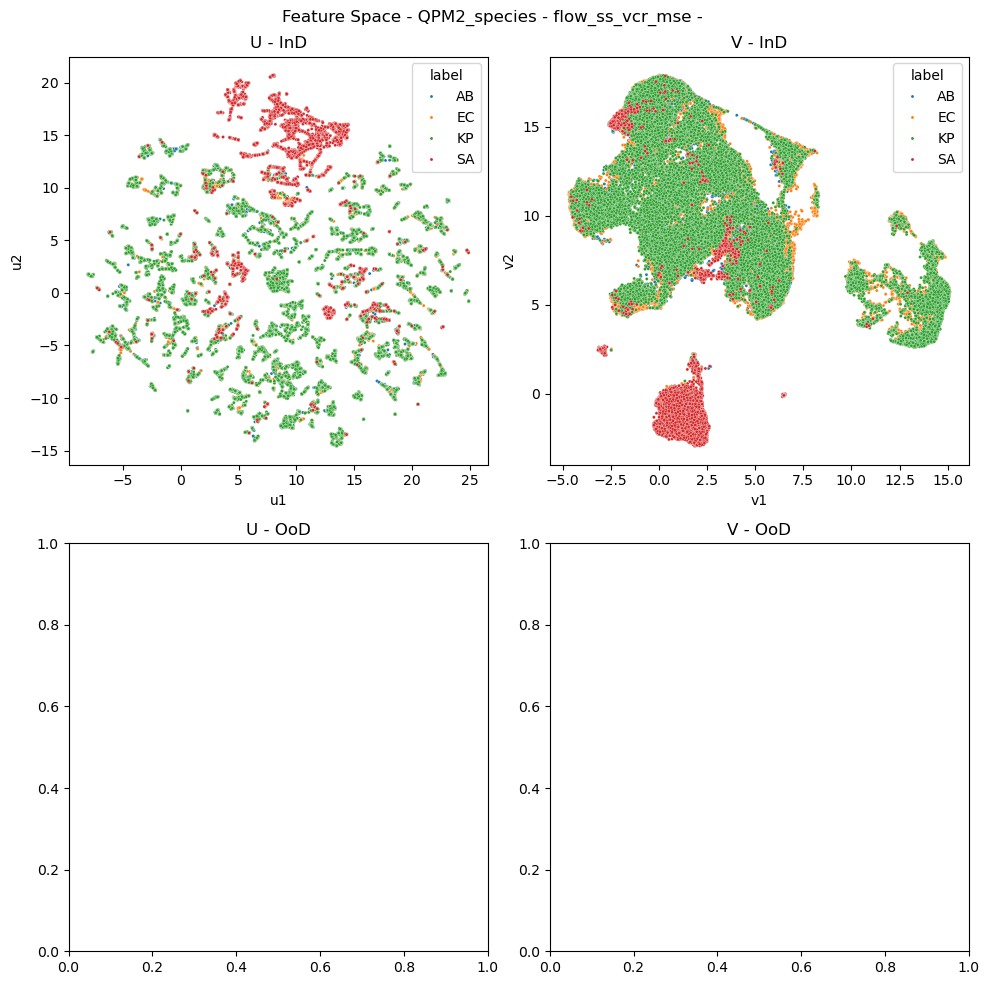

In [12]:
# plot feature space
ind_labels = [config.labels[i] for i in ind_tgt]
df_emb2d = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    df_emb2d = pd.concat([df_emb2d, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=df_emb2d[(df_emb2d['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)
plt.tight_layout()
plt.show()

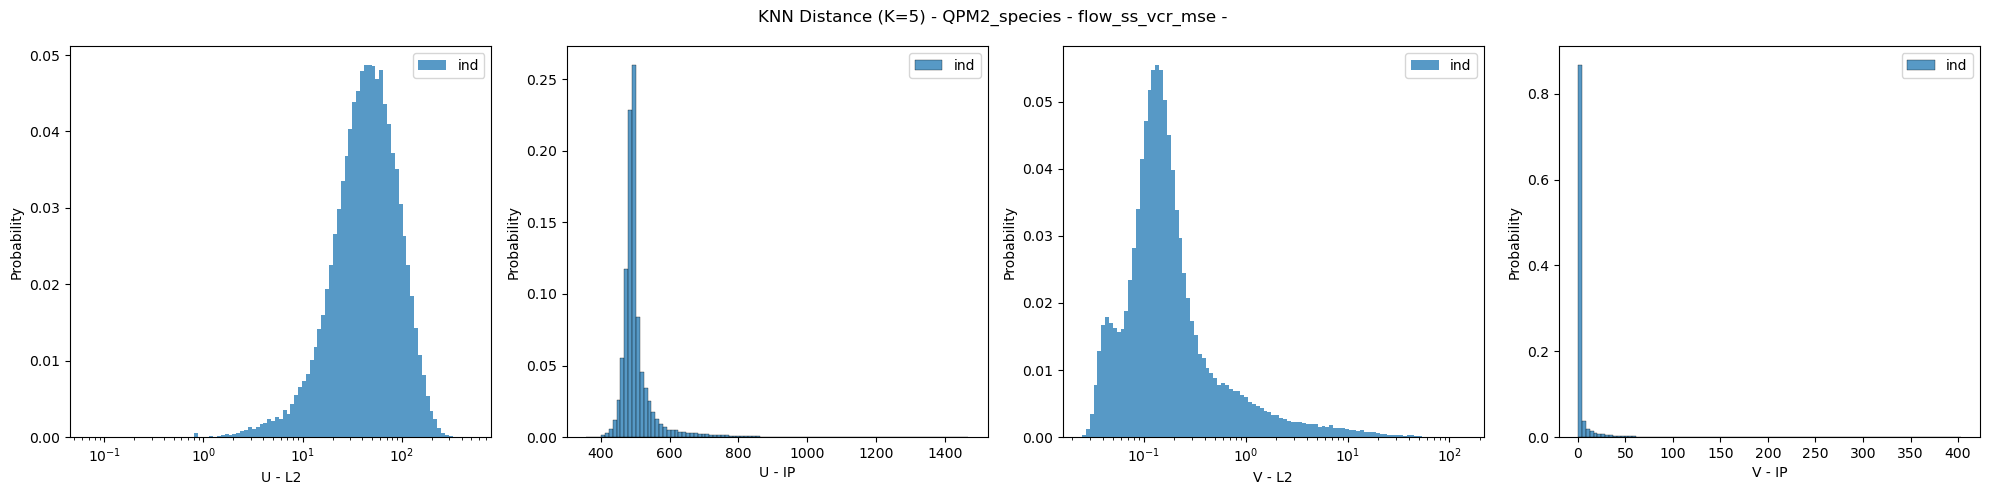

In [13]:
# plot knn distance from ind/ood to val data
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"KNN Distance (K=5) - {dataset_name} - {model_name} - {ood_str}")

def plot_knn_dists(index_fn, ax, idx_data, ind_data, ood_data=None, k=5, scale="linspace"):
    stats = {}
    index = index_fn(idx_data.shape[-1])
    index.add(idx_data)
    Di = index.search(ind_data, k)[0].mean(-1)
    D = [Di]
    T = [[0] * Di.shape[0]]
    if ood_str:
        Do = index.search(ood_data, k)[0].mean(-1)
        D.append(Do)
        T.append([1] * Do.shape[0]) 
    D = np.concatenate(D, axis=0)
    T = np.concatenate(T, axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    prefix = ""
    if ood_str:
        Ci = np.histogram(Di, bins, density=True)[0]
        Co = np.histogram(Do, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(Do, Di)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
        ax.set_title(f"KL={kld:.4f} EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale('log')
    ax.legend()
    return stats

run_stats["knn_u_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[0], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="logspace")
axs[0].set_xlabel("U - L2")
run_stats["knn_u_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[1], val_e_u, ind_e_u, ood_e_u if ood_str else None, scale="linspace")
axs[1].set_xlabel("U - IP")
run_stats["knn_v_l2"] = plot_knn_dists(faiss.IndexFlatL2, axs[2], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="logspace")
axs[2].set_xlabel("V - L2")
run_stats["knn_v_ip"] = plot_knn_dists(faiss.IndexFlatIP, axs[3], val_e_v, ind_e_v, ood_e_v if ood_str else None, scale="linspace")
axs[3].set_xlabel("V - IP")
plt.tight_layout()
plt.show()

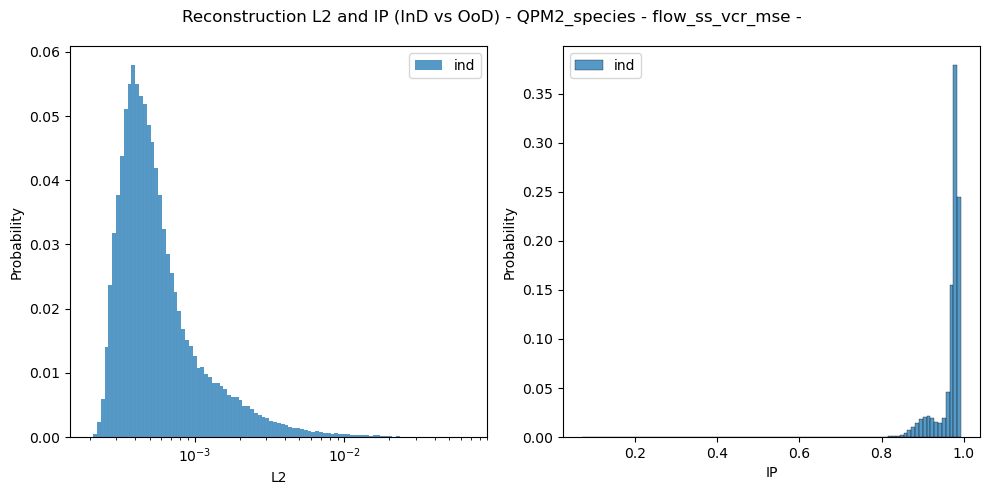

In [14]:
# plot reconstruction-based ood metrics
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# data
_ind_inp = ind_inp.reshape((ind_inp.shape[0], -1))
_ind_rcn = ind_rcn.reshape((ind_inp.shape[0], -1))
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
# metrics
ind_rcn_l2 = ((_ind_inp - _ind_rcn) ** 2).mean(-1)
ind_rcn_ip = (_ind_inp_unit * _ind_rcn_unit).sum(-1)

if ood_str:
    # data
    _ood_inp = ood_inp.reshape((ood_inp.shape[0], -1))
    _ood_rcn = ood_rcn.reshape((ood_inp.shape[0], -1))
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    # metrics
    ood_rcn_l2 = ((_ood_inp - _ood_rcn) ** 2).mean(-1)
    ood_rcn_ip = (_ood_inp_unit * _ood_rcn_unit).sum(-1)

def plot_rcn(ind_rcn, ood_rcn, ax, scale="linspace"):
    stats = {}
    D = ind_rcn
    if ood_str:
        D = np.concatenate([ind_rcn, ood_rcn], axis=0)
    if scale == "linspace":
        s, e = D.min(), D.max()
        bins = np.linspace(s, e, 100)
    if scale == "logspace":
        s, e = np.log10(D.min() + 1e-7), np.log10(D.max())
        bins = np.logspace(s, e, 100)
    sns.histplot(ind_rcn, label="ind", stat="probability", bins=bins, ax=ax)
    if ood_str:
        sns.histplot(ood_rcn, label="ood", stat="probability", bins=bins, ax=ax)
        T = np.concatenate([[0]*ind_rcn.shape[0],[1]*ood_rcn.shape[0]], axis=0)
        Ci = np.histogram(ind_rcn, bins, density=True)[0]
        Co = np.histogram(ood_rcn, bins, density=True)[0]
        kld = entropy(Co + 1e-7, Ci + 1e-7)
        emd = wasserstein_distance(ood_rcn, ind_rcn)
        auc = roc_auc_score(T, D)
        auc = max(auc, 1-auc)
        ax.set_title(f"KL={kld:.4f}, EMD={emd:.4f}, AUC={auc:.4f}")
        stats.update(dict(kld=kld, emd=emd, auc=auc))
    if scale == "logspace":
        ax.set_xscale("log")
    ax.legend()
    return stats

run_stats["rcn_l2"] = plot_rcn(ind_rcn_l2, ood_rcn_l2 if ood_str else None, ax1, scale="logspace")
ax1.set_xlabel("L2")
run_stats["rcn_ip"] = plot_rcn(ind_rcn_ip, ood_rcn_ip if ood_str else None, ax2, scale="linspace")
ax2.set_xlabel("IP")
plt.suptitle(f"Reconstruction L2 and IP (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

In [15]:
# compute vector norms
trn_n_u = np.linalg.norm(trn_e_u, axis=-1)
trn_n_v = np.linalg.norm(trn_e_v, axis=-1)
val_n_u = np.linalg.norm(val_e_u, axis=-1)
val_n_v = np.linalg.norm(val_e_v, axis=-1)
ind_n_u = np.linalg.norm(ind_e_u, axis=-1)
ind_n_v = np.linalg.norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = np.linalg.norm(ood_e_u, axis=-1)
    ood_n_v = np.linalg.norm(ood_e_v, axis=-1)
rnd_n_u = np.linalg.norm(rnd_e_u, axis=-1)
rnd_n_v = np.linalg.norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

22.966408 0.96301484 1.1812987 1.3039932
22.963226 0.987592 1.1833645 1.3346313
22.925726 0.9646502 1.0904034 1.1821233
35.148922 1.0760479 54.130077 0.7609546


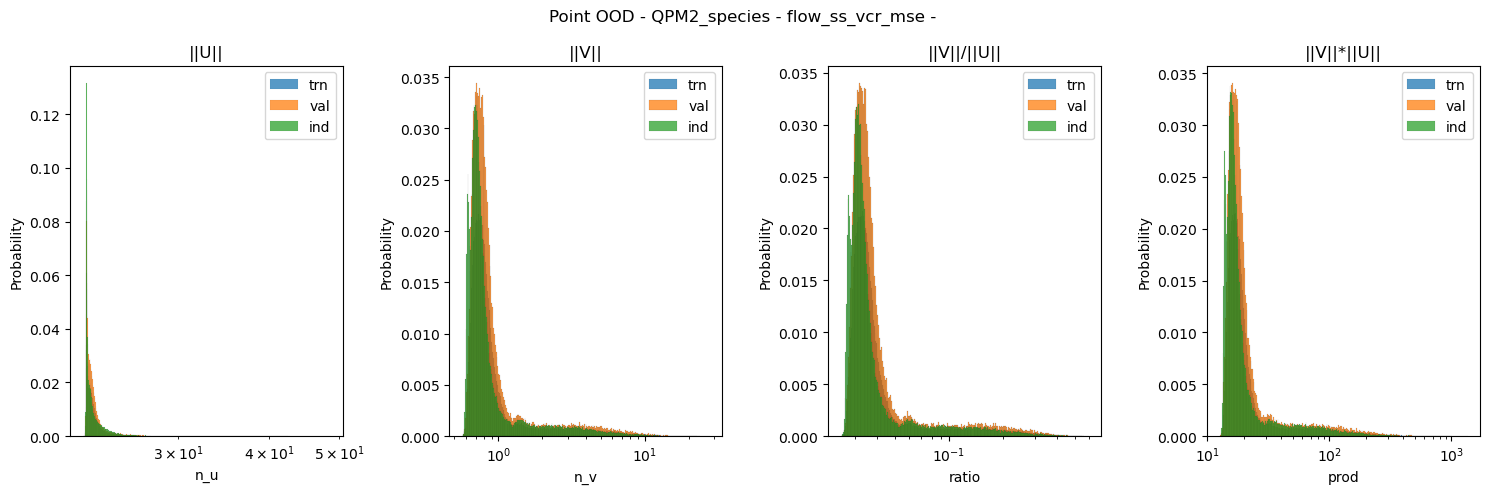

In [16]:
# plot pointwise ood metrics
df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='probability', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [17]:
# organize data by class, aggregate groupwise
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


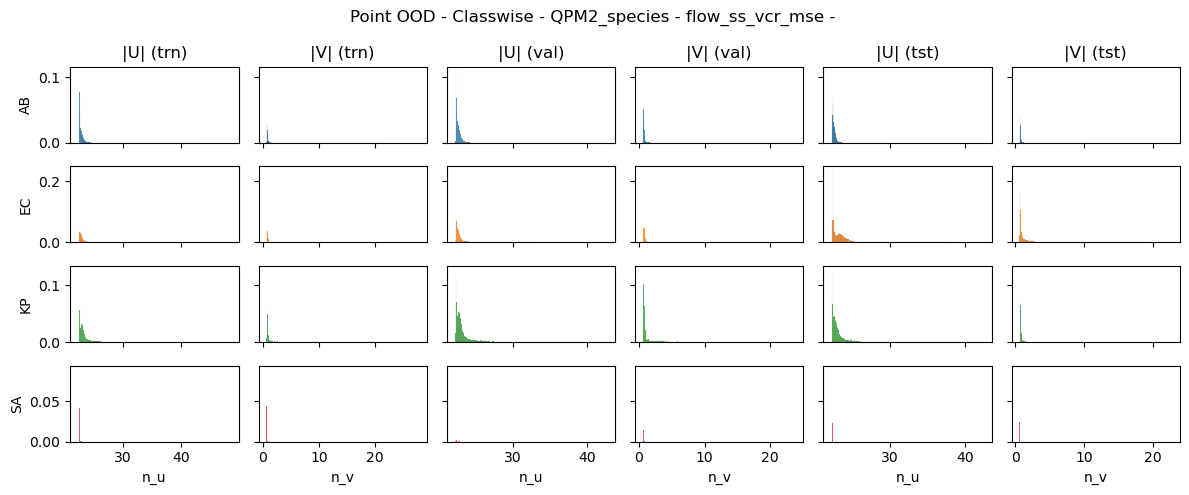

In [18]:
# plot per-class pointwise ood metrics
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

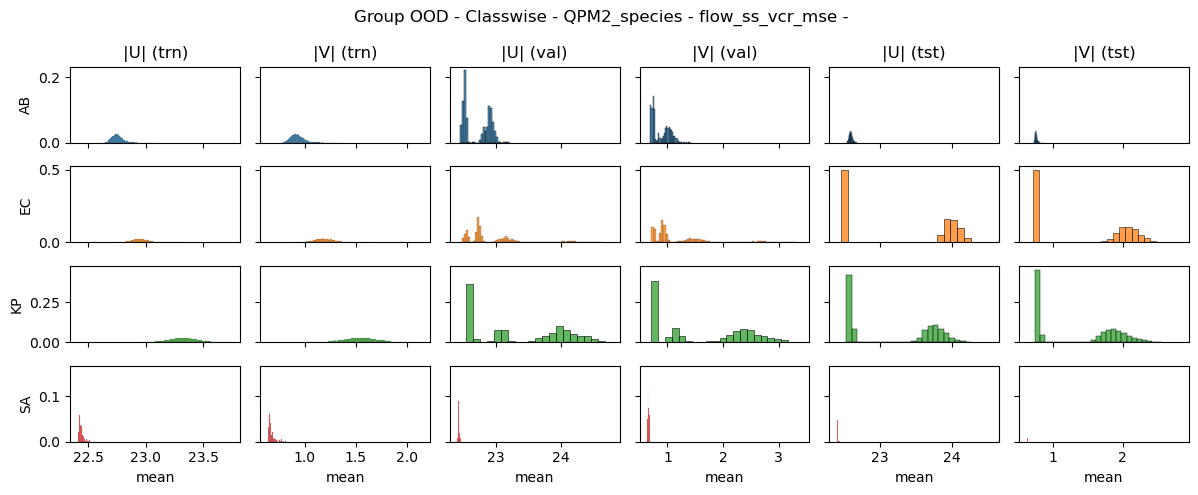

In [19]:
# plot per-class groupwise ood metrics
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='row')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, stat='probability', ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

In [20]:
run_stats.update(dict(dataset_name=dataset_name, model_name=model_name, ood=ood))

import json
from datetime import datetime
with open(f"assets/results/{datetime.now()}.json", "w") as f:
    json.dump(run_stats, f)